<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data
import numpy as np
from datetime import datetime, timedelta

c:\python\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [45]:
# (datetime.today() - timedelta(days=59)).strftime("%Y-%m-%d")
int(datetime.today().strftime("%m"))%15

5

In [44]:
5%15

5

In [2]:
# НАстройка отображения графиков
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
import matplotlib.dates as mdates
import pylab
plt.rcParams['figure.figsize'] = (20, 12)

In [3]:
# Загружаем список наименований акций
stock_df = pd.read_csv(r'../../input/stock_list.csv')
stock_df.Symbols = stock_df.Symbols + '.ME'
stock_df.head()

Symbols
0  AFLT.ME
1  SBER.ME
2  GAZP.ME
3  LKOH.ME
4  GMKN.ME

In [4]:
kot_dict = {}
for tool in stock_df.Symbols.values:
    kot_dict[tool.split('.')[0]] = yf.download(tool,'2020-03-28', interval = '15m')   

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [5]:
# (datetime.today() - timedelta(days=59)).strftime("%Y-%m-%d")

In [6]:
# df = yf.download('SBER.ME','2020-03-23', interval = '15m') 

In [7]:
def add_ma(df, ma_samp_param, column):
    name = f'ma_{column}_{ma_samp_param}'
    df[name] = df[column].rolling(window=ma_samp_param,min_periods=ma_samp_param).median()
    return df, name

In [8]:
def rez_graf(df, tool):
    fig, ax = plt.subplots()
    ax = pylab.subplot(1, 1, 1)
    ax.set_title(tool)
    ax.plot(df['Close_long'],linewidth=3, color='g')
    ax.plot(df['Close_Short'],linewidth=3, color='r')
    plt.show()
    fig, ax = plt.subplots()
    ax = pylab.subplot(1, 1, 1)
    ax.plot(df.bank_change,linewidth=2)
    plt.show()

In [9]:
def tred_test(df, tool):    
    # Параметры
    ma_fast = 15
    ma_slow = 40
    ma_volume = 5

    # Среднее значение цены
    df['Median'] = (df.Open + df.Close)/2
    # Создание лини для сигнала
    df, ma_fast_name = add_ma(df, 10, 'Close')
    df, ma_slowt_name = add_ma(df, 60, 'Median')
    df, ma_volume_name = add_ma(df, 5, 'Volume')

    # Разность цен
    df['ma_razn'] = df[ma_fast_name] - df[ma_slowt_name]
    df['ma_razn_lag'] = df['ma_razn'].shift(1)
    df[df.ma_razn>0]

    # Установка сигналов
    df['SIGNAL'] = (df['ma_razn']>0)&(df['ma_razn_lag']<0)|(df['ma_razn']<0)&(df['ma_razn_lag']>0)
    df['long_POZISION'] = (df['ma_razn'] > 0)
    df['short_POZISION'] = (df['ma_razn'] < 0)
    df['price_change'] = (df['Close'] - df['Close'].shift(1))/df['Close']

    # Расчет априбыльности
    for index in df.index:
        df.loc[index, 'bank_change'] = df[df.long_POZISION == True].loc[:index, 'price_change'].sum()
    df['bank_change_izm'] = df['bank_change'] - df['bank_change'].shift(1)
    # Для отрисовки периодов продажи и покупки
    df['Close_long'] = df.loc[:,'Close'][df.long_POZISION == True]
    df['Close_Short'] = df.loc[:,'Close'][df.long_POZISION == False]
    
    # Вывод графика
    rez_graf(df, tool)
    return df

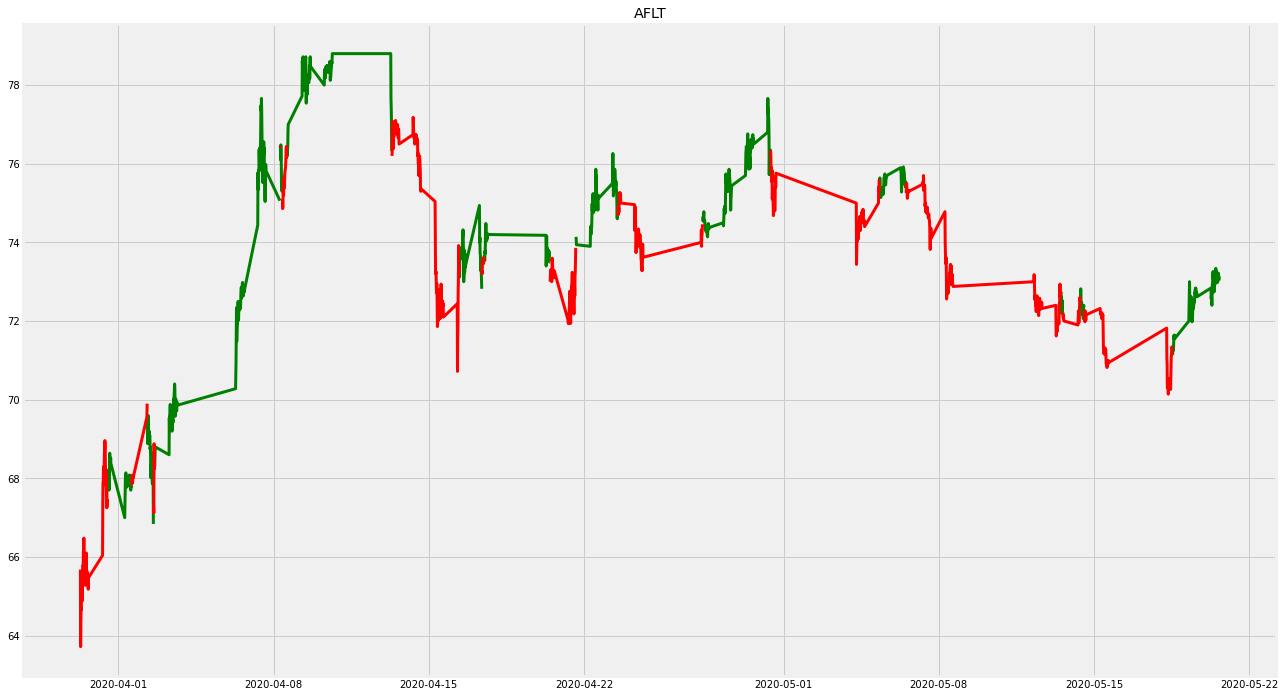

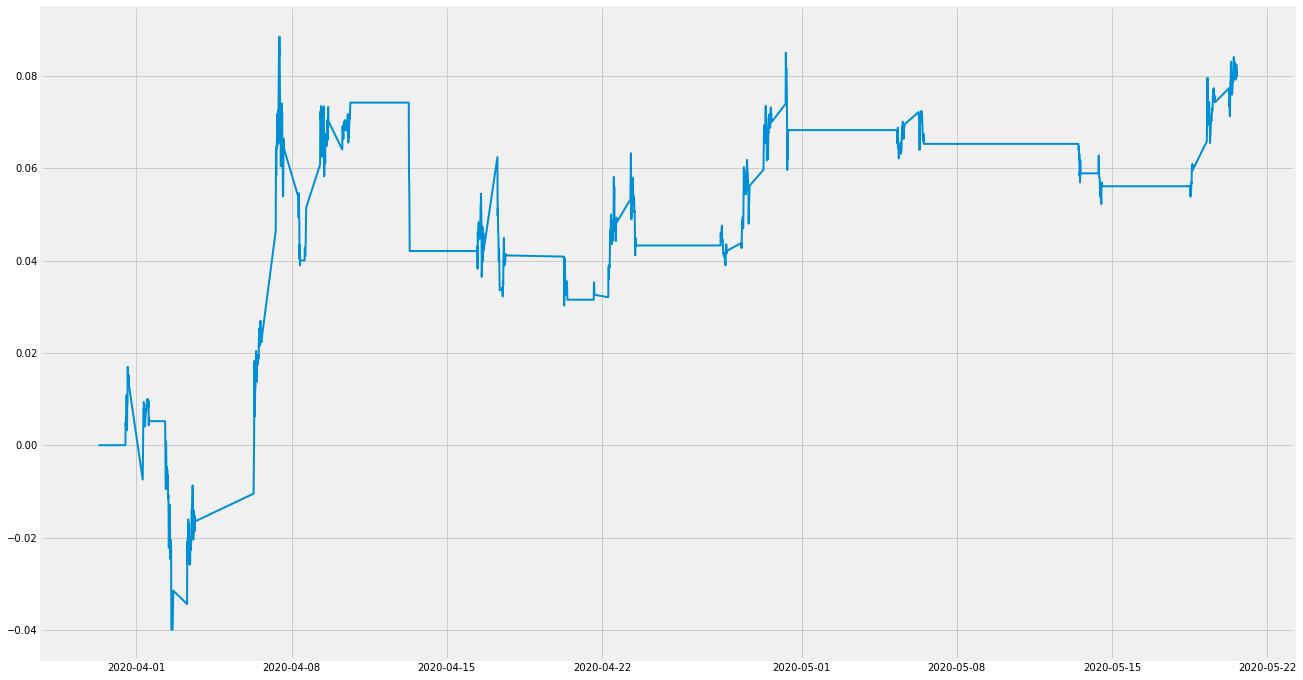

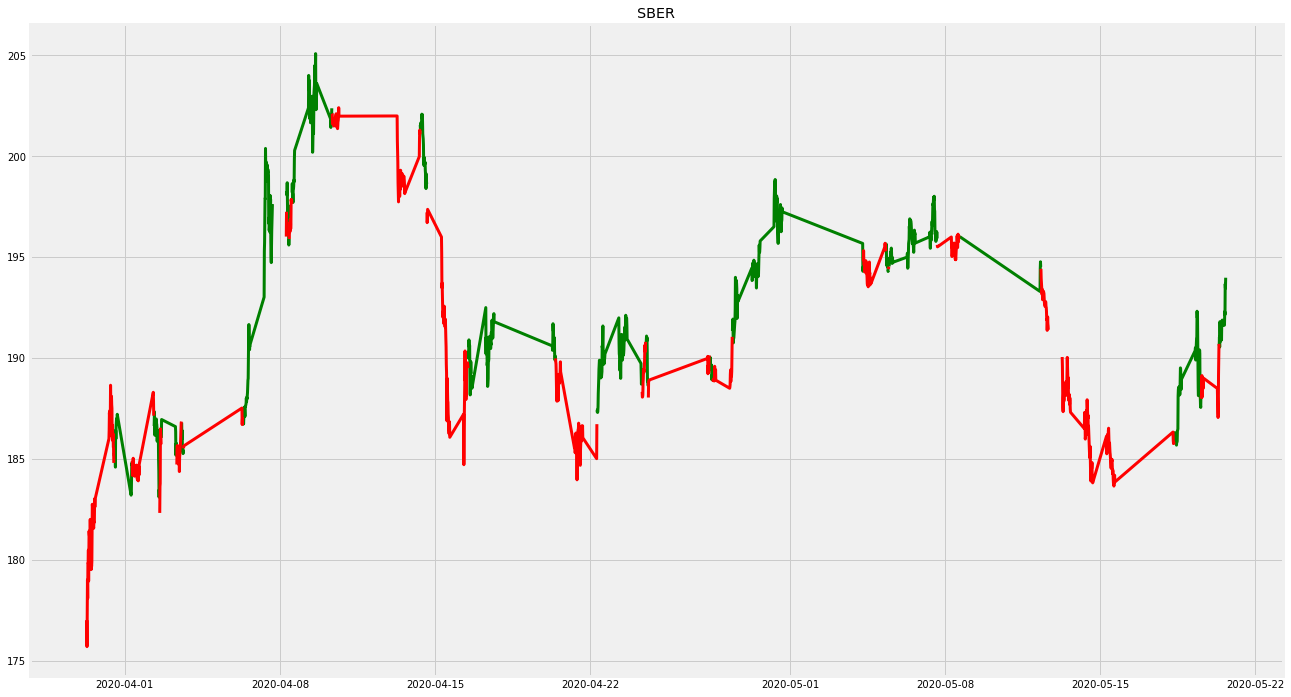

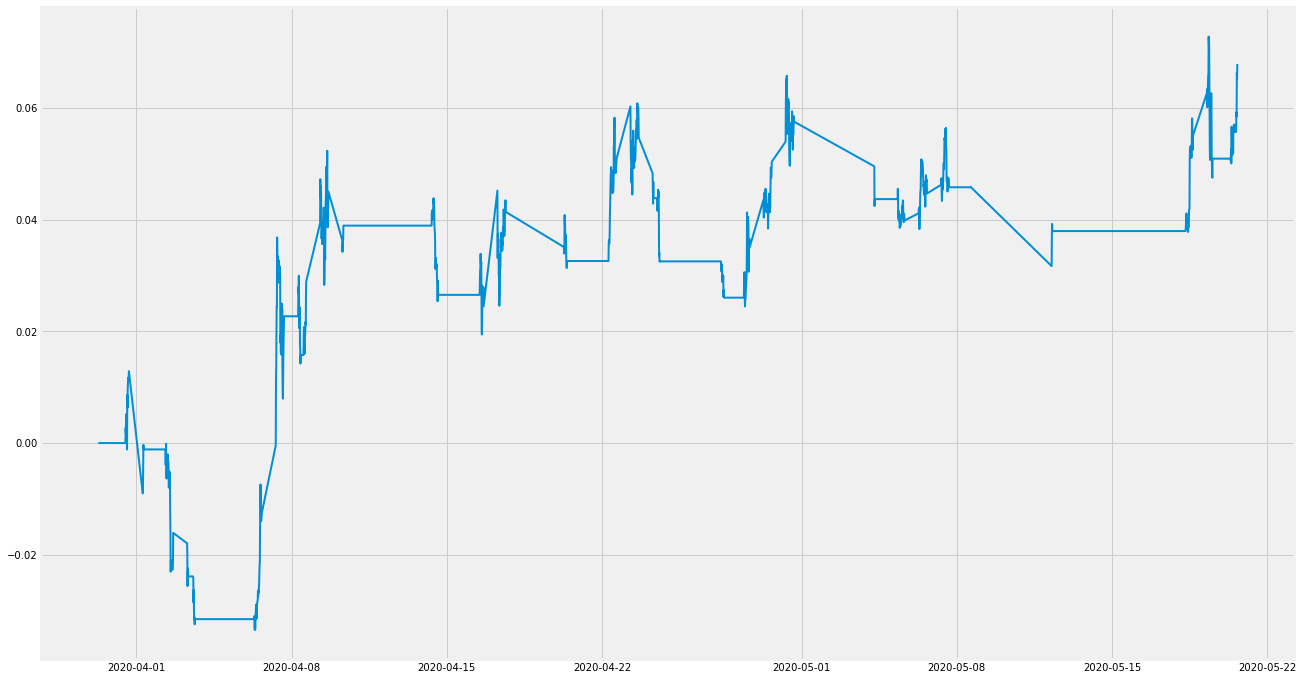

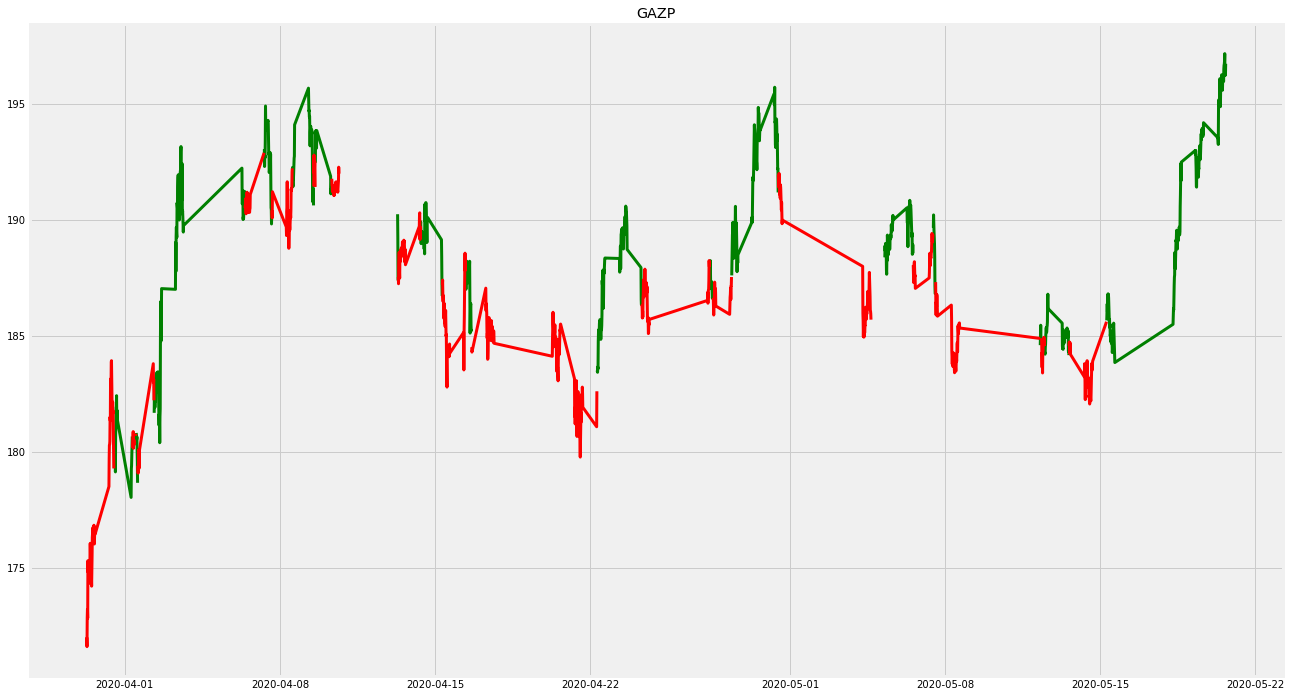

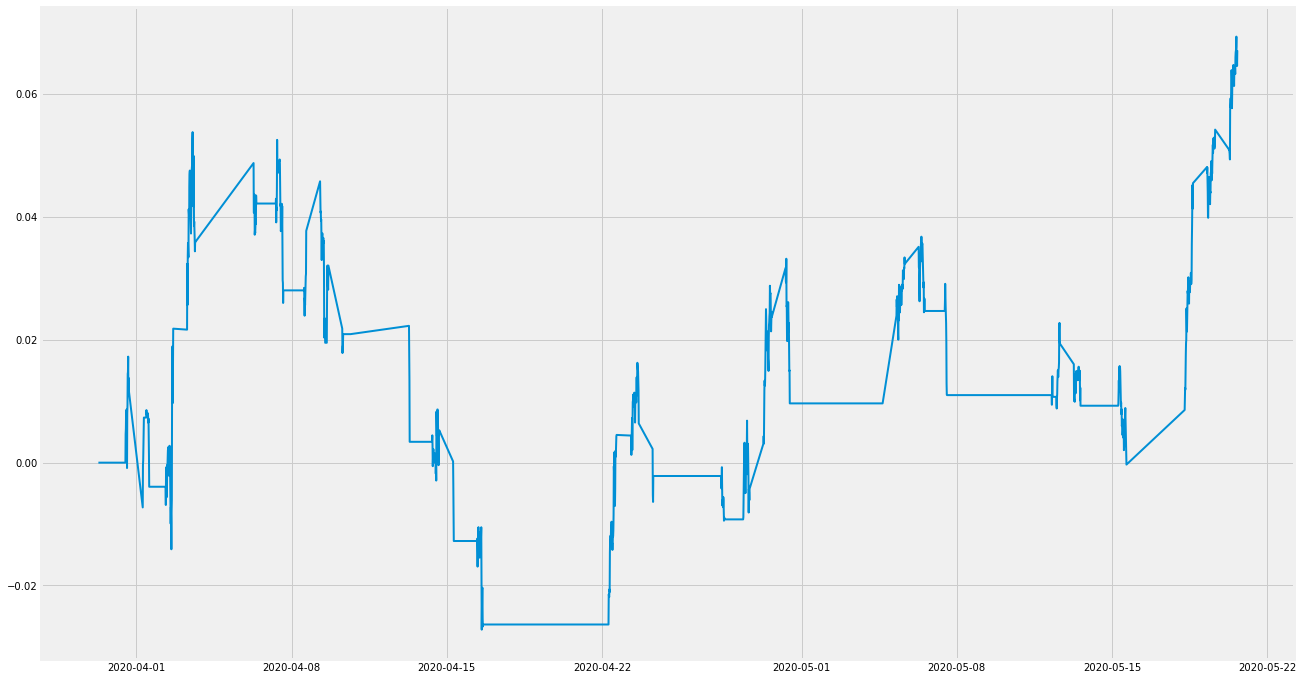

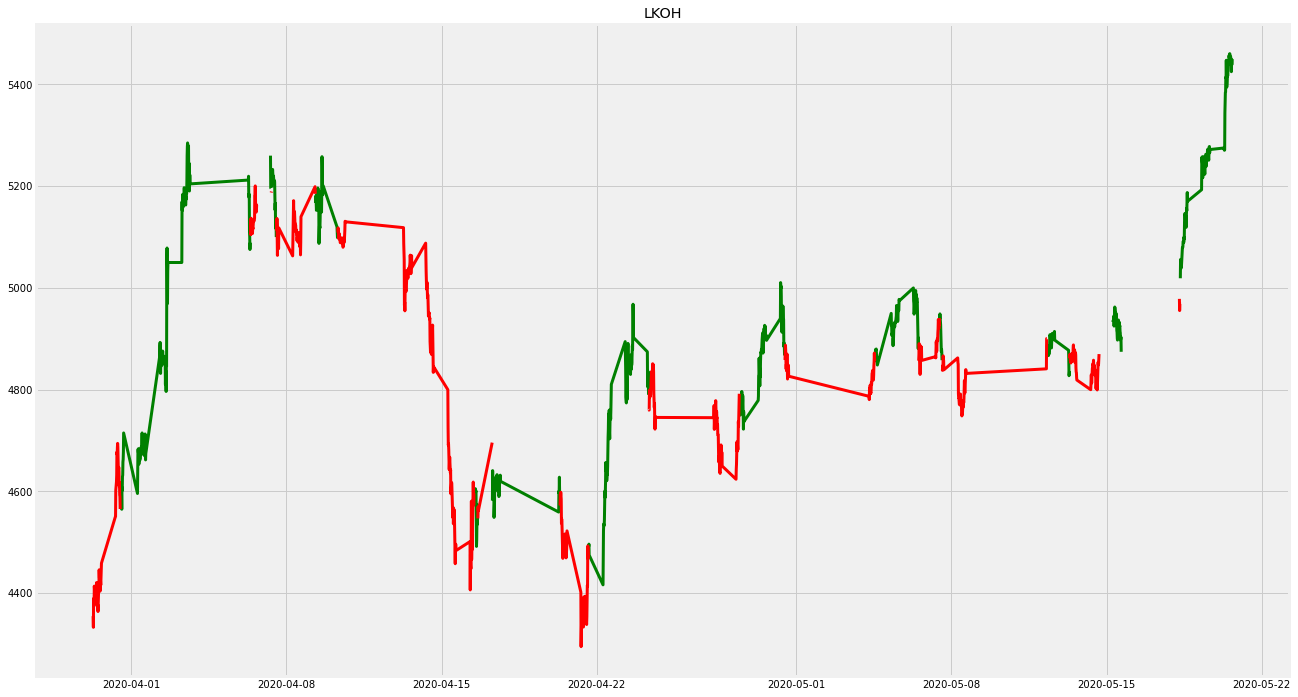

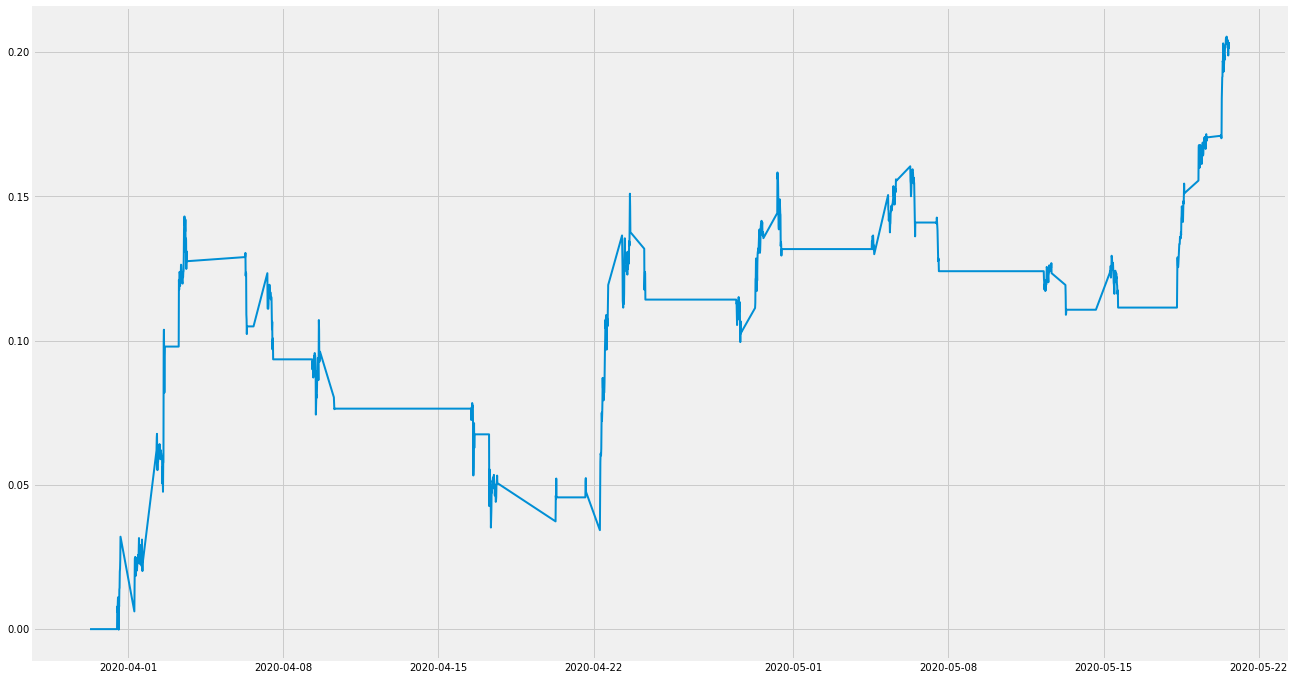

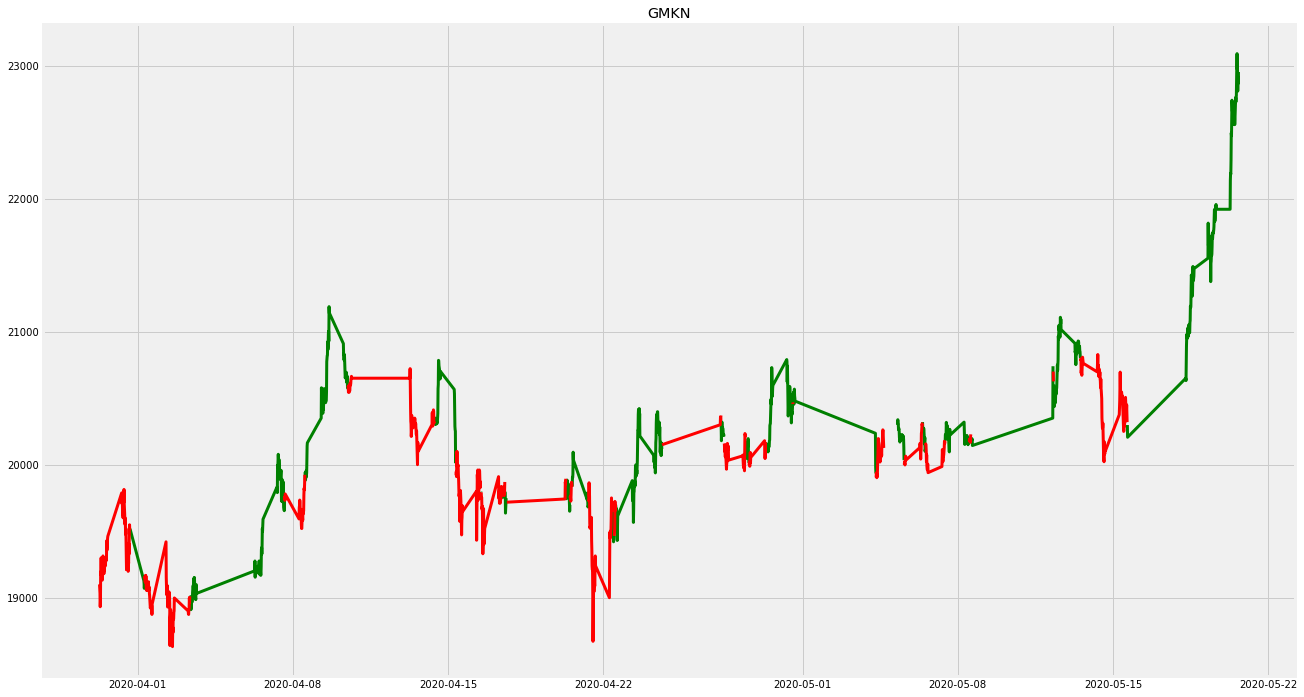

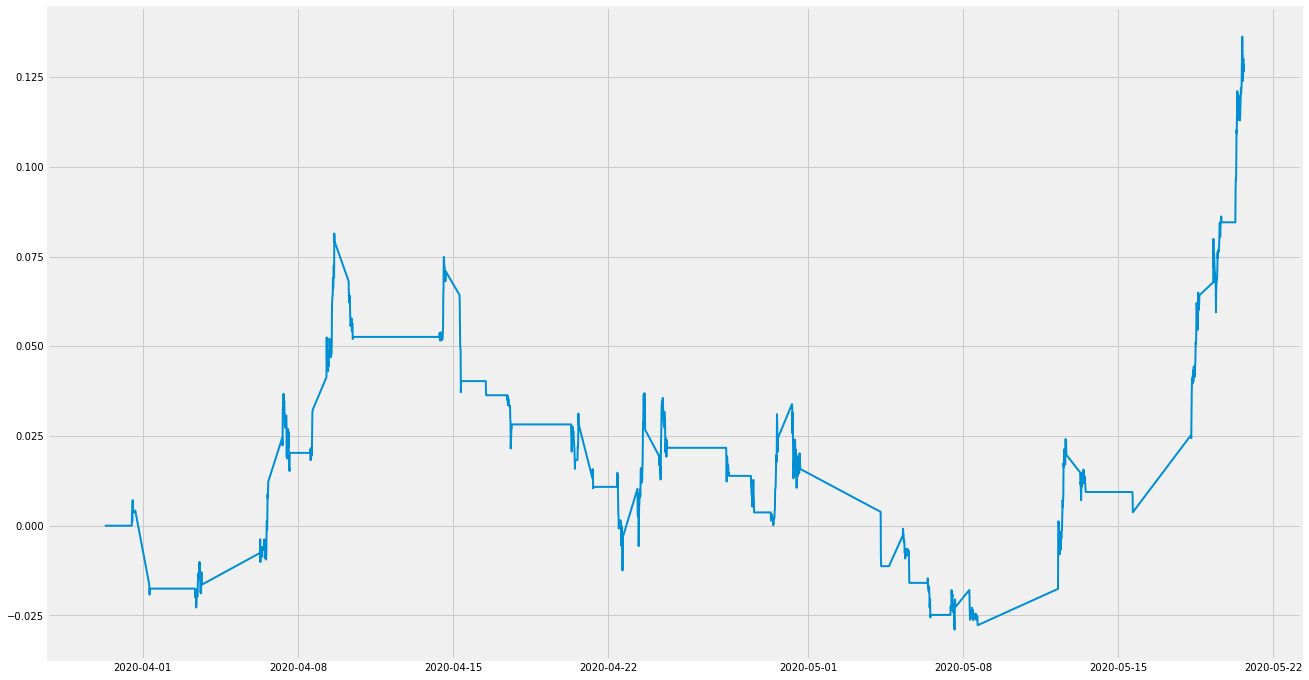

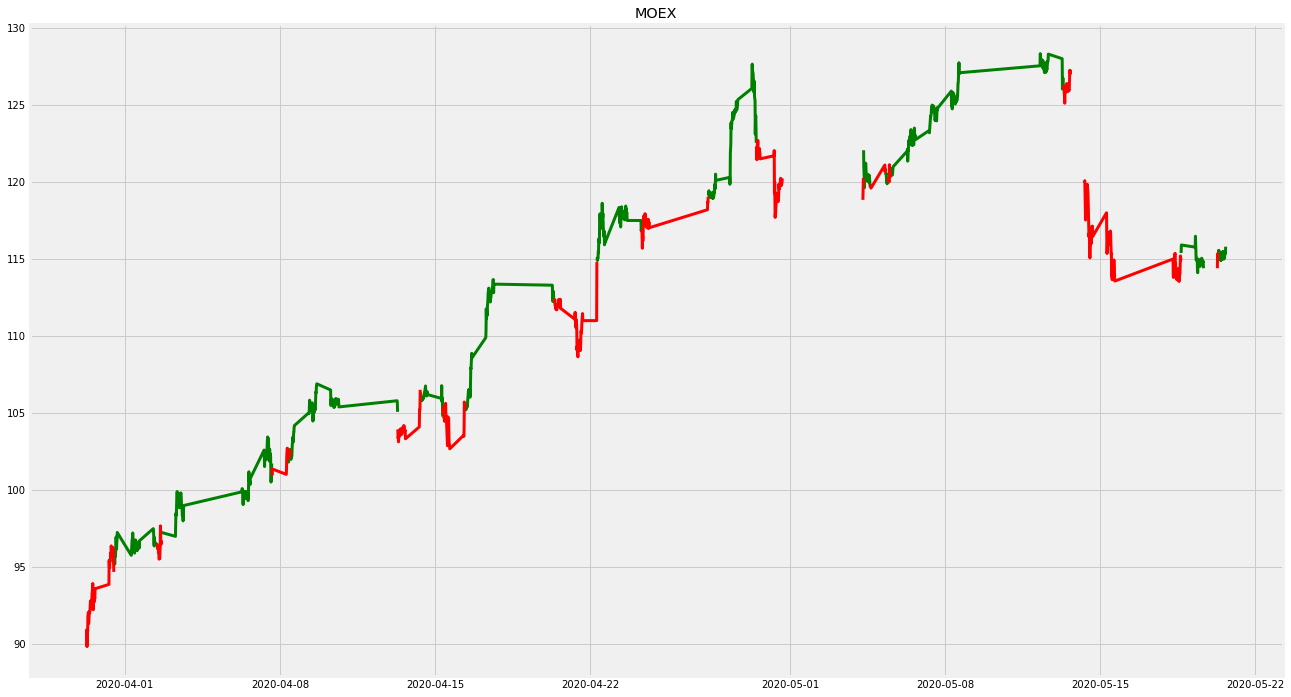

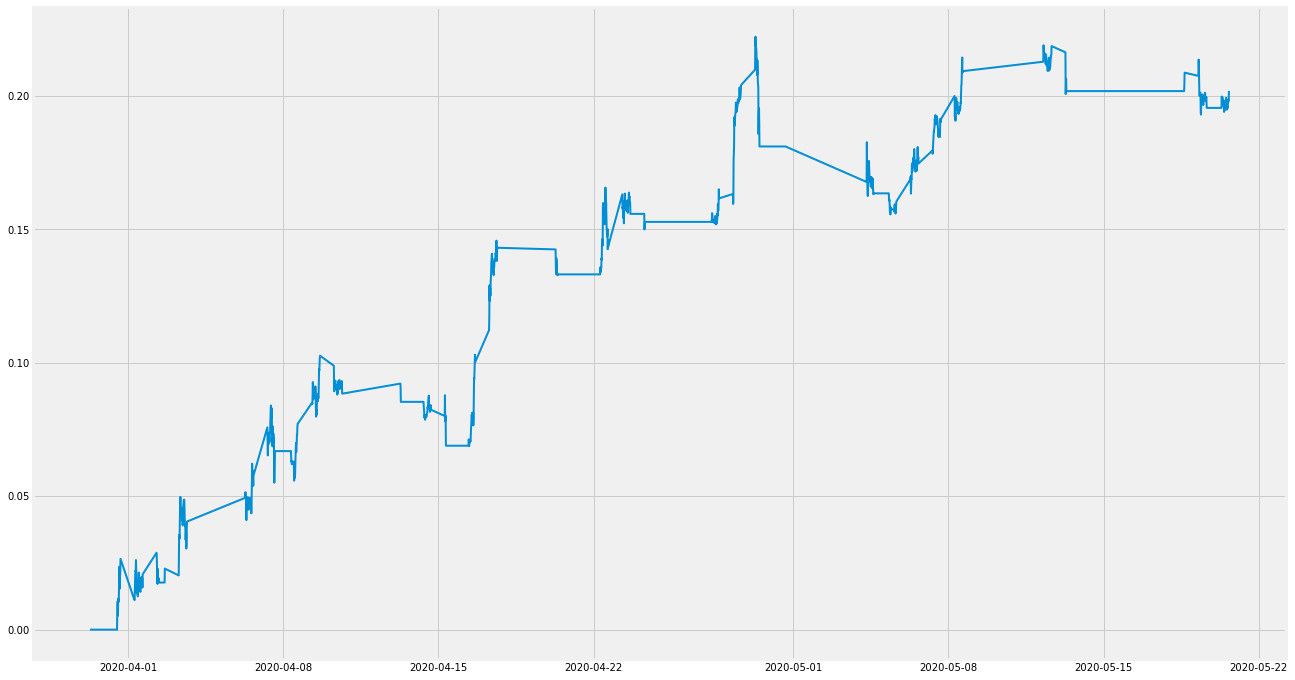

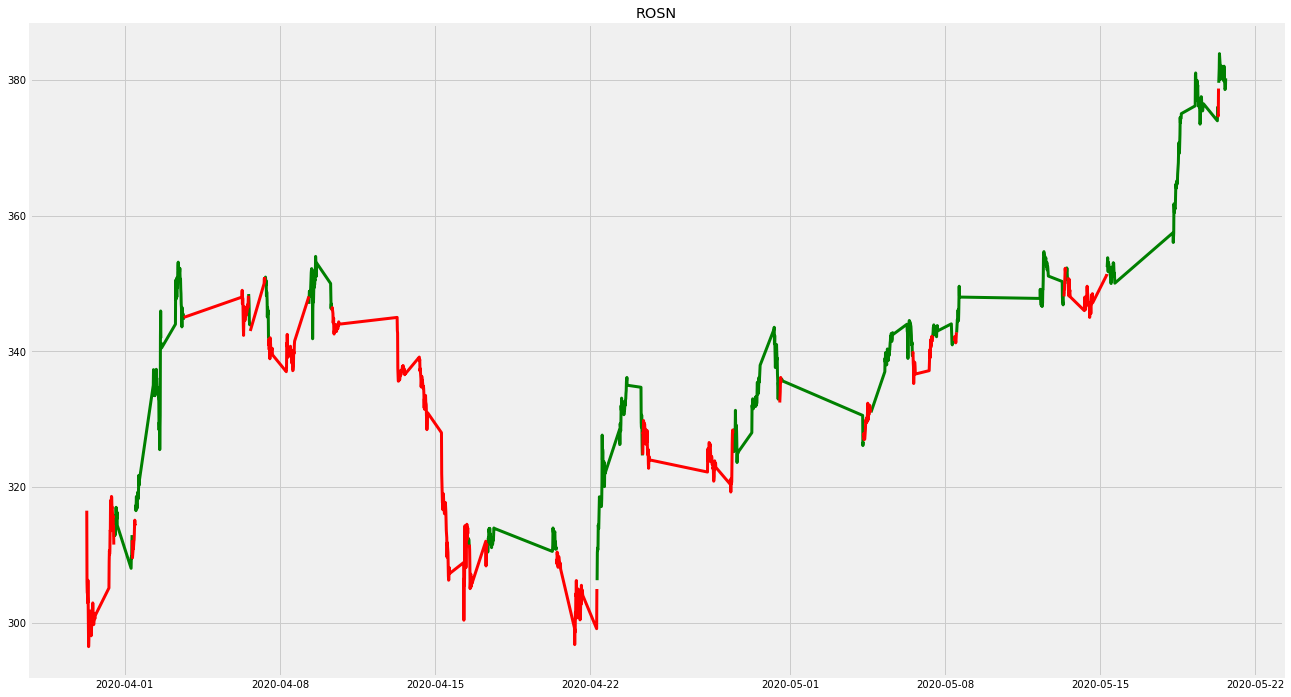

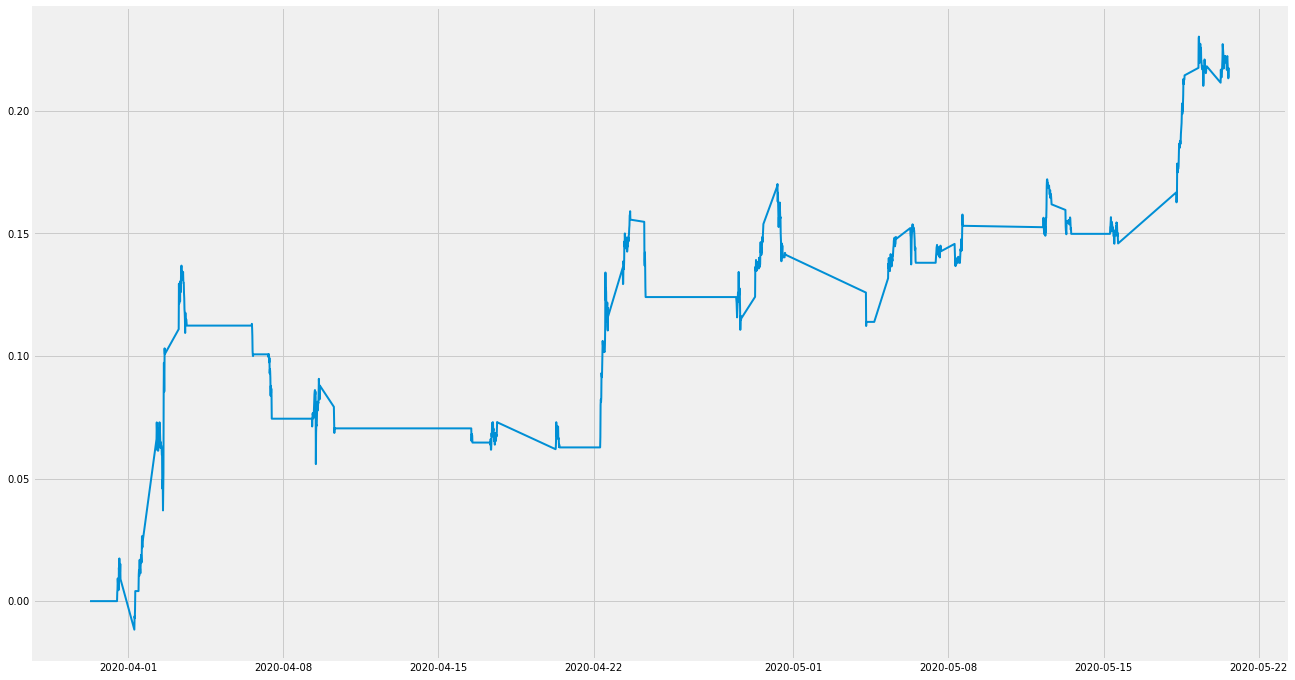

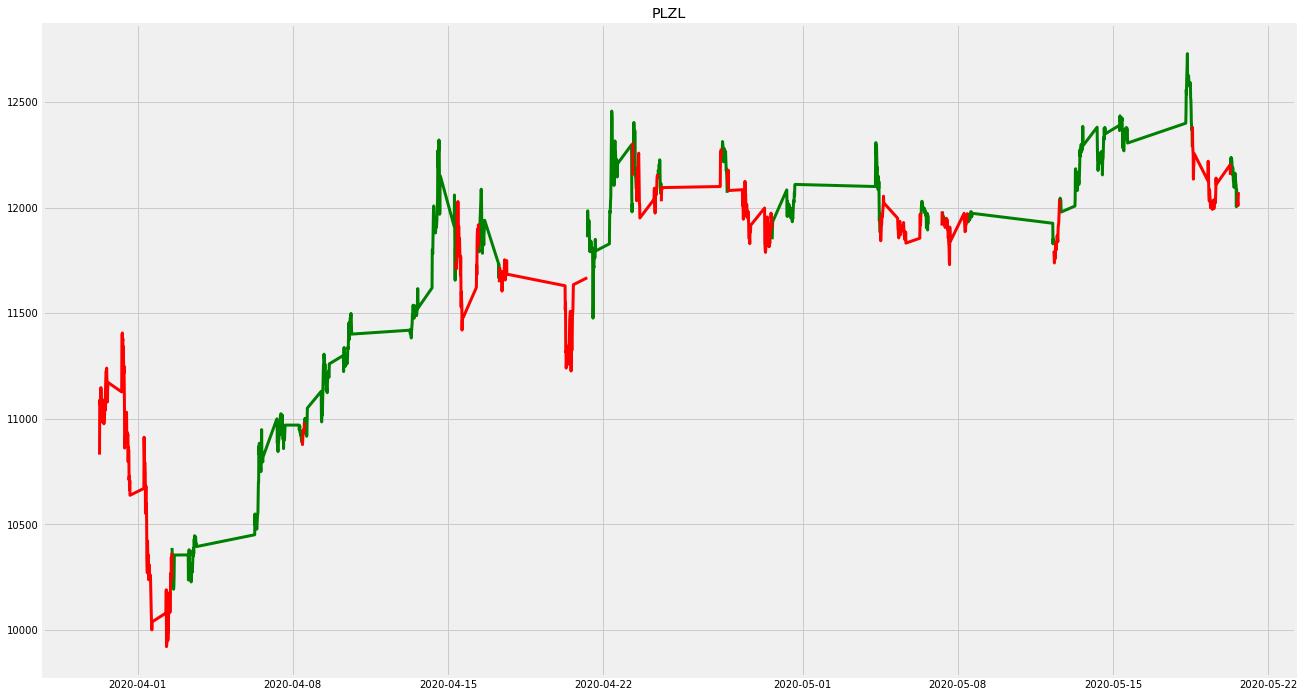

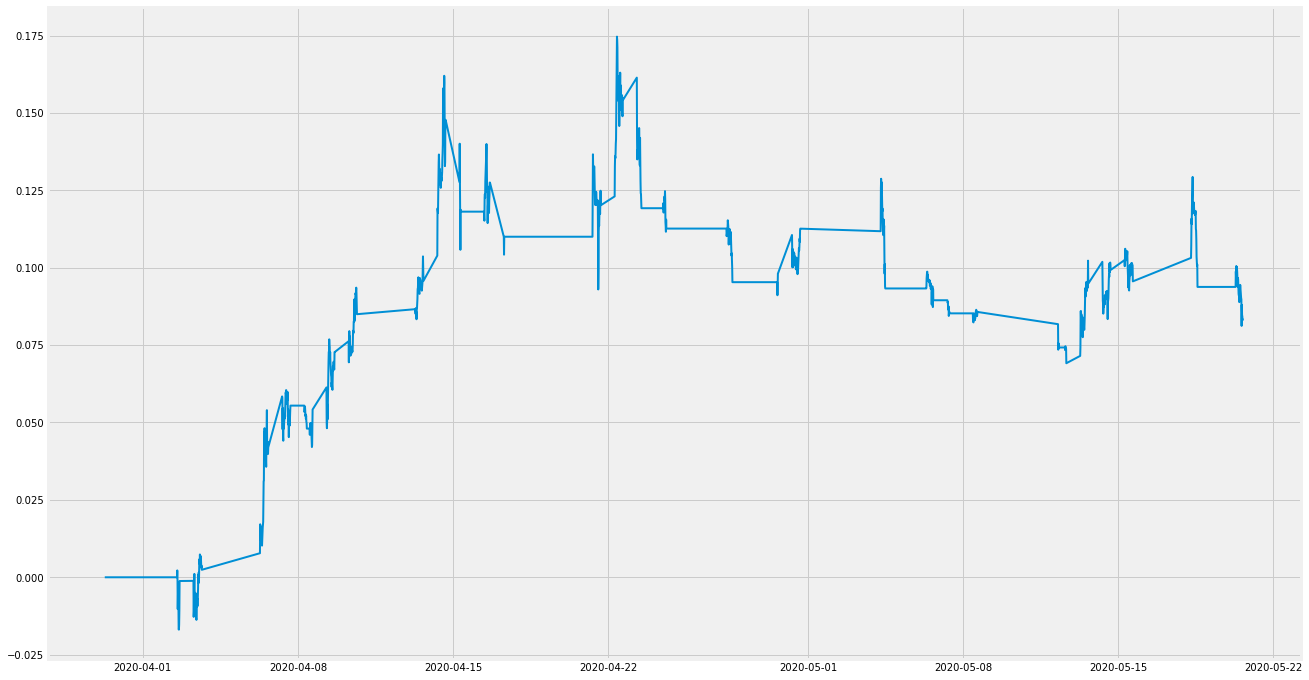

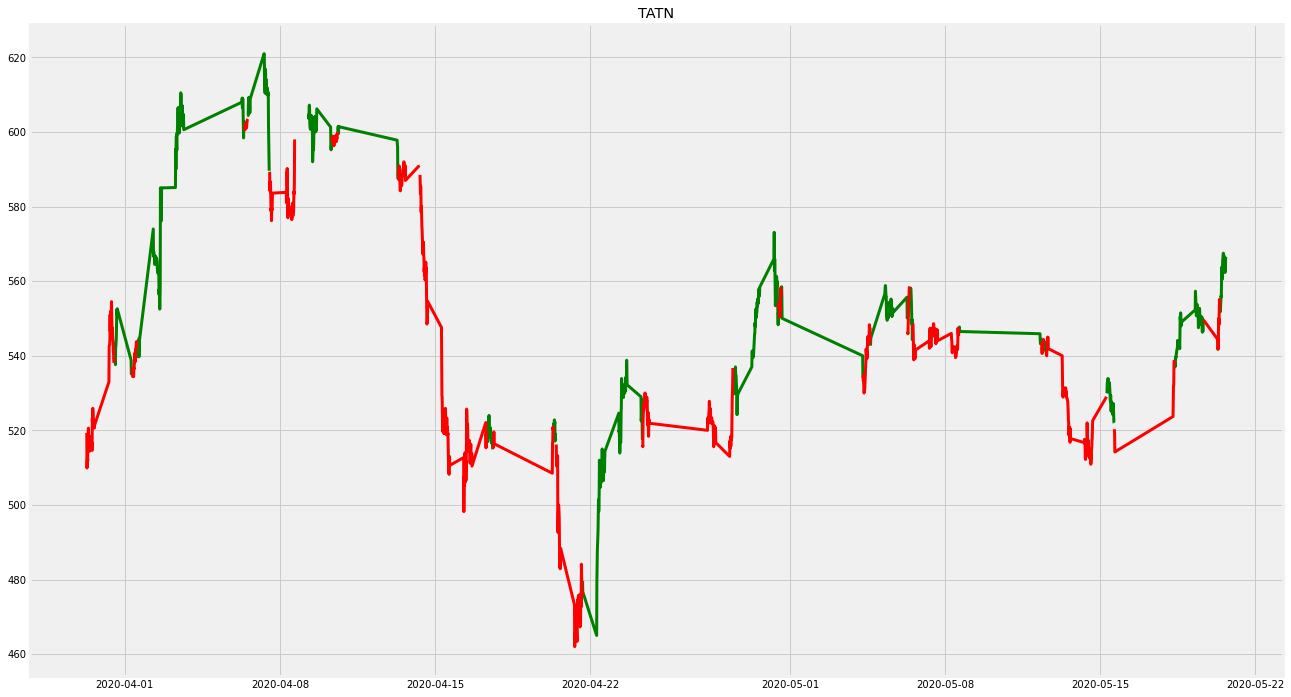

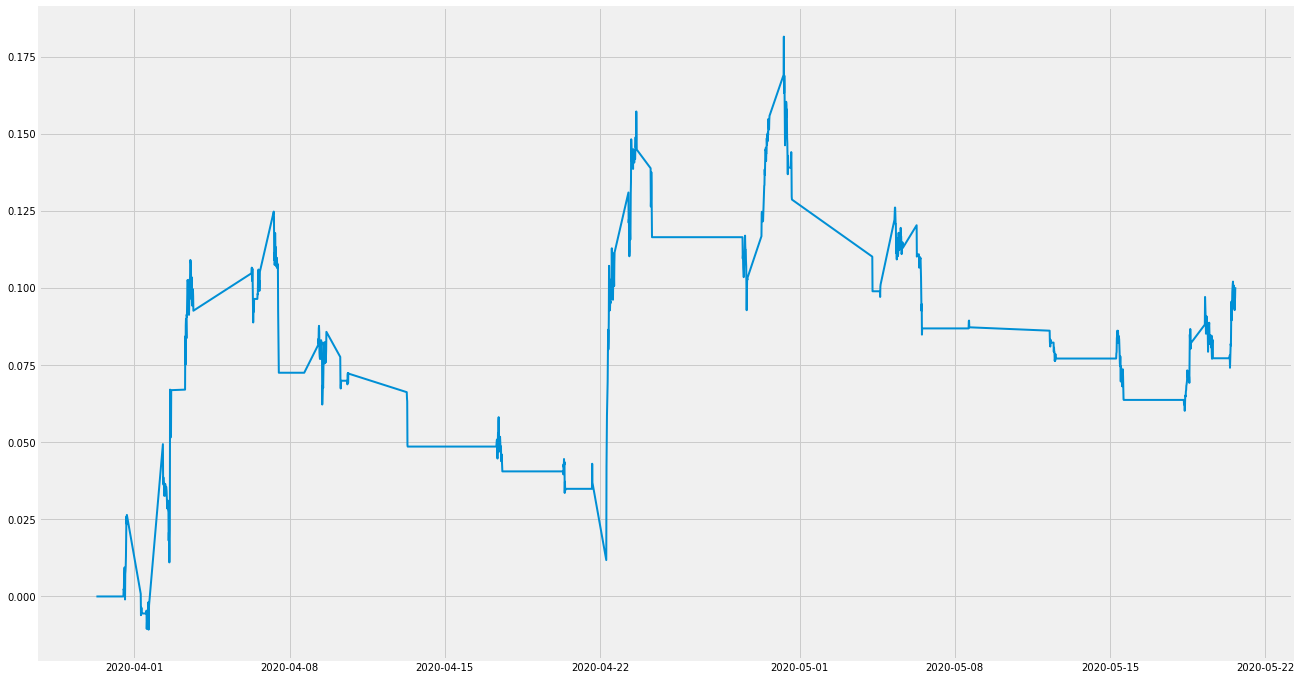

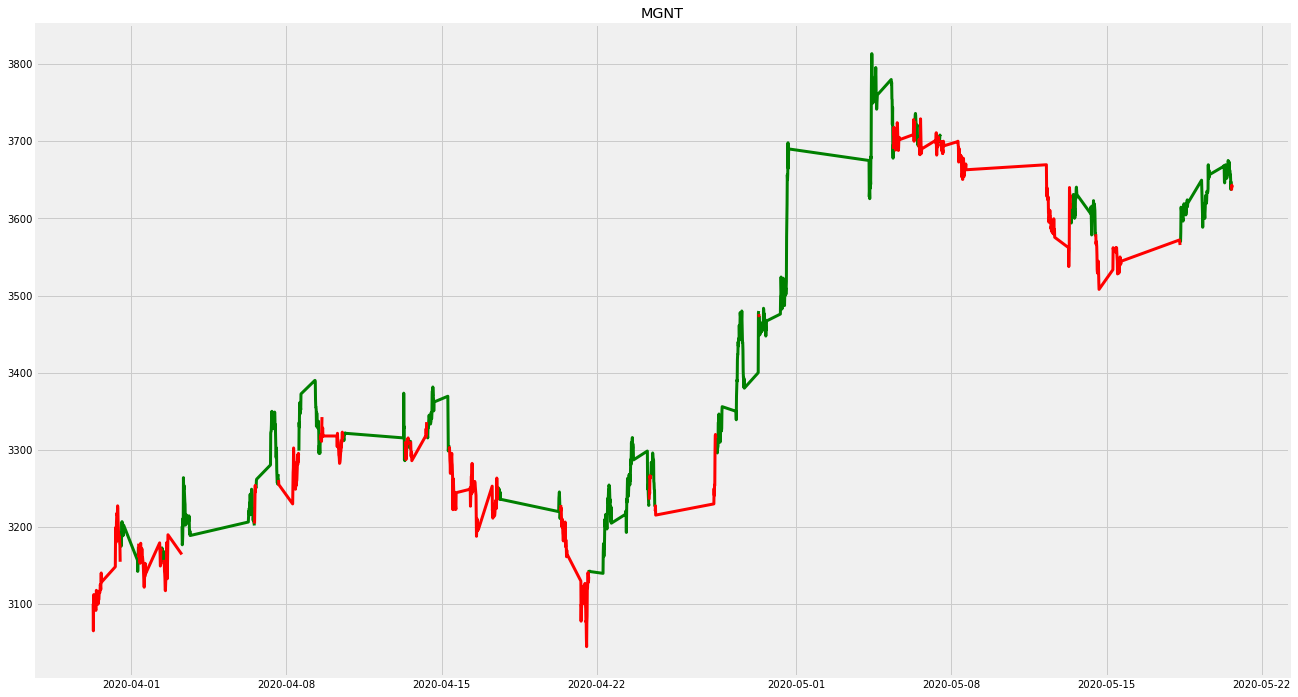

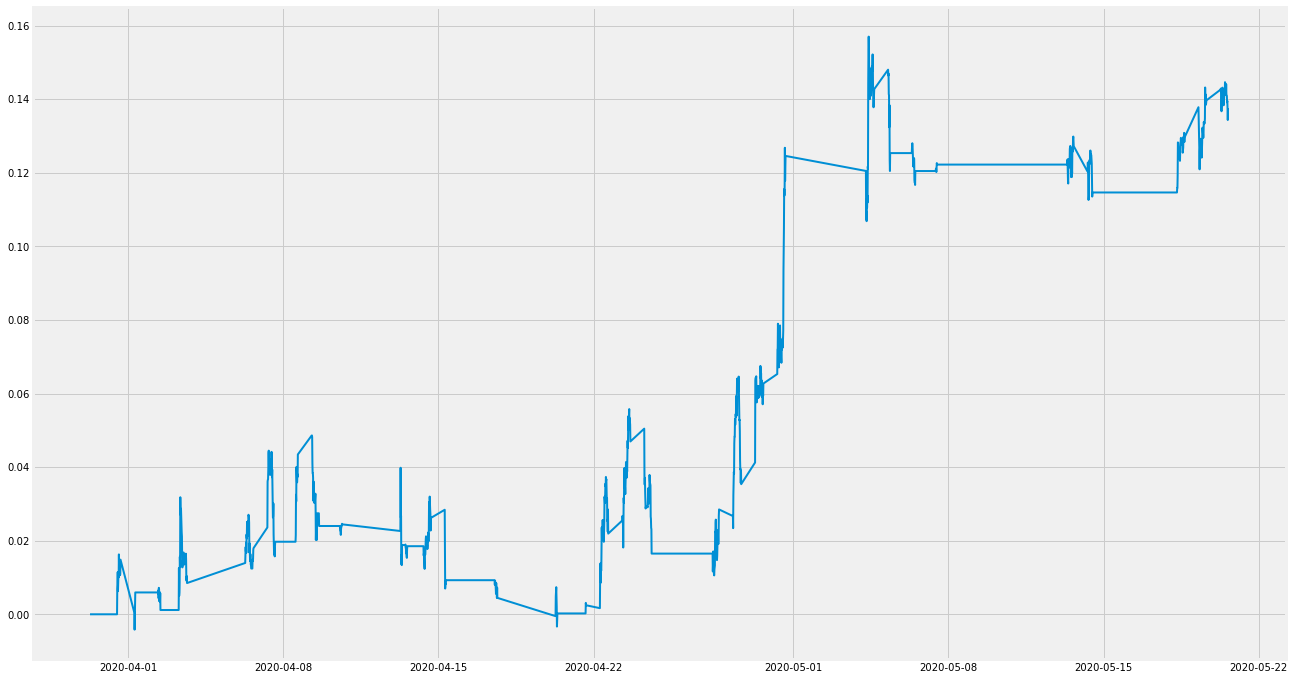

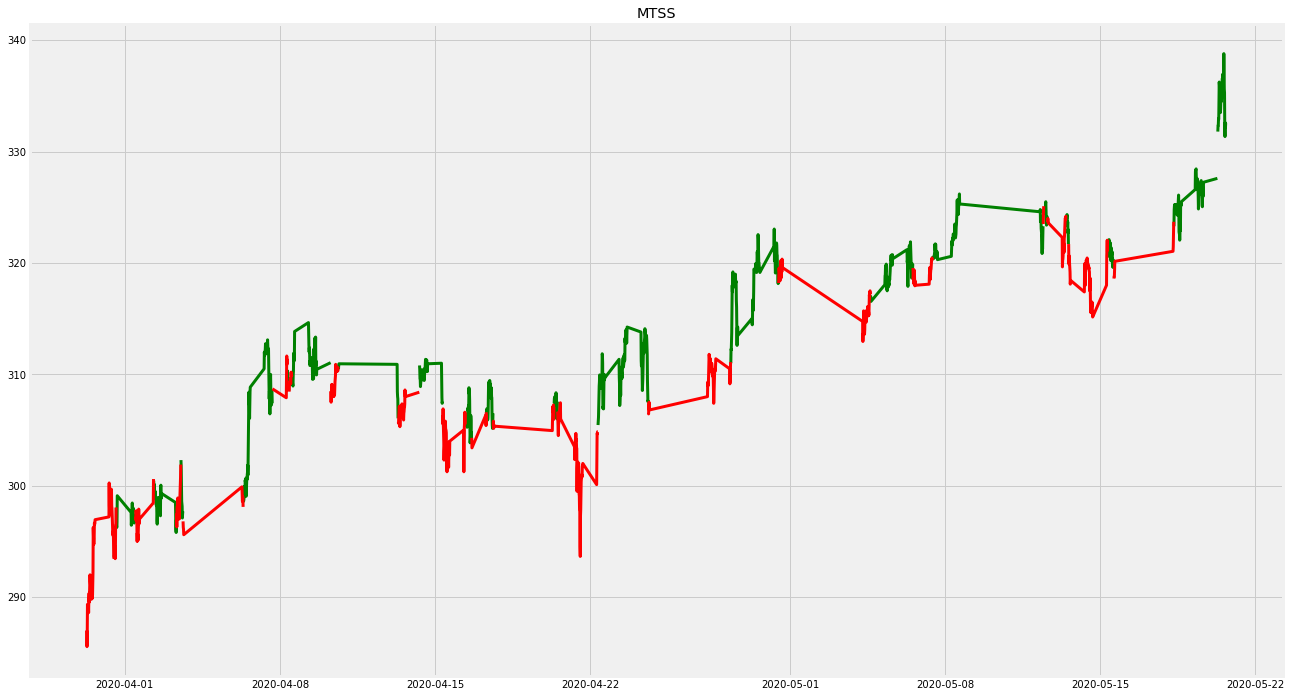

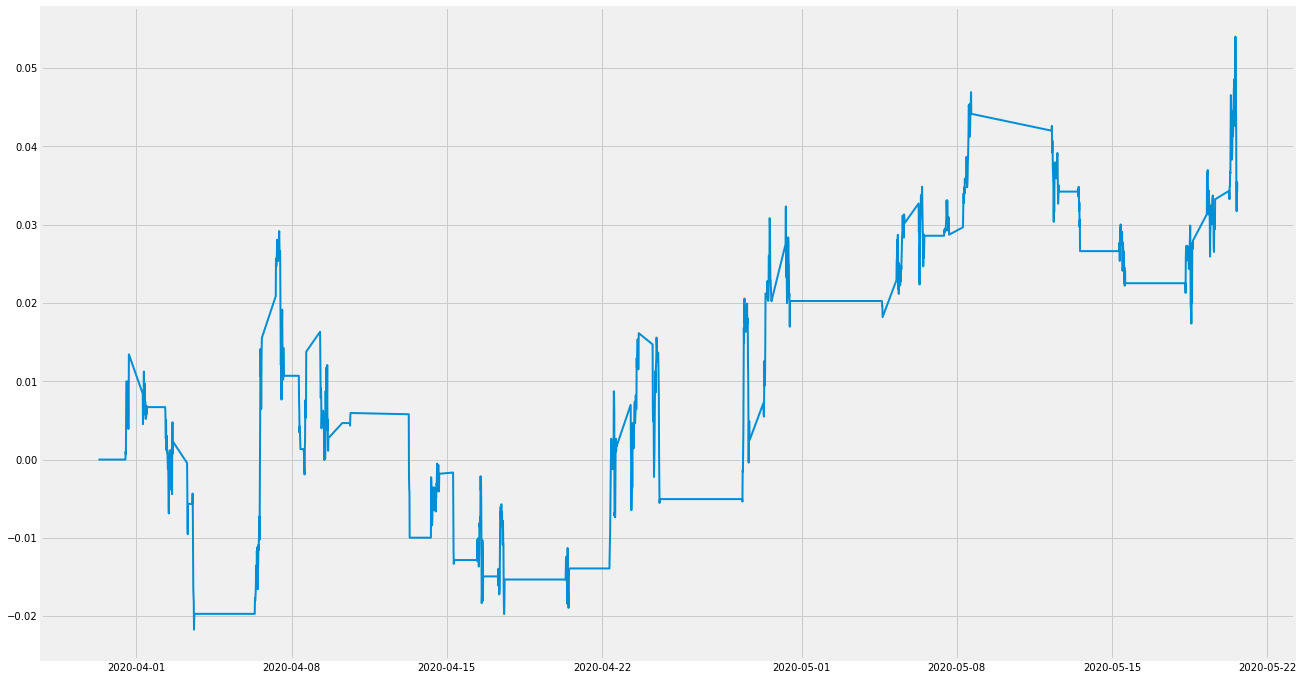

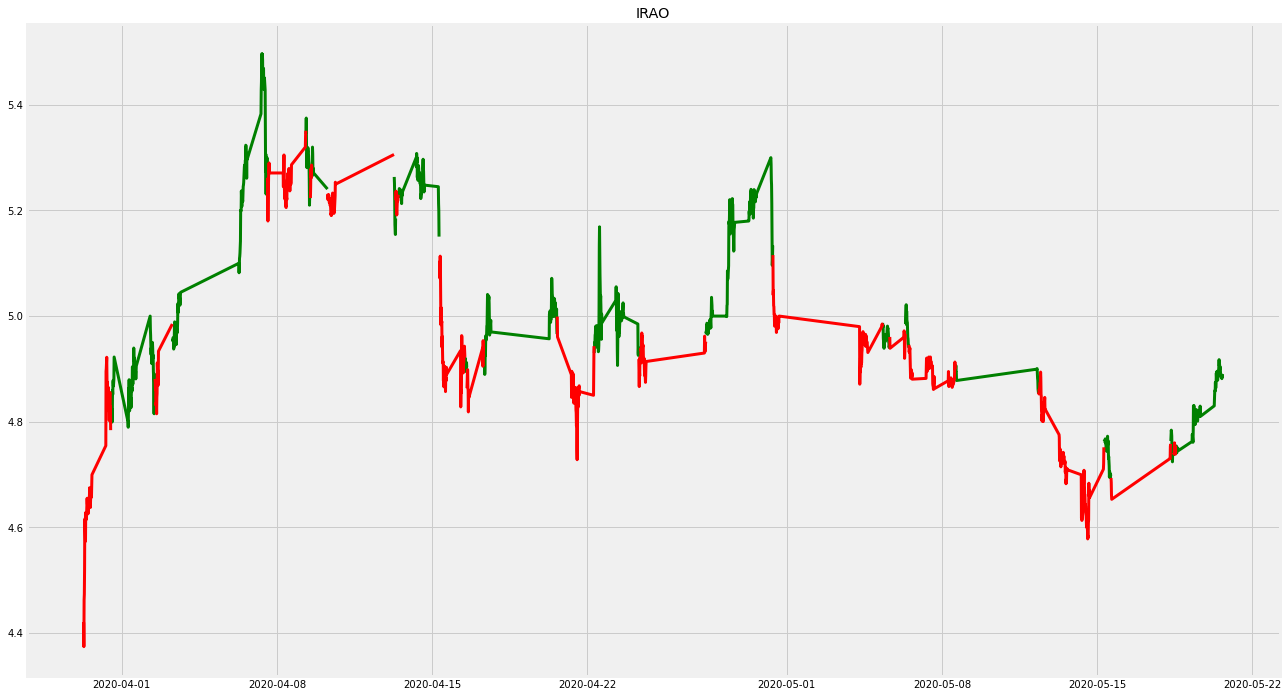

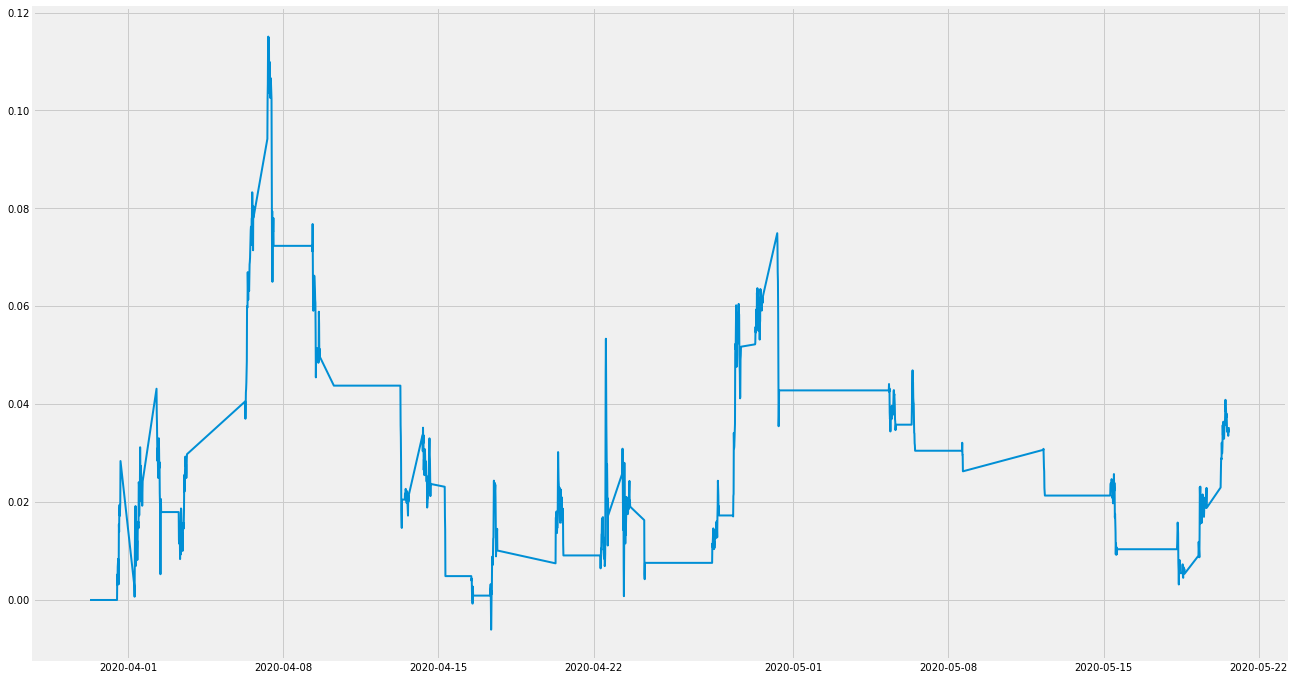

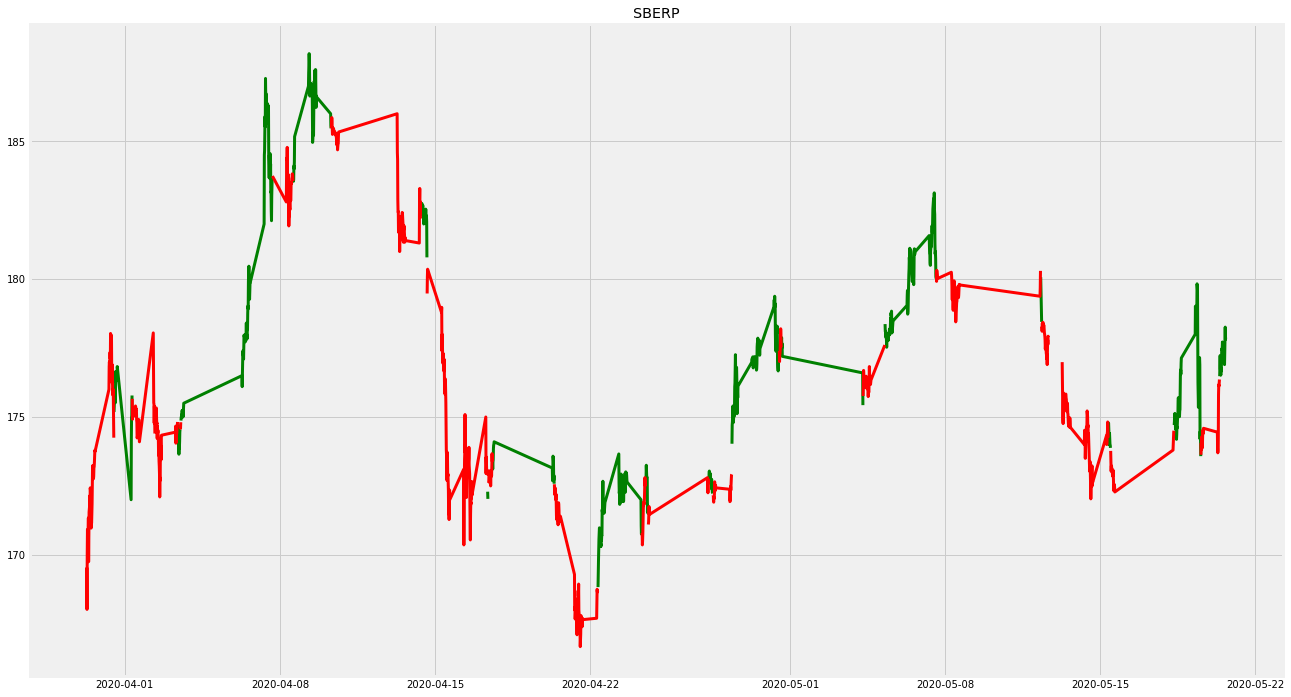

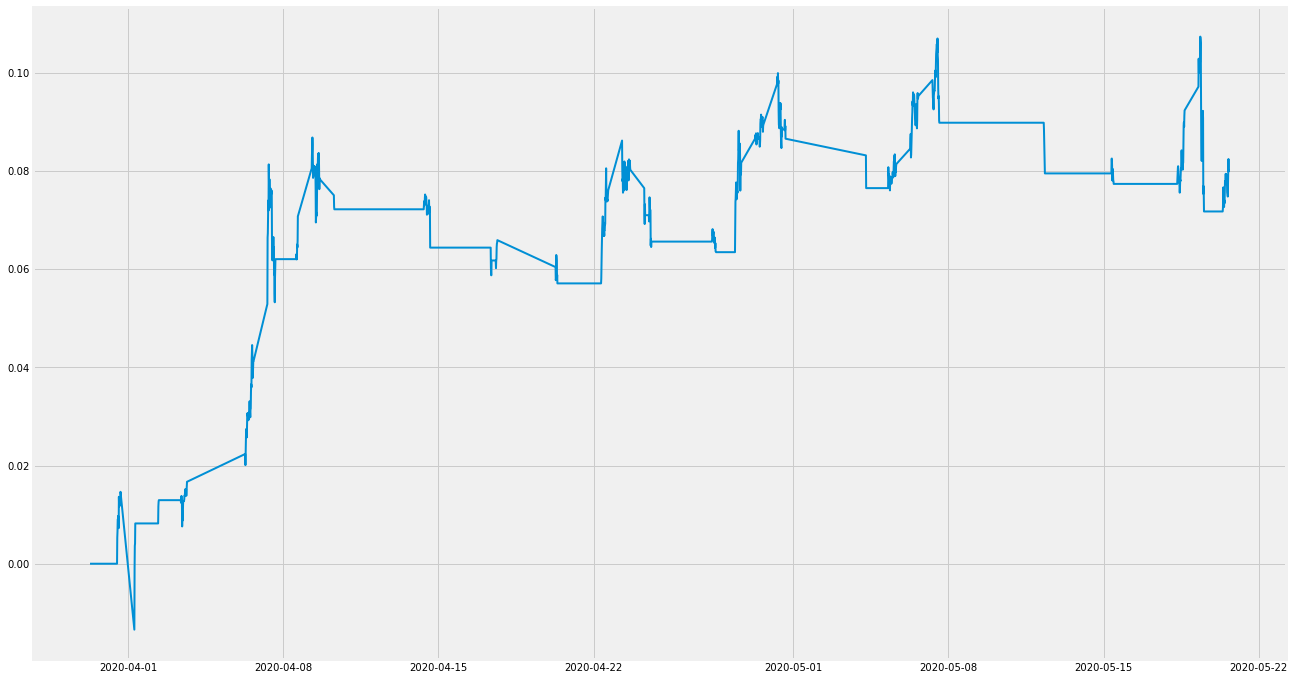

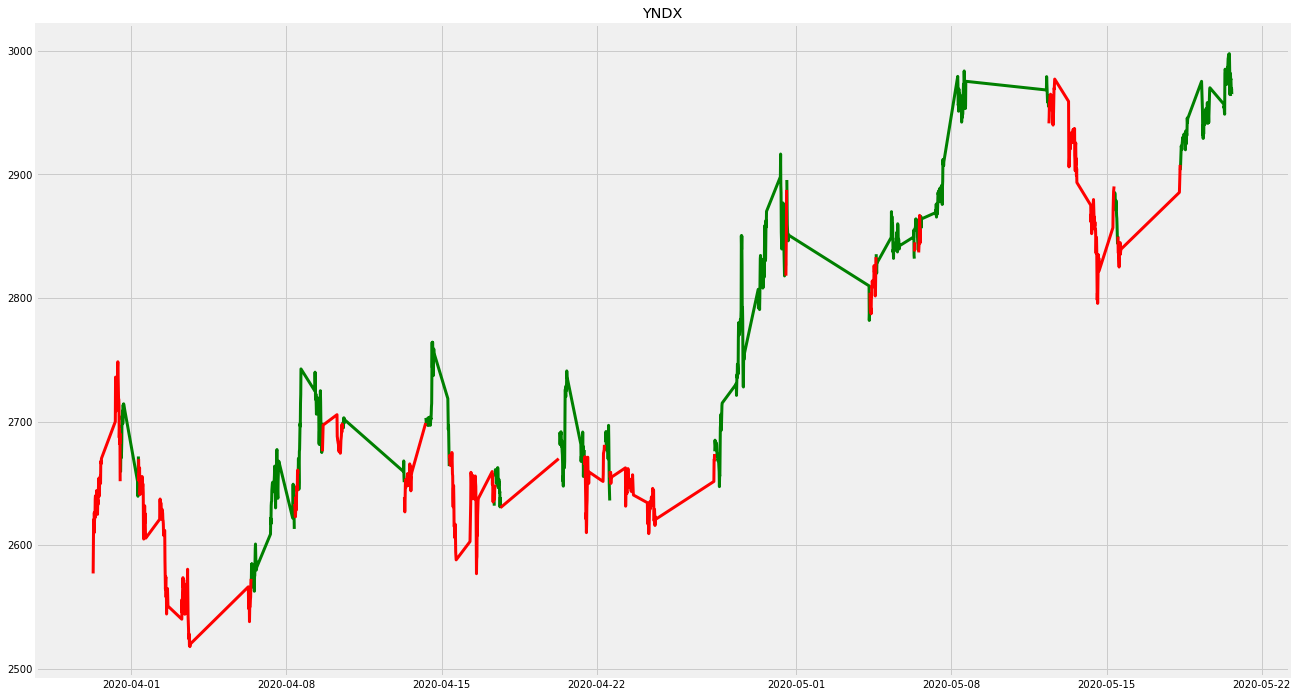

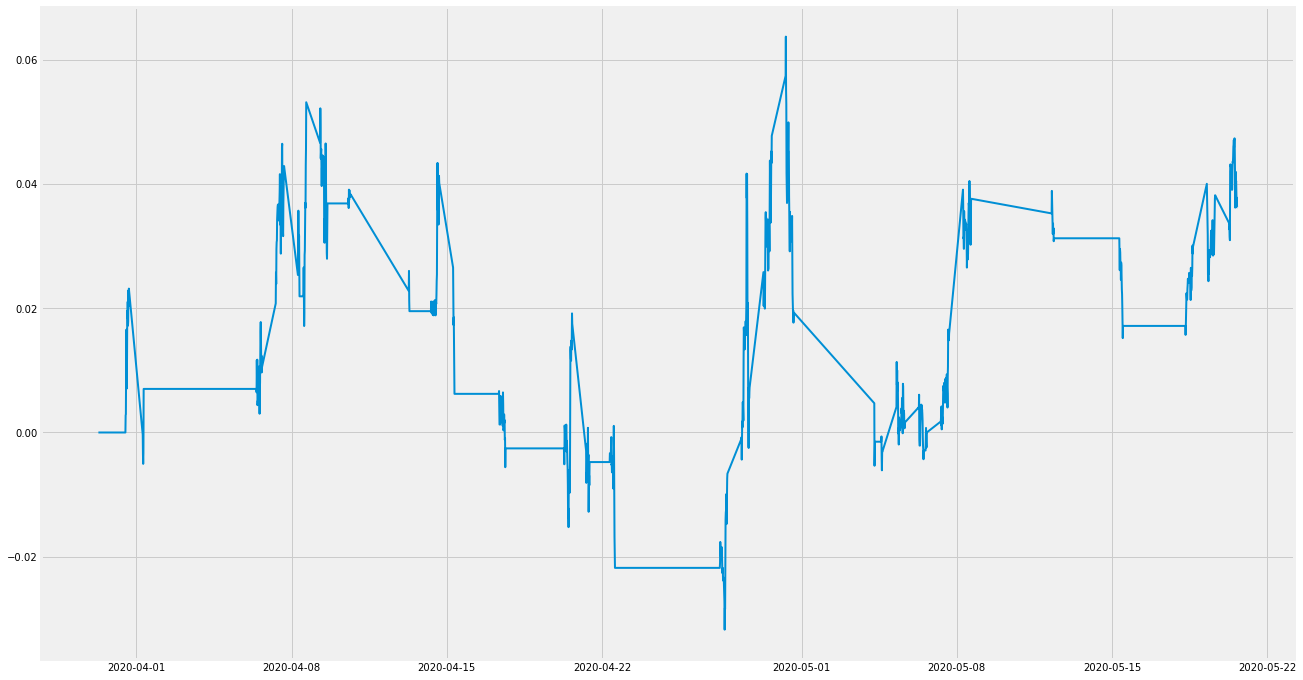

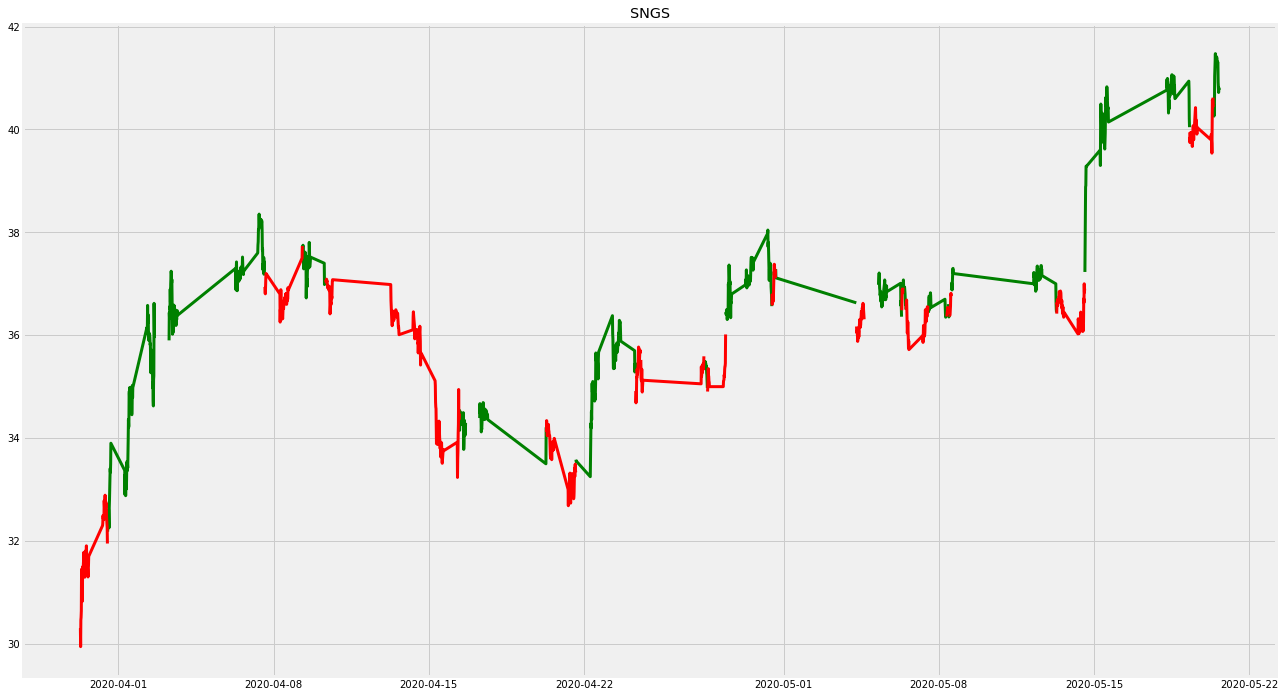

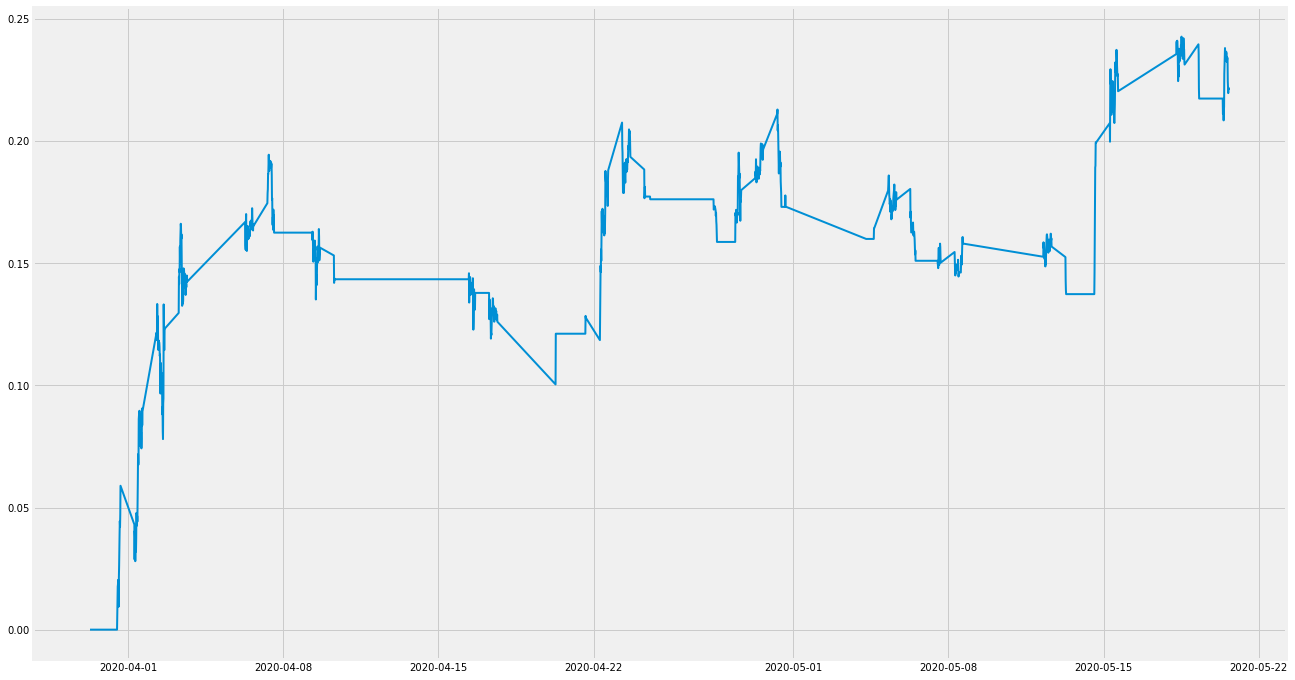

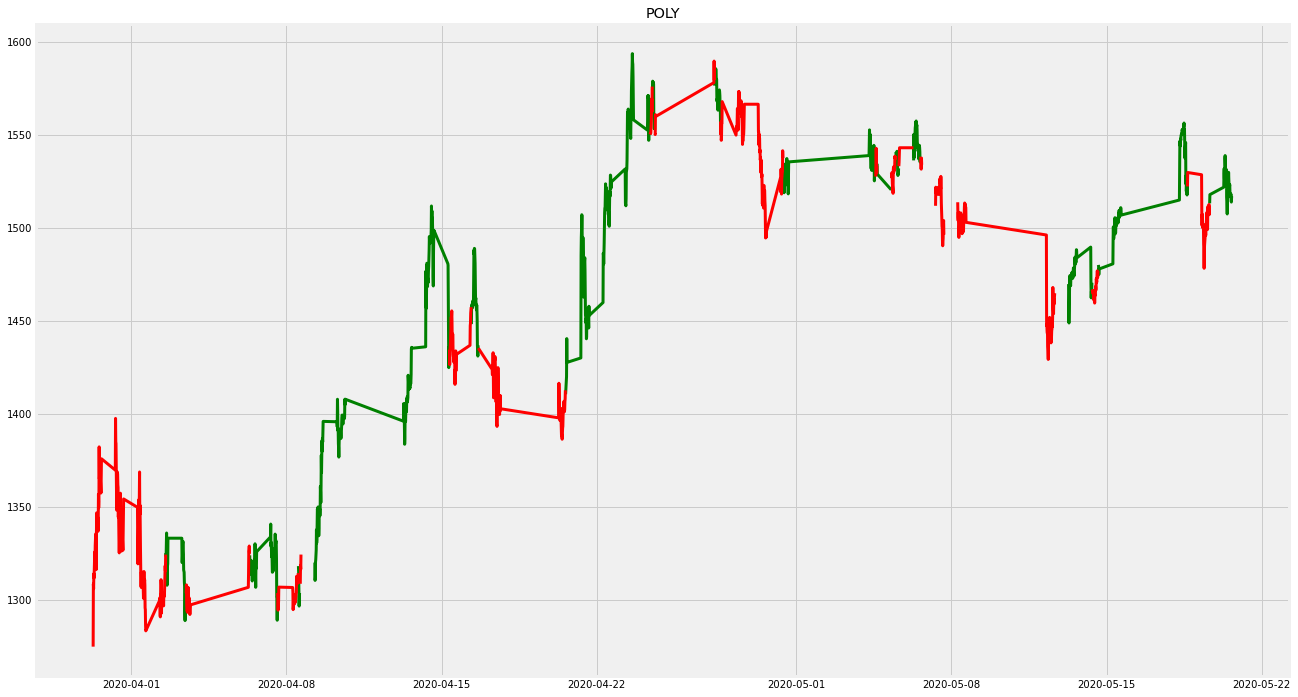

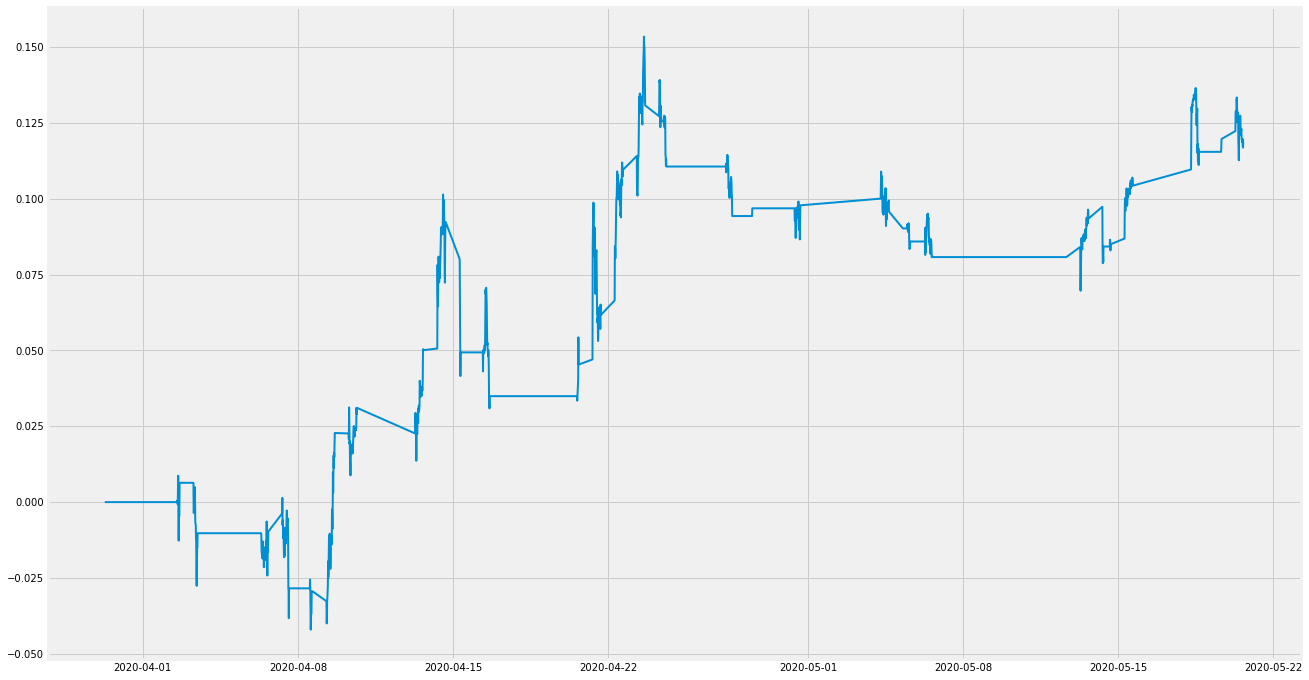

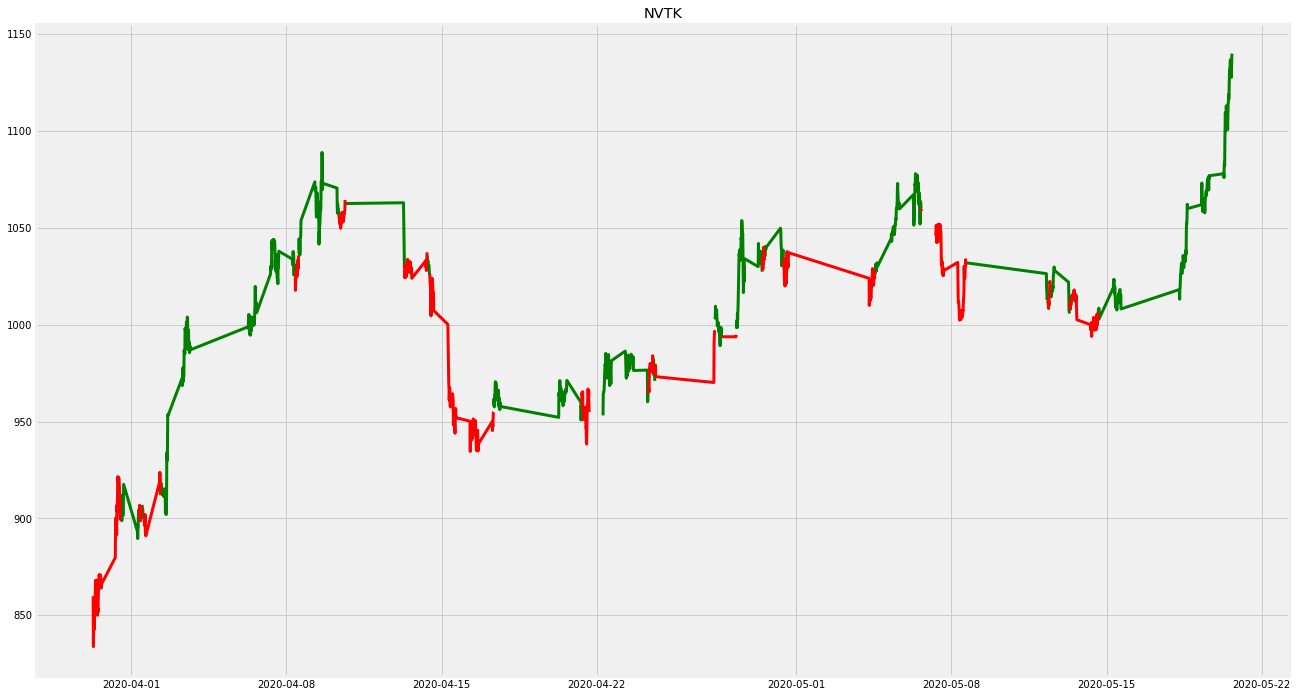

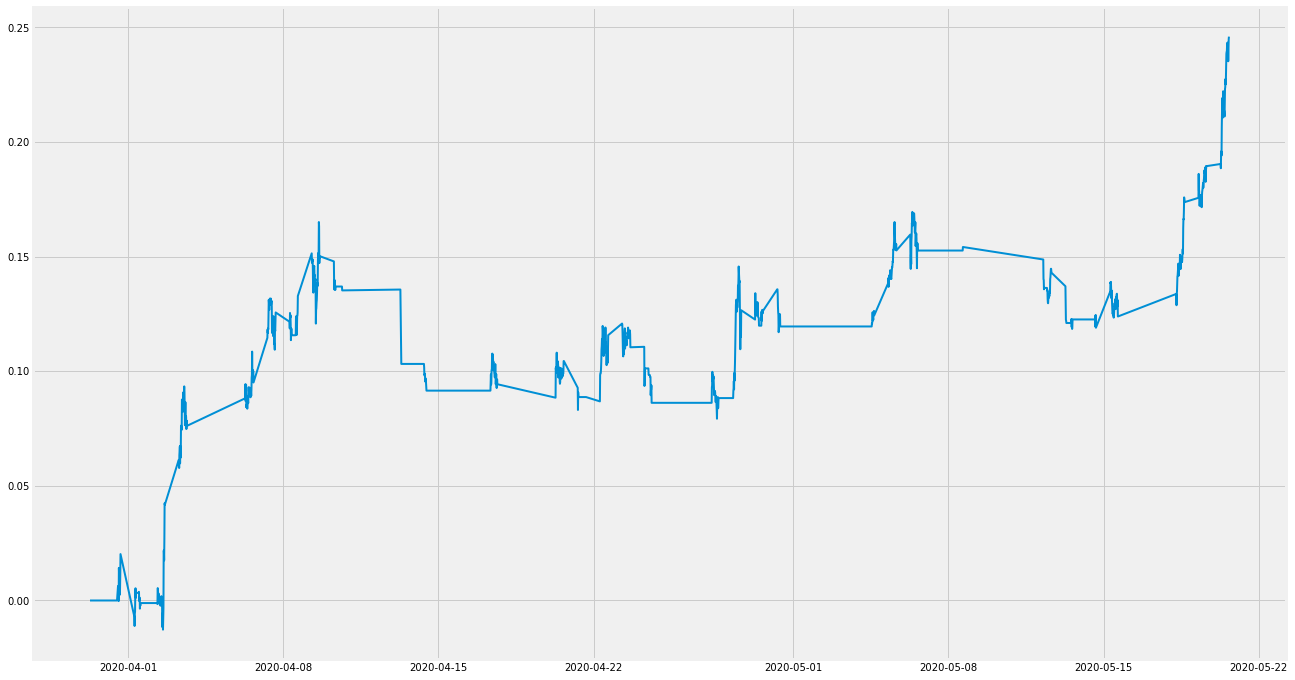

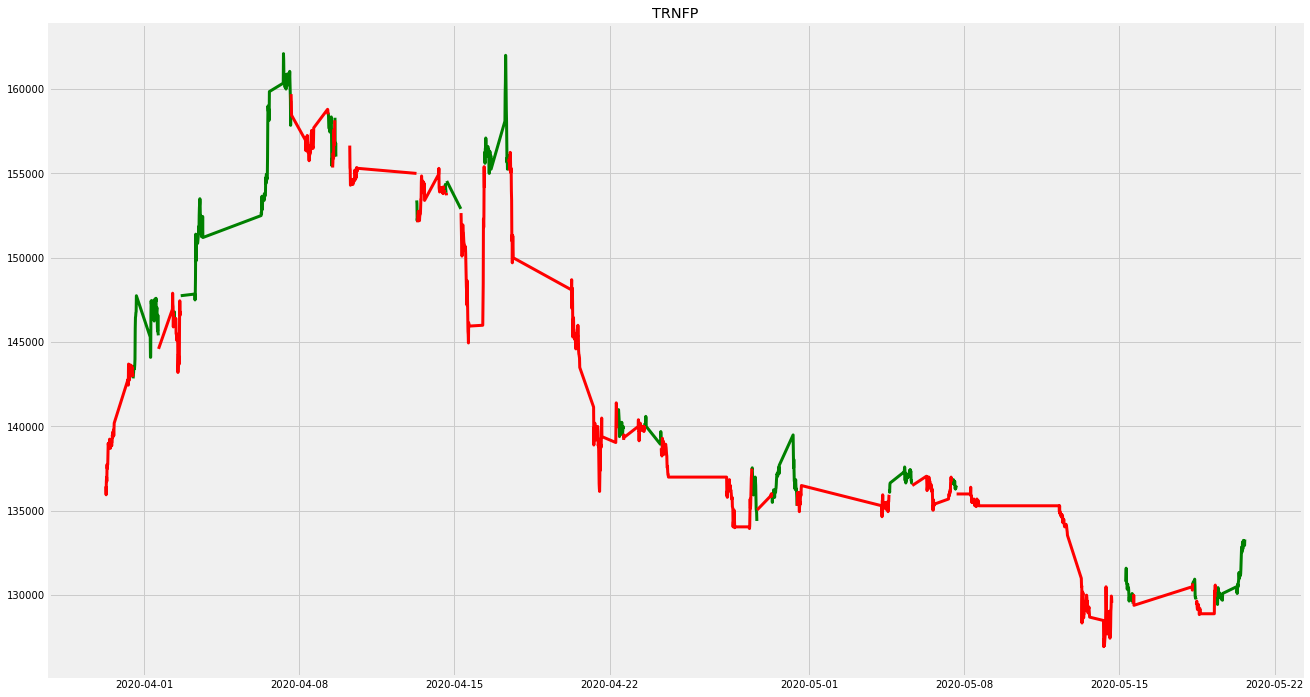

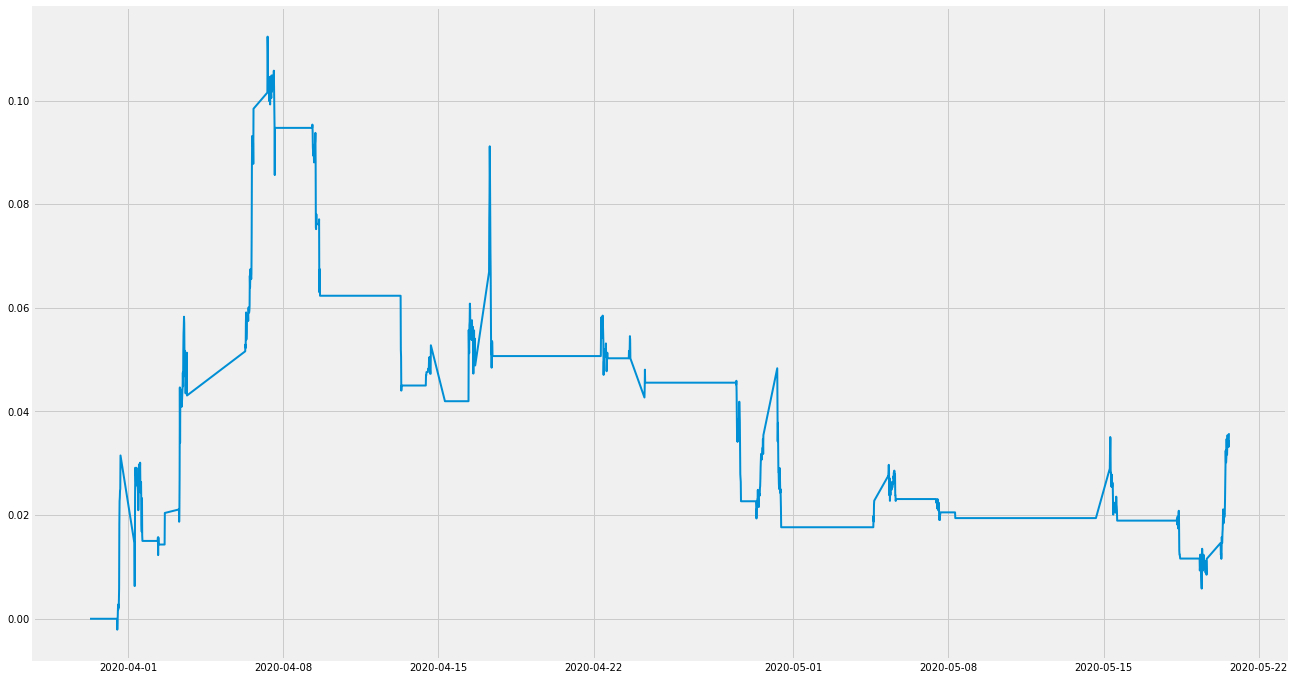

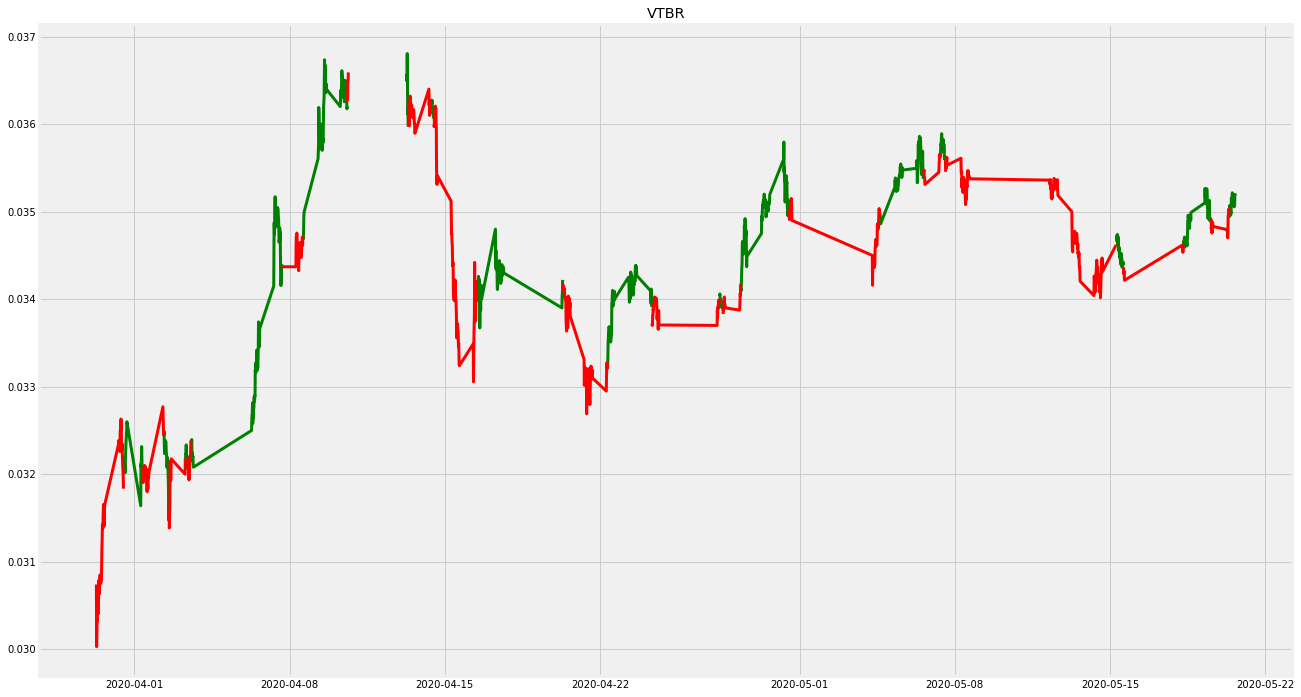

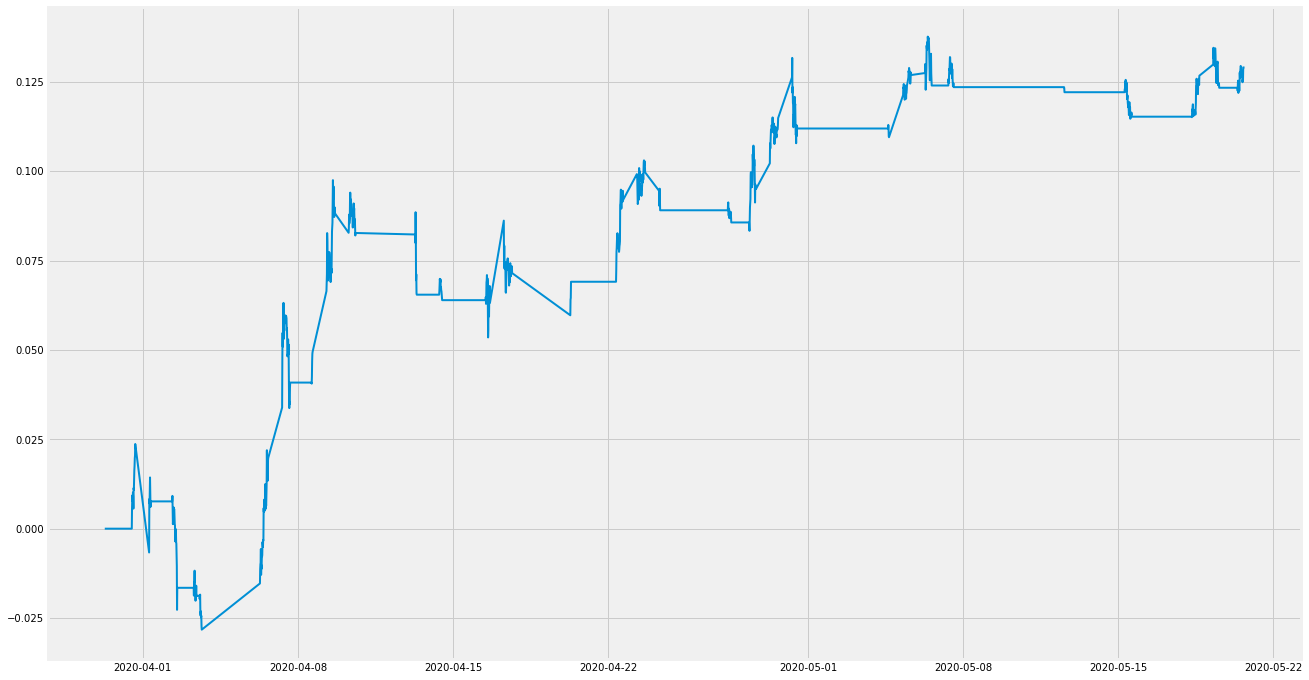

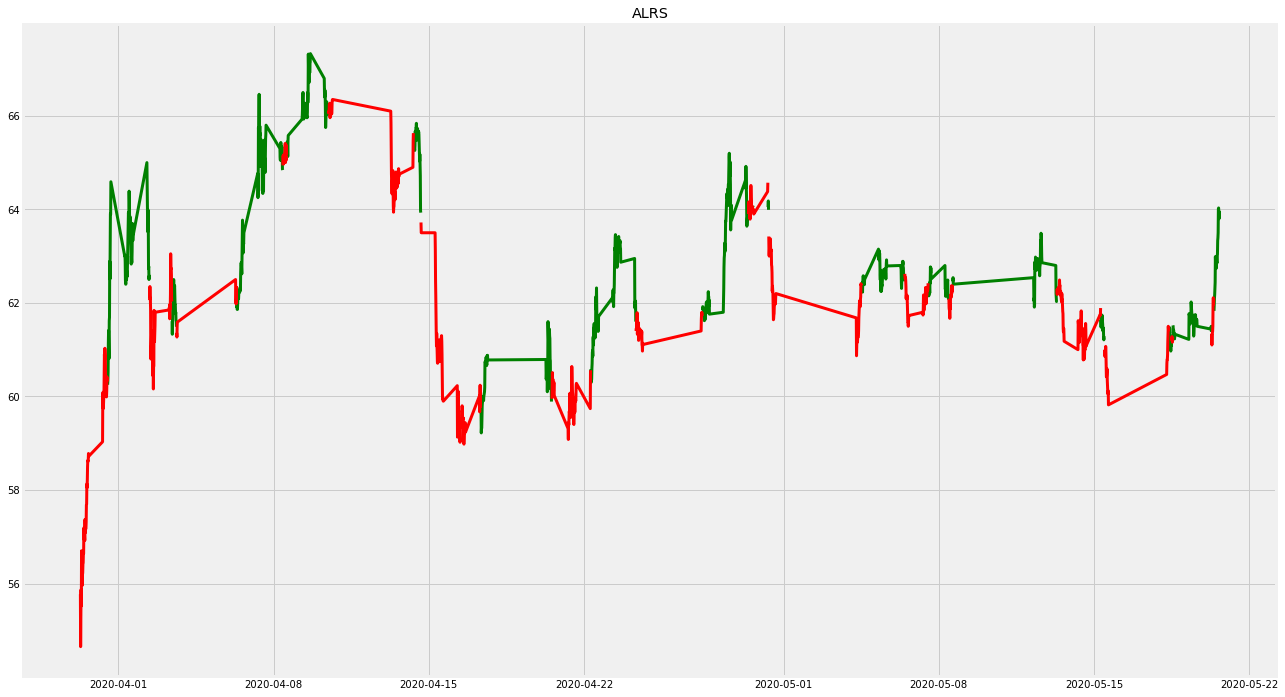

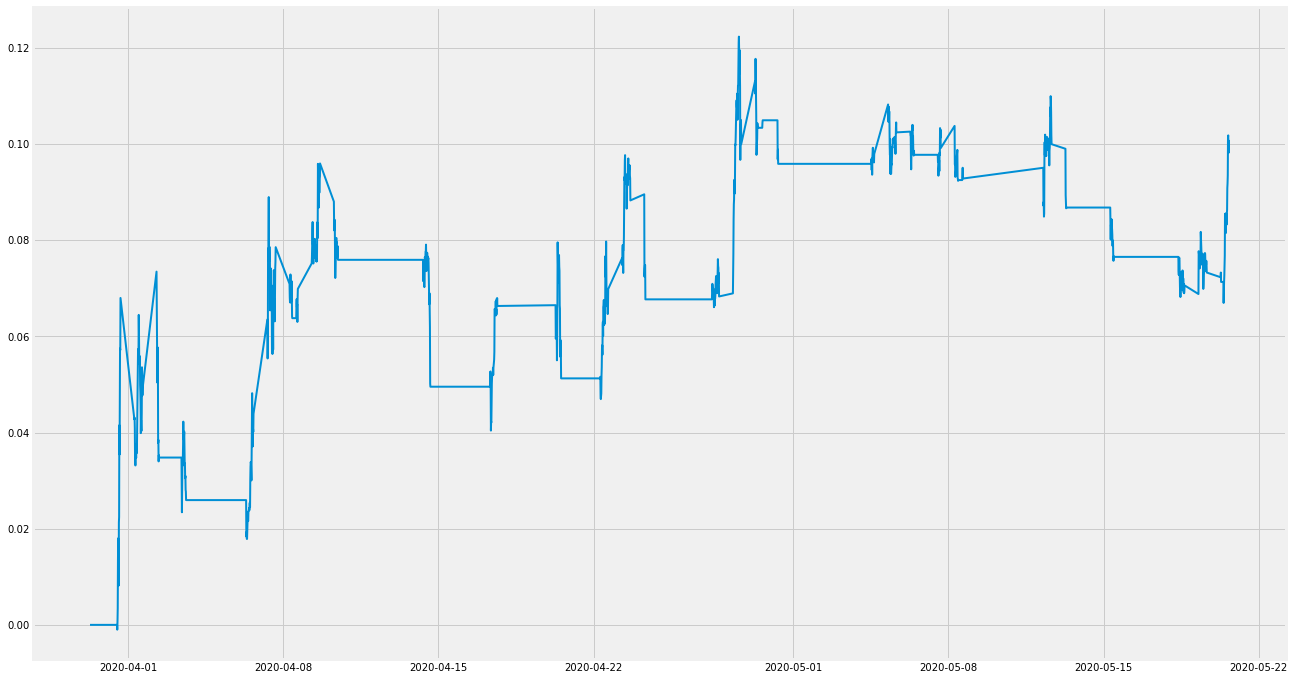

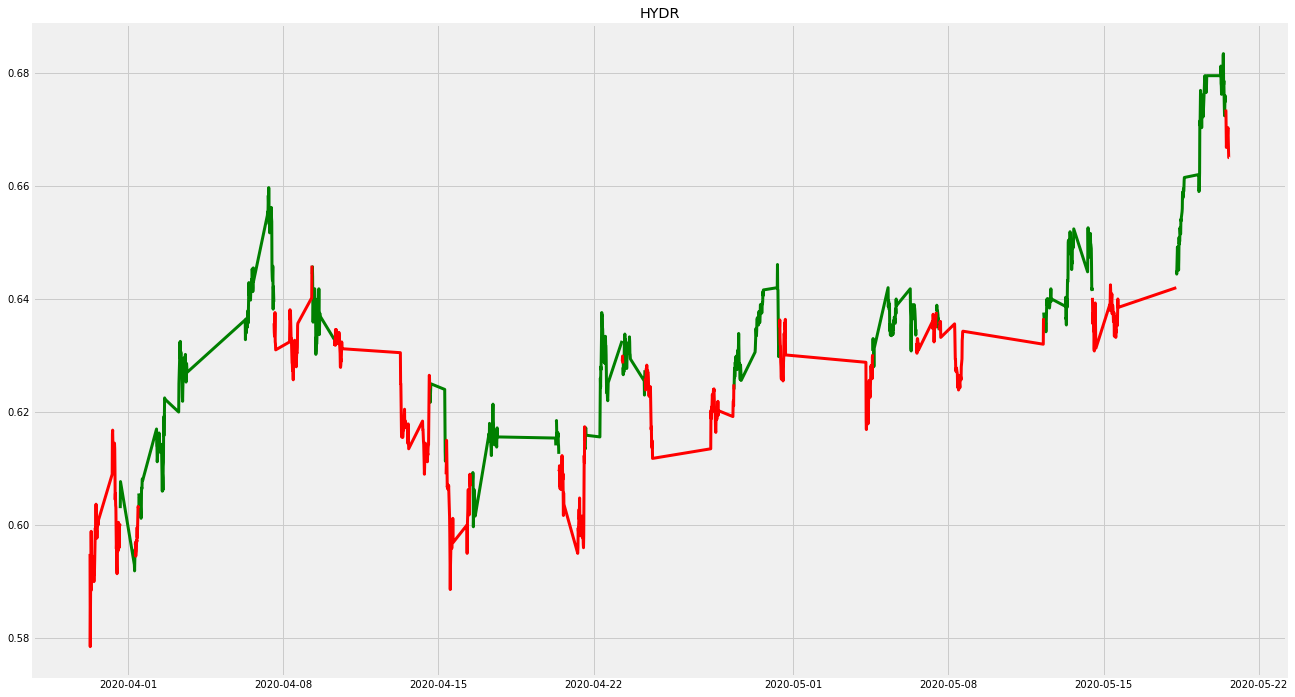

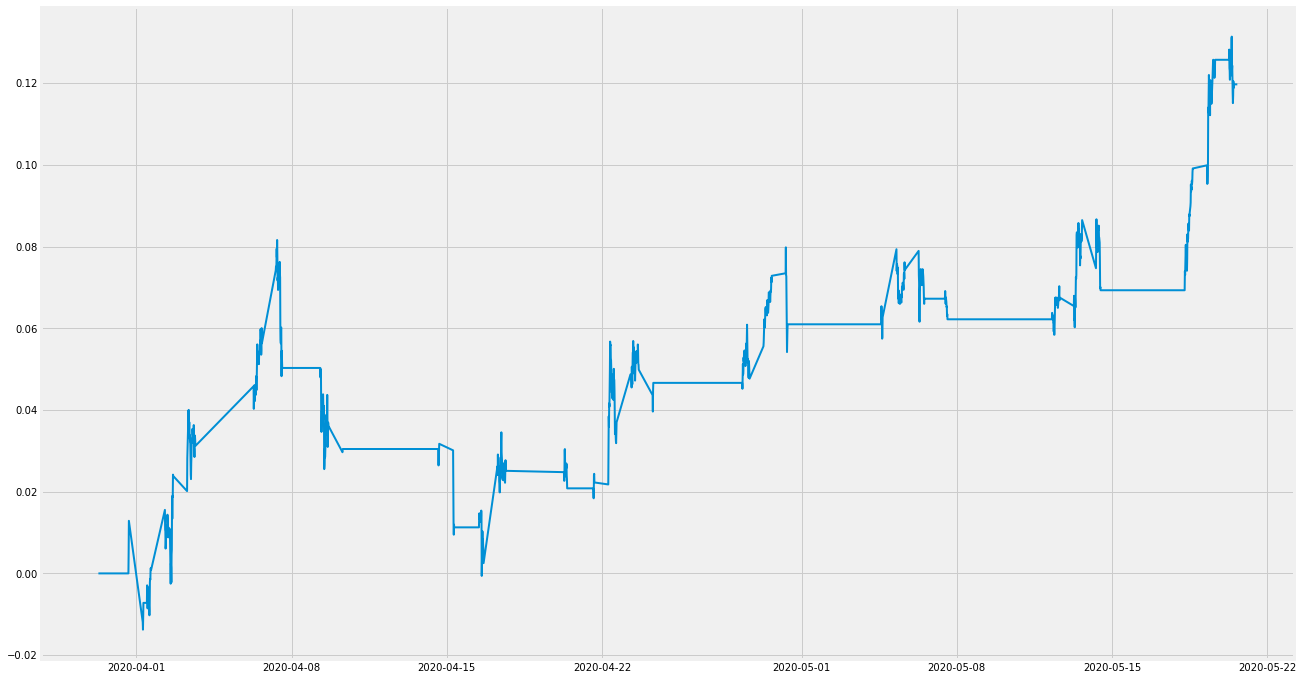

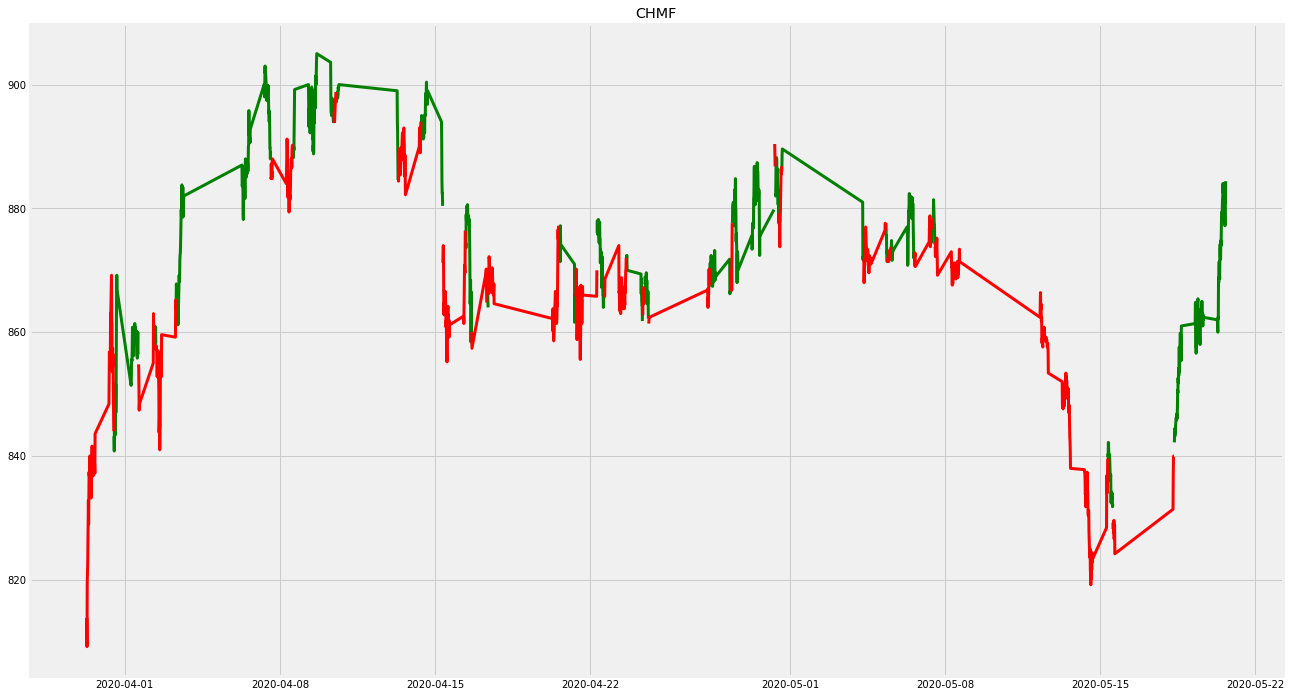

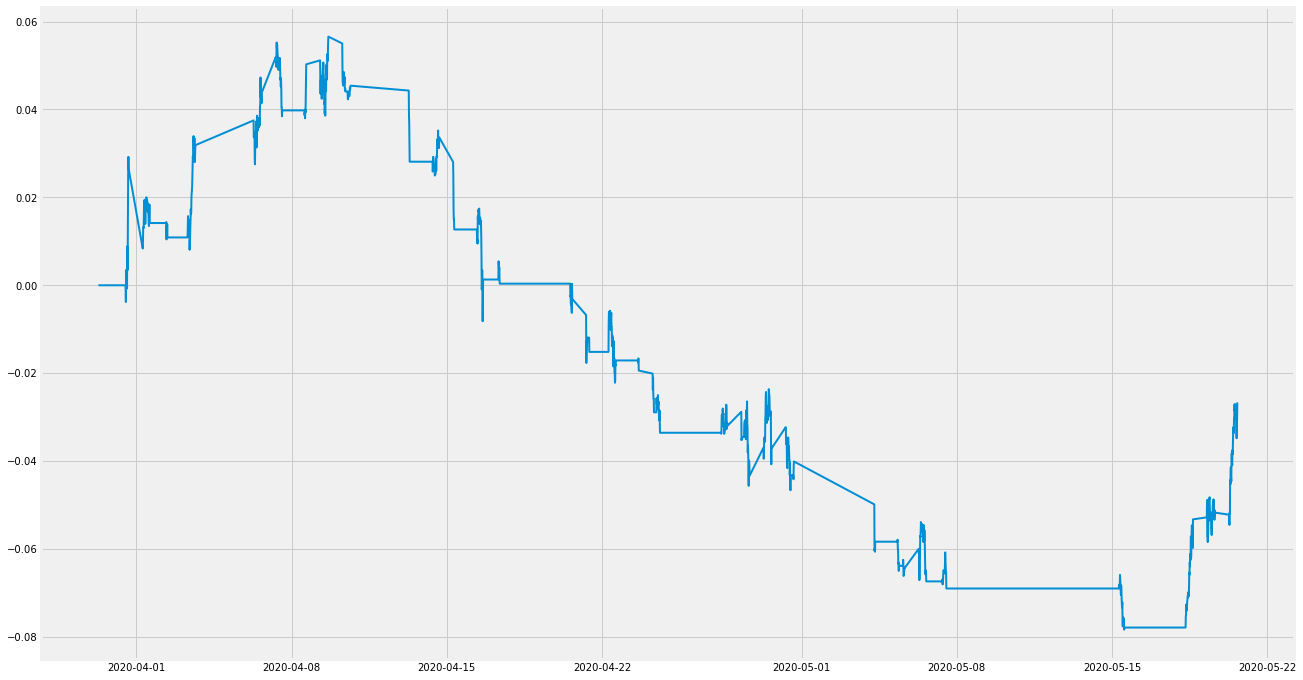

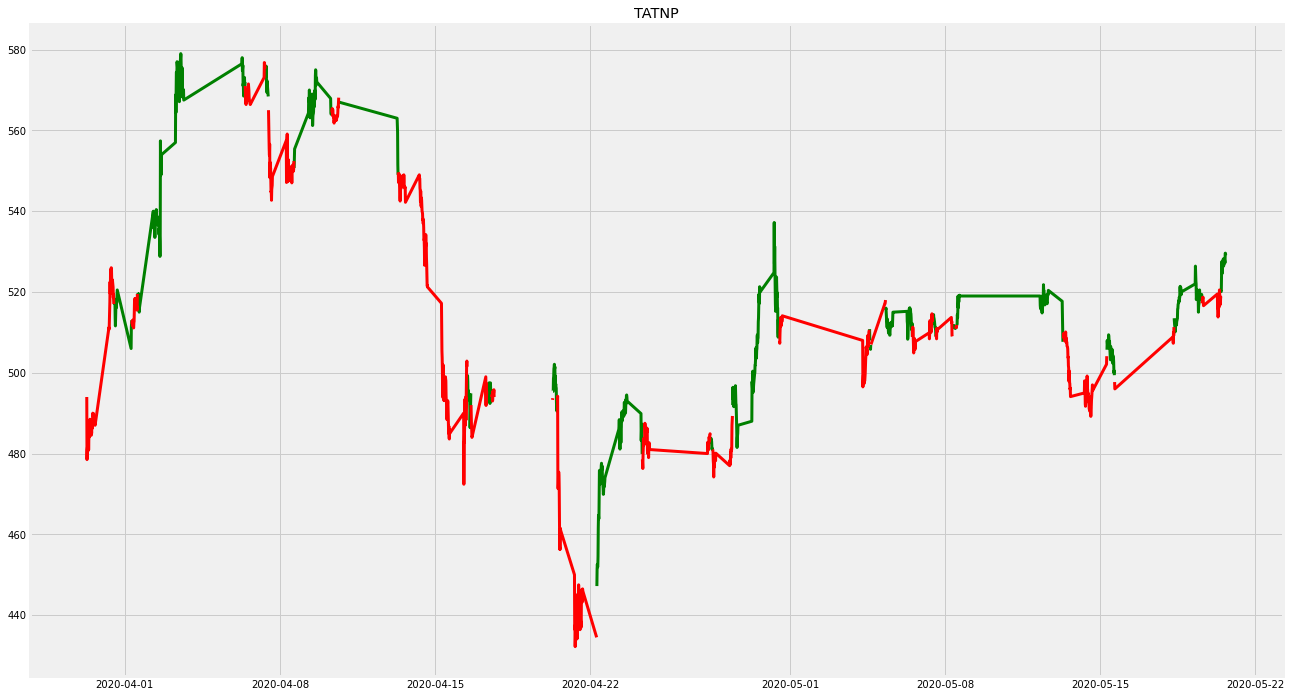

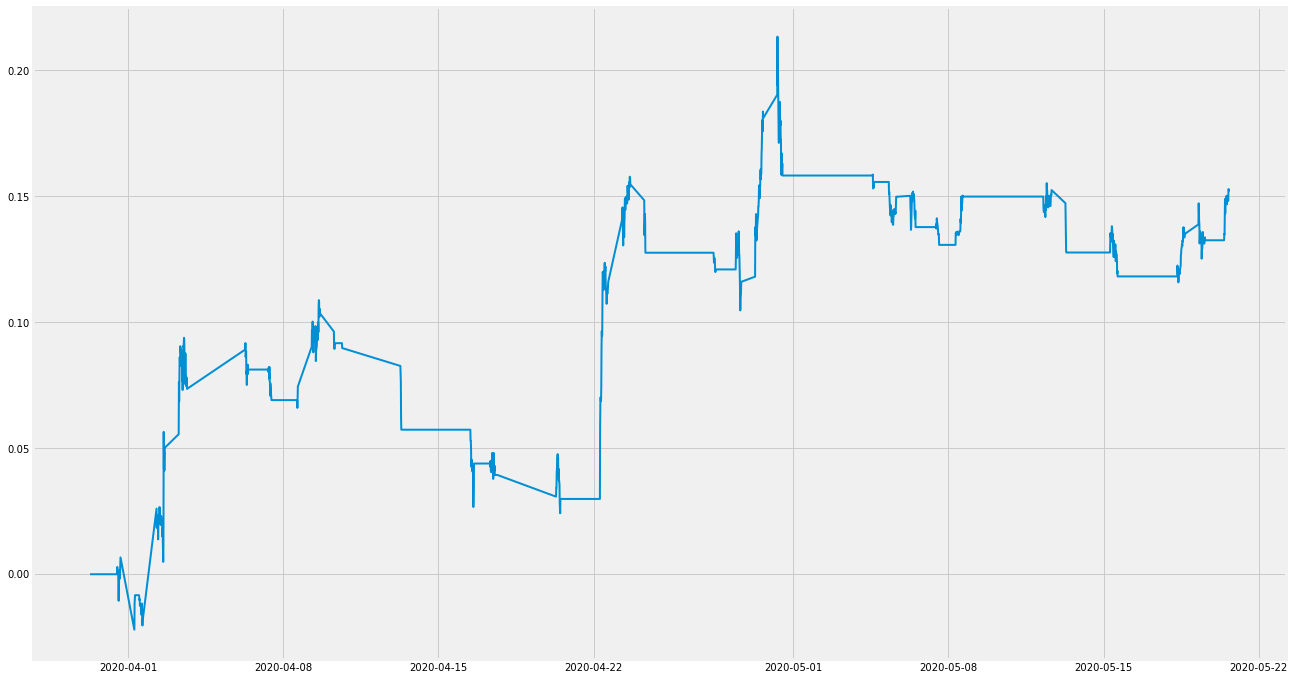

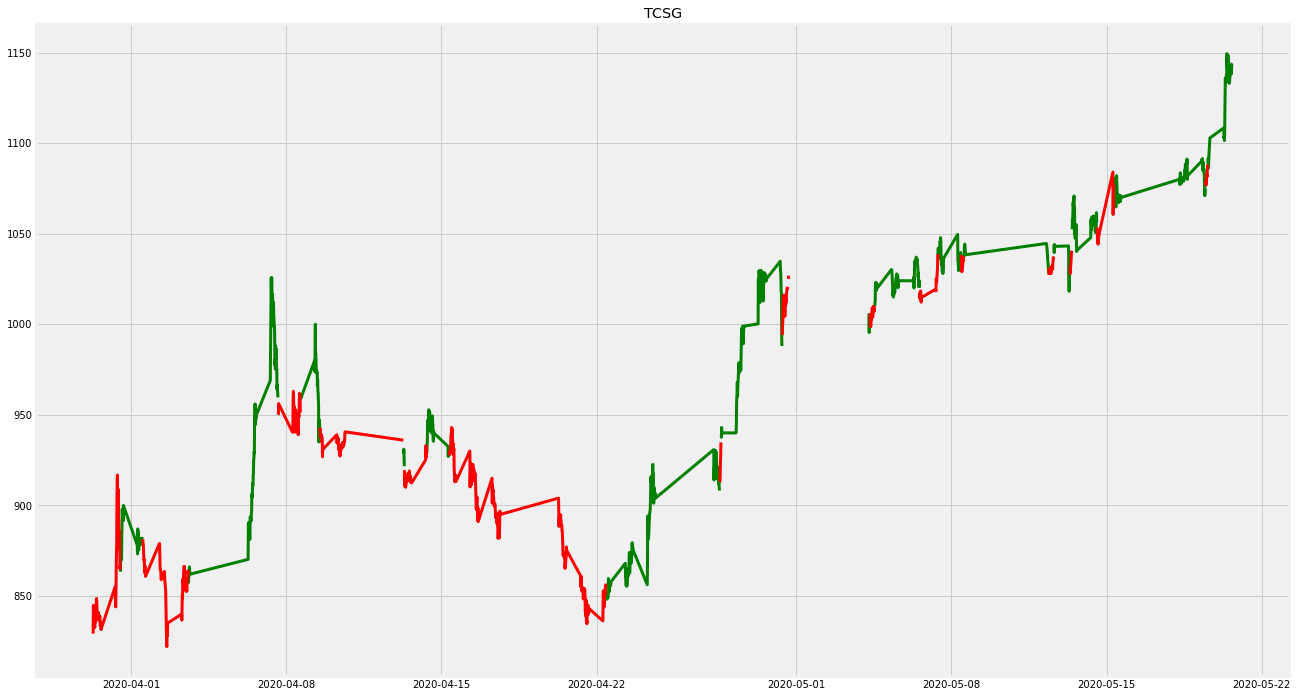

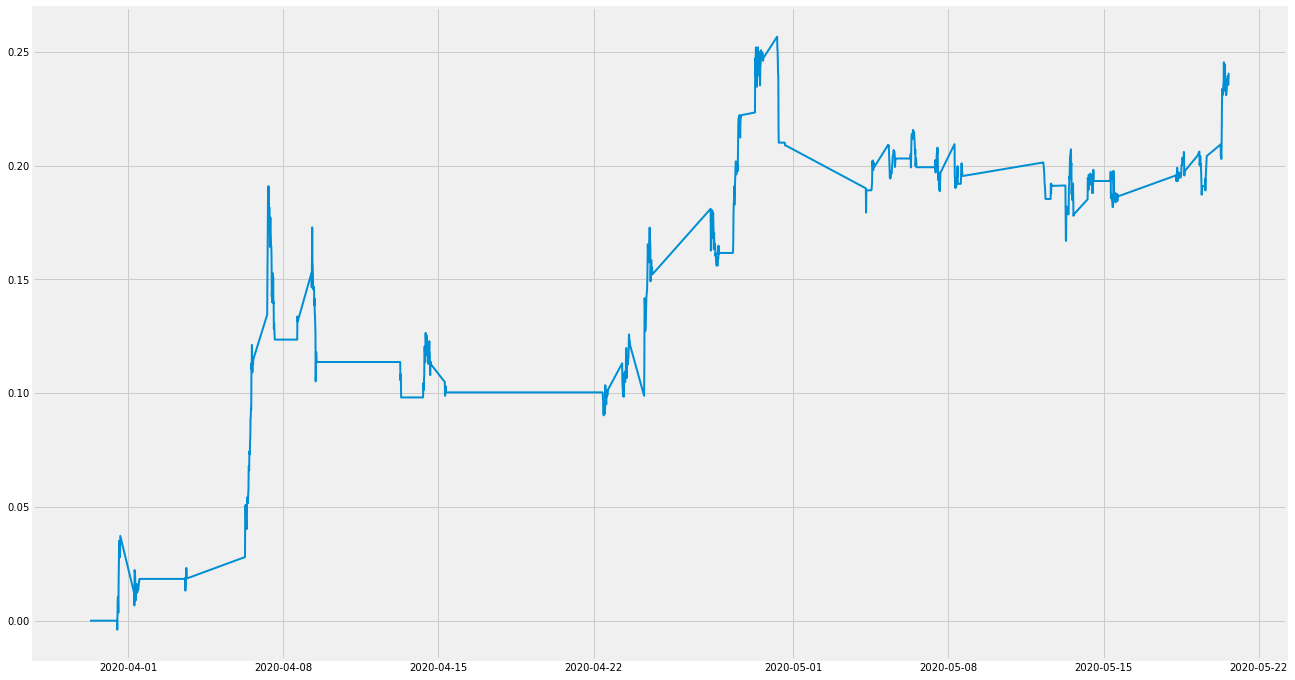

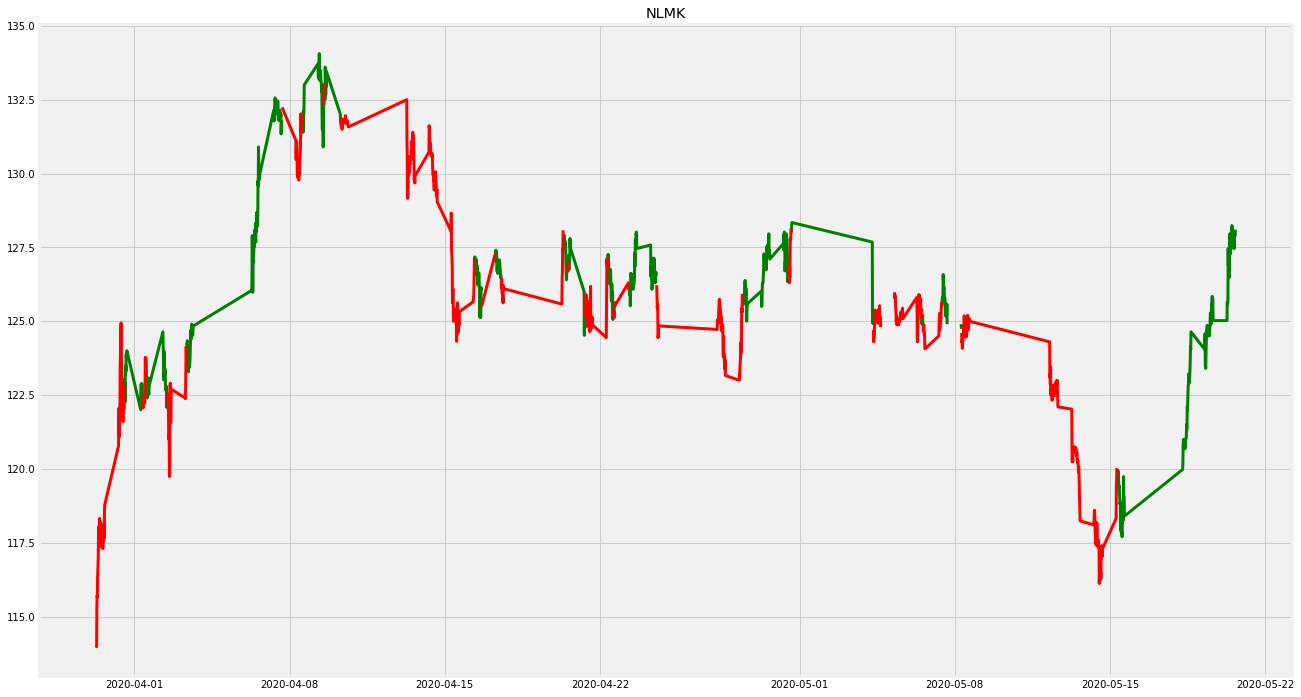

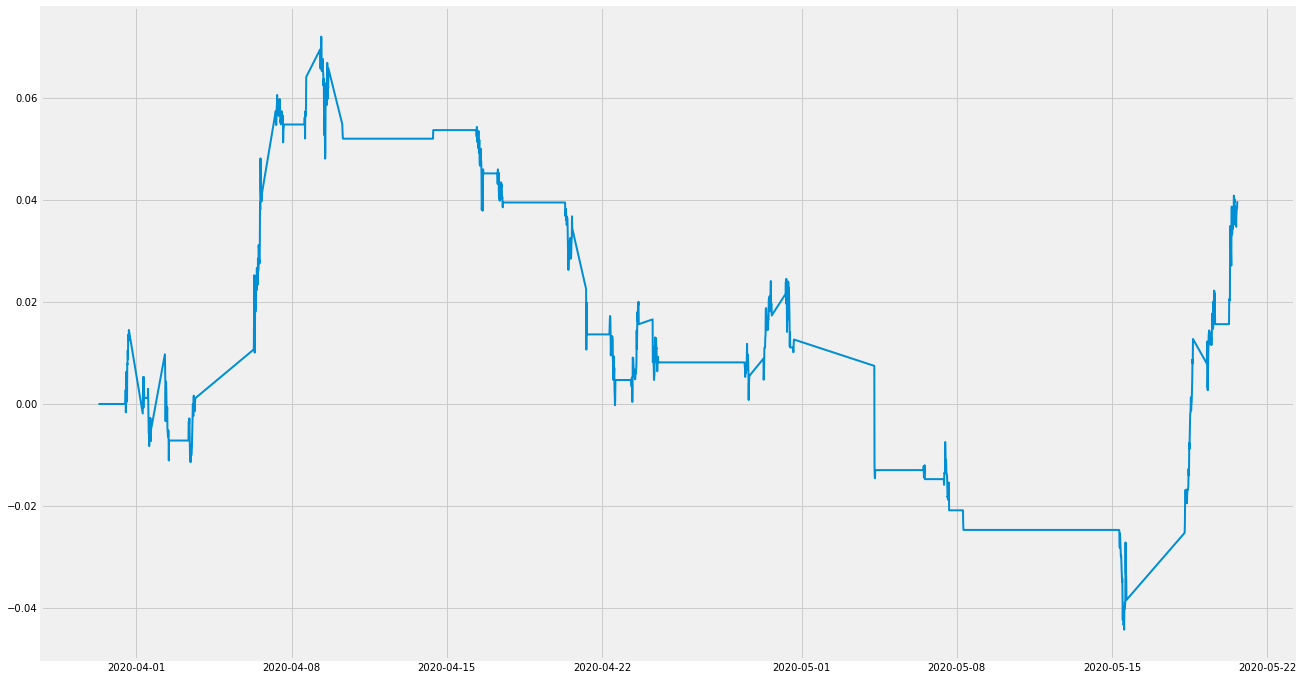

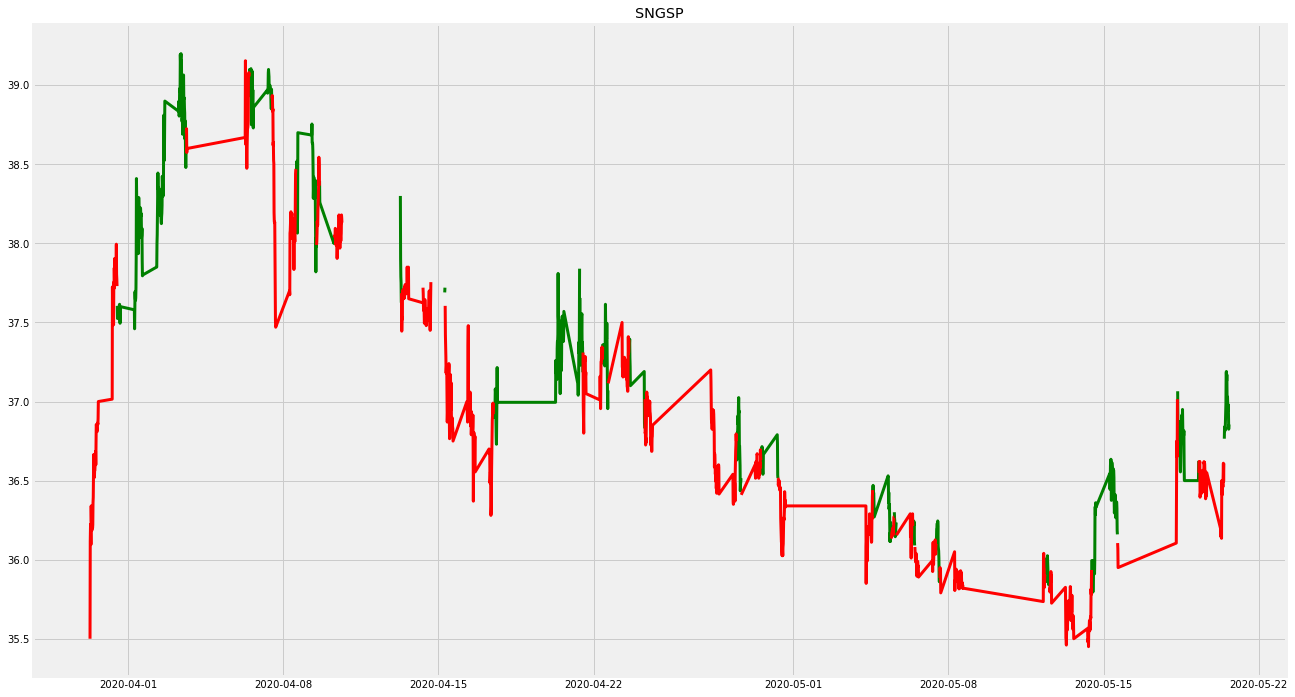

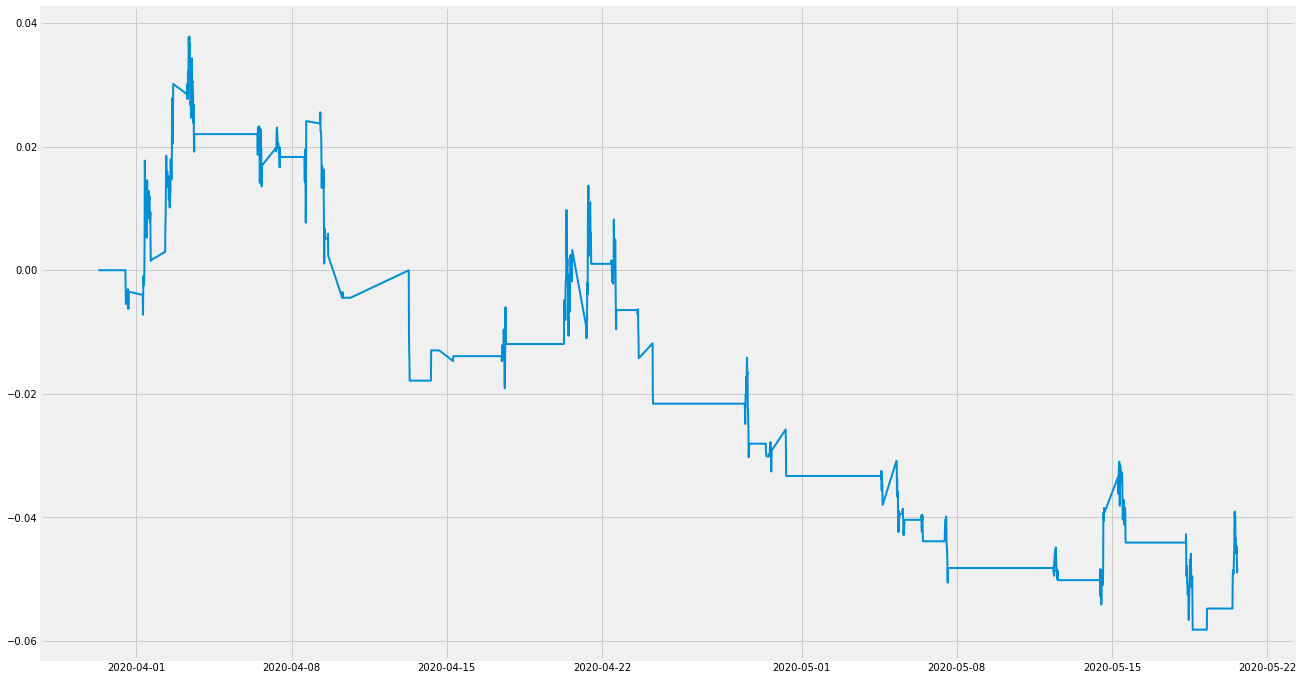

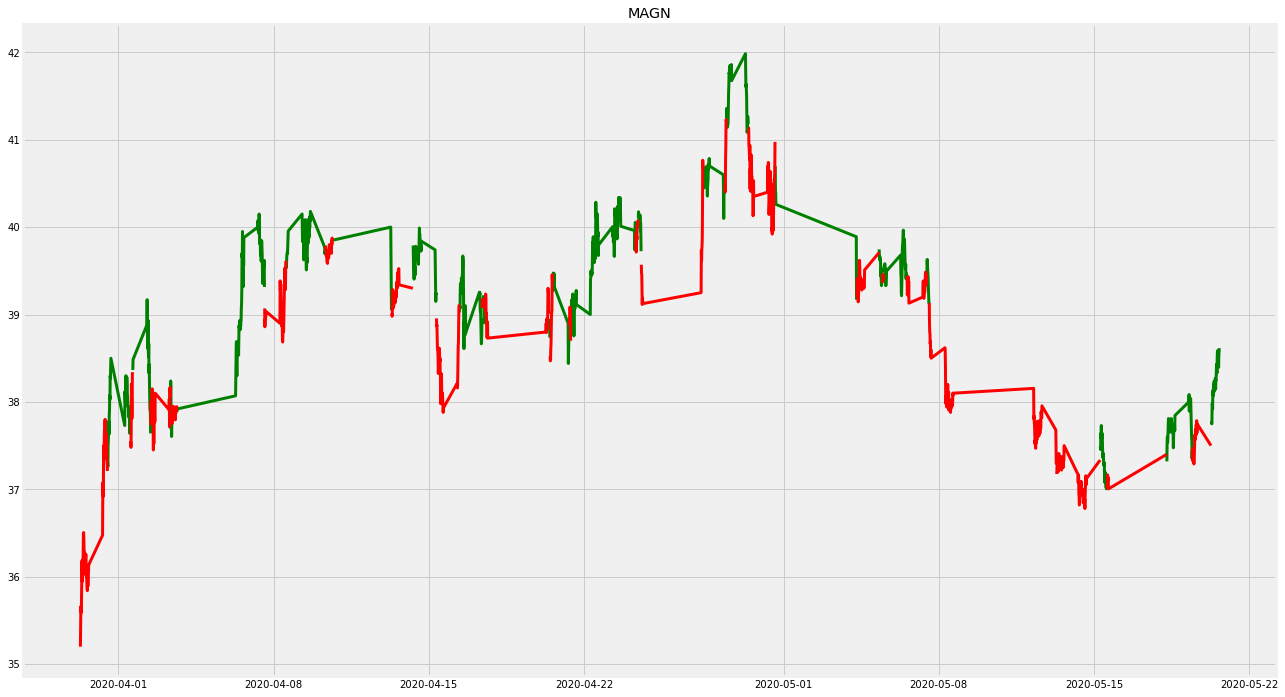

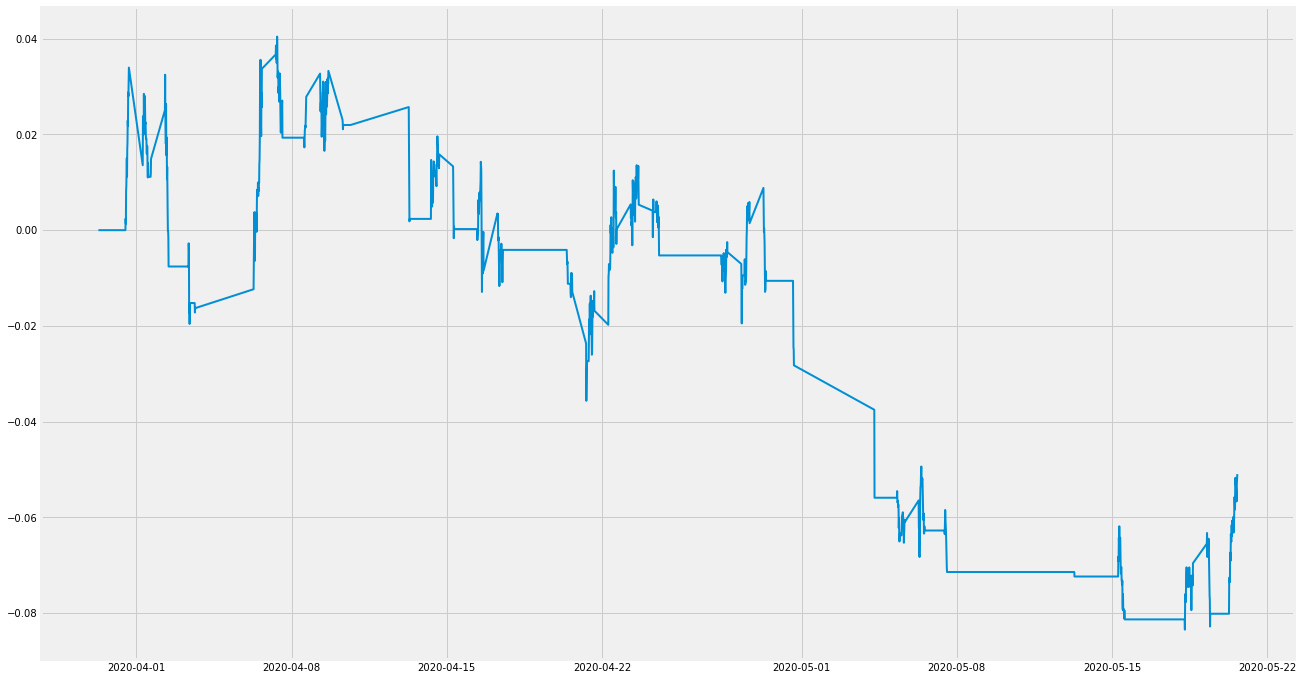

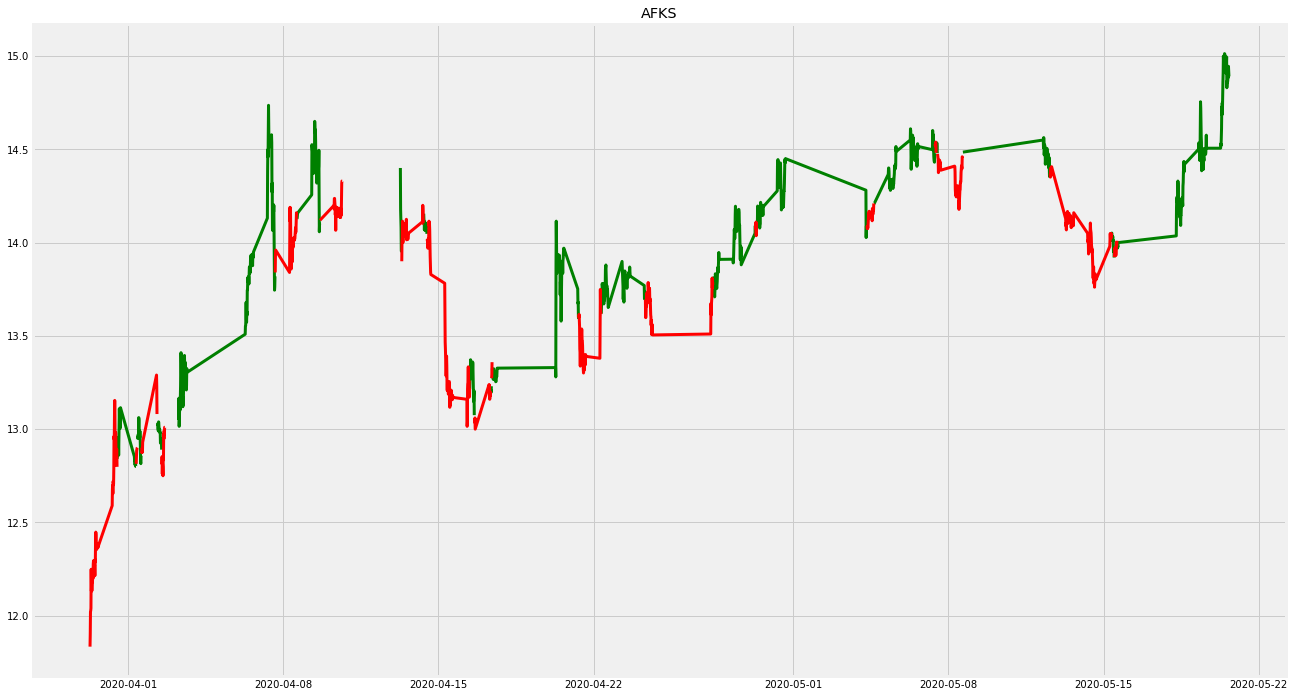

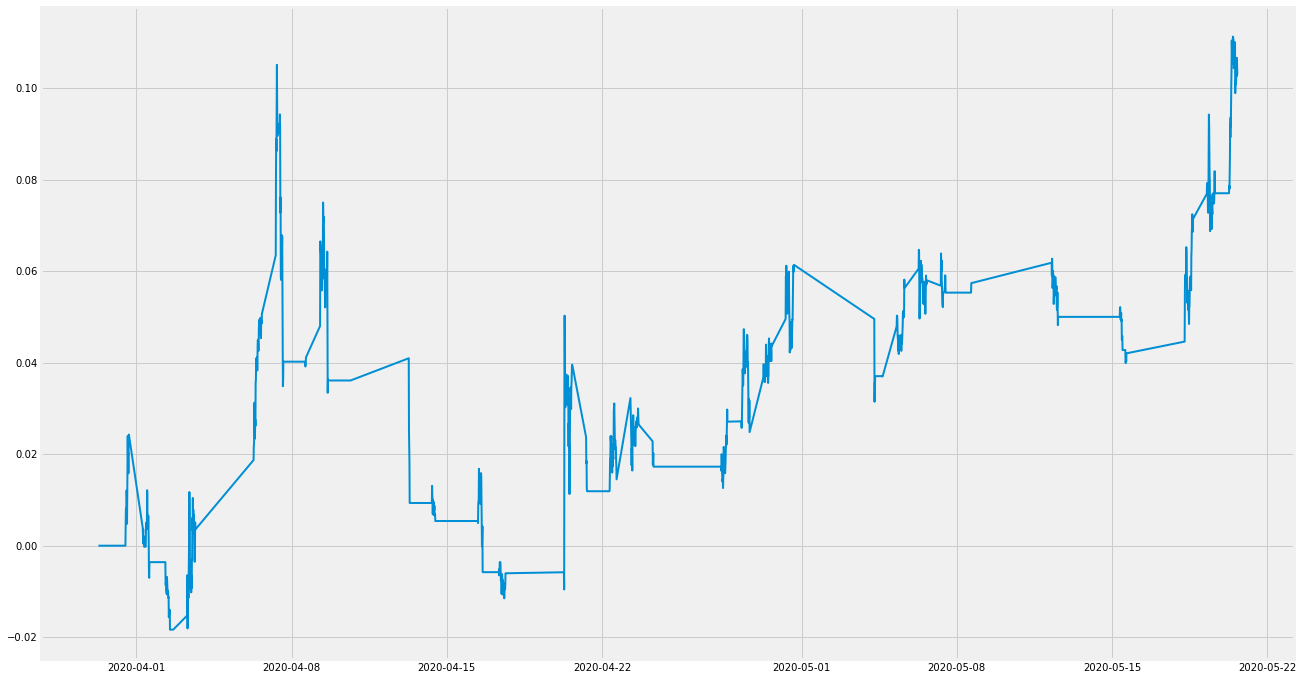

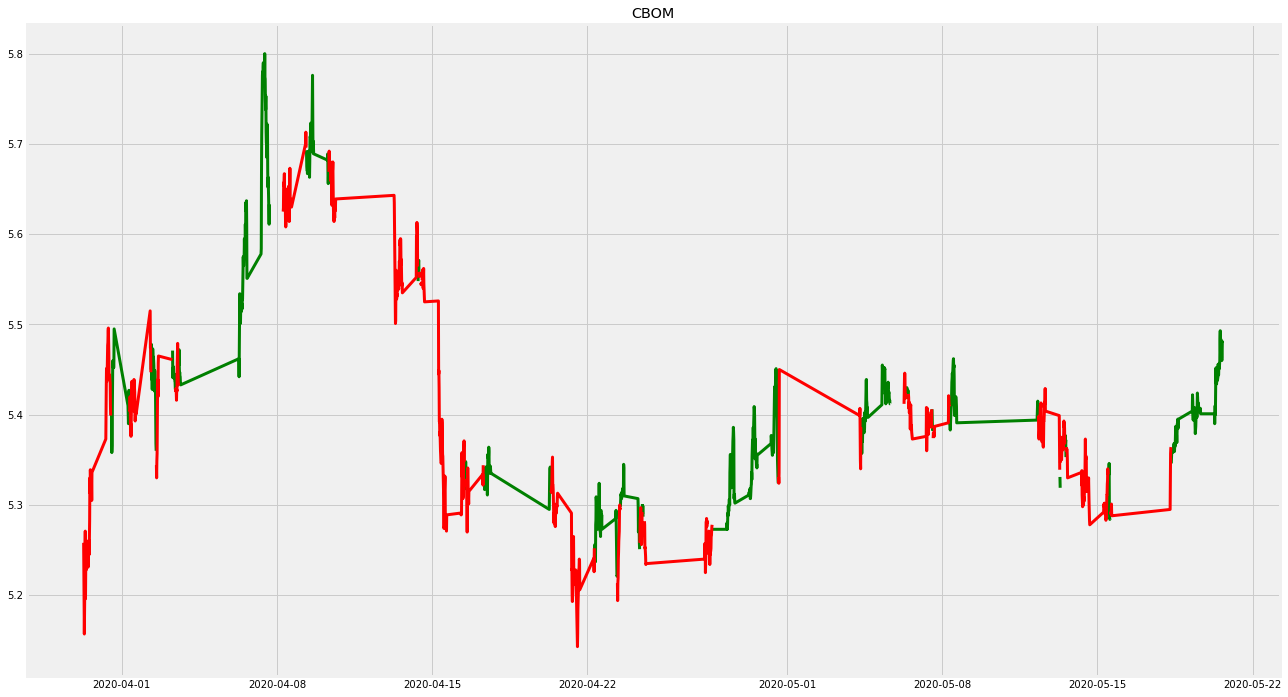

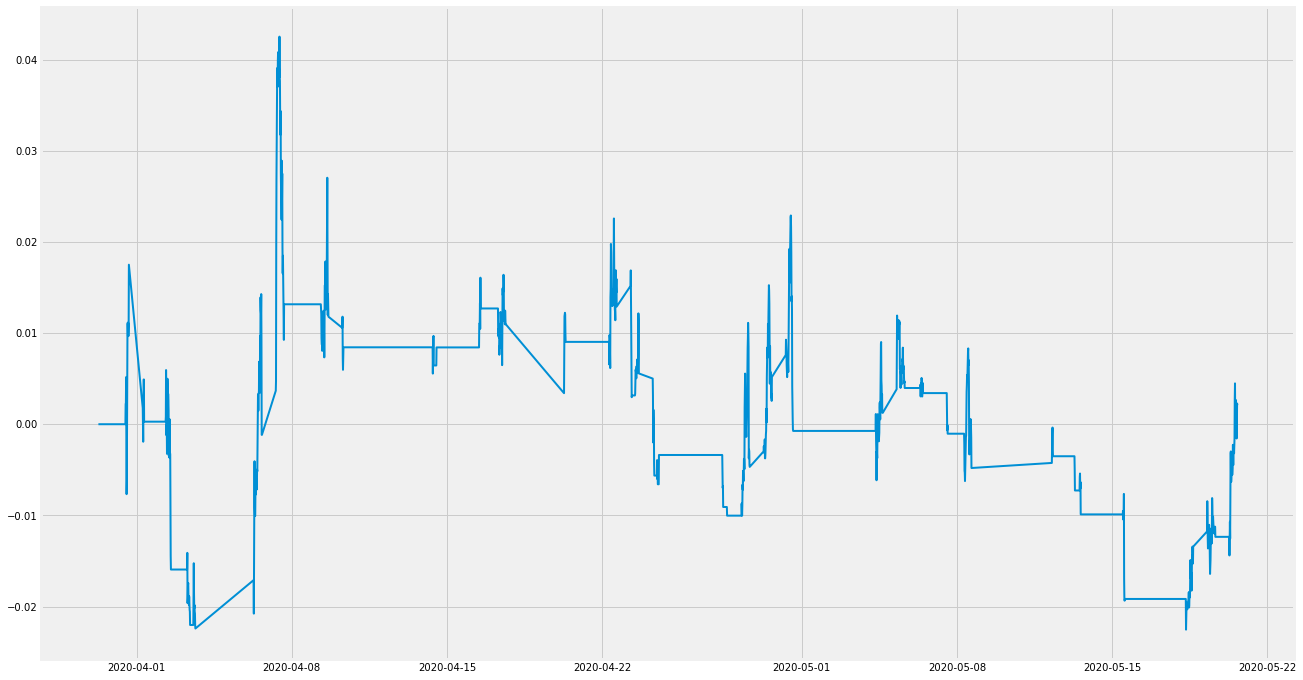

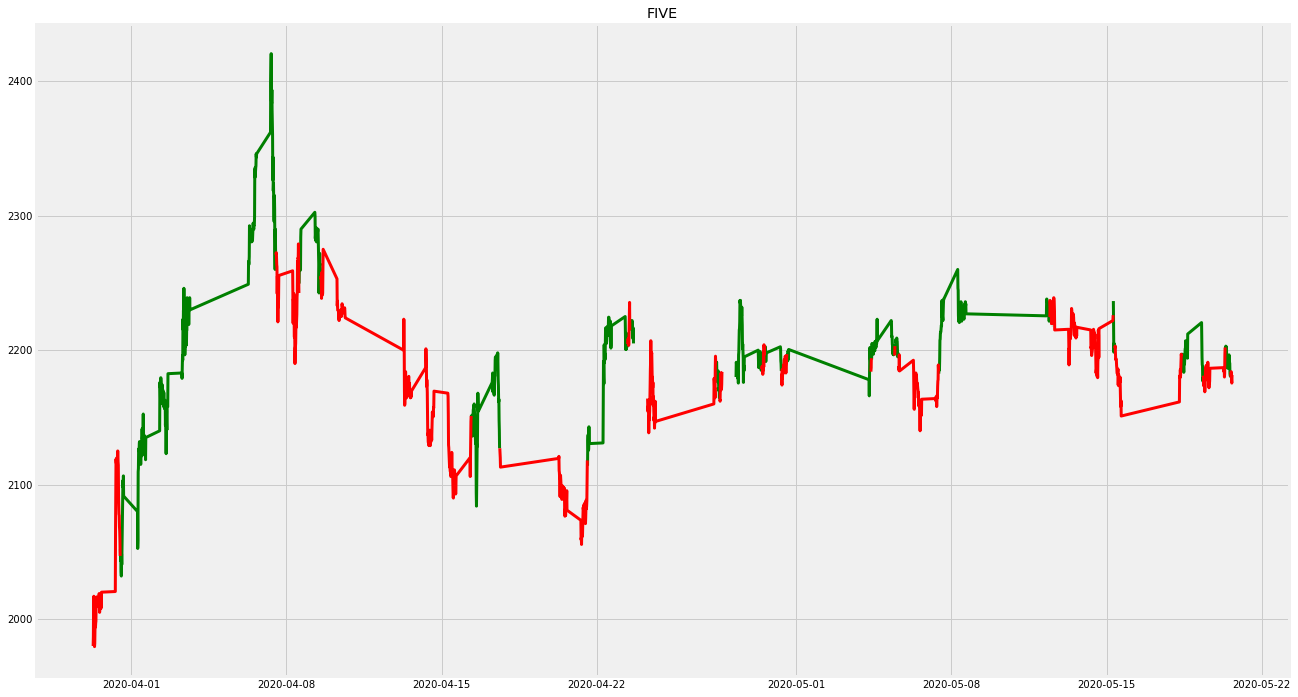

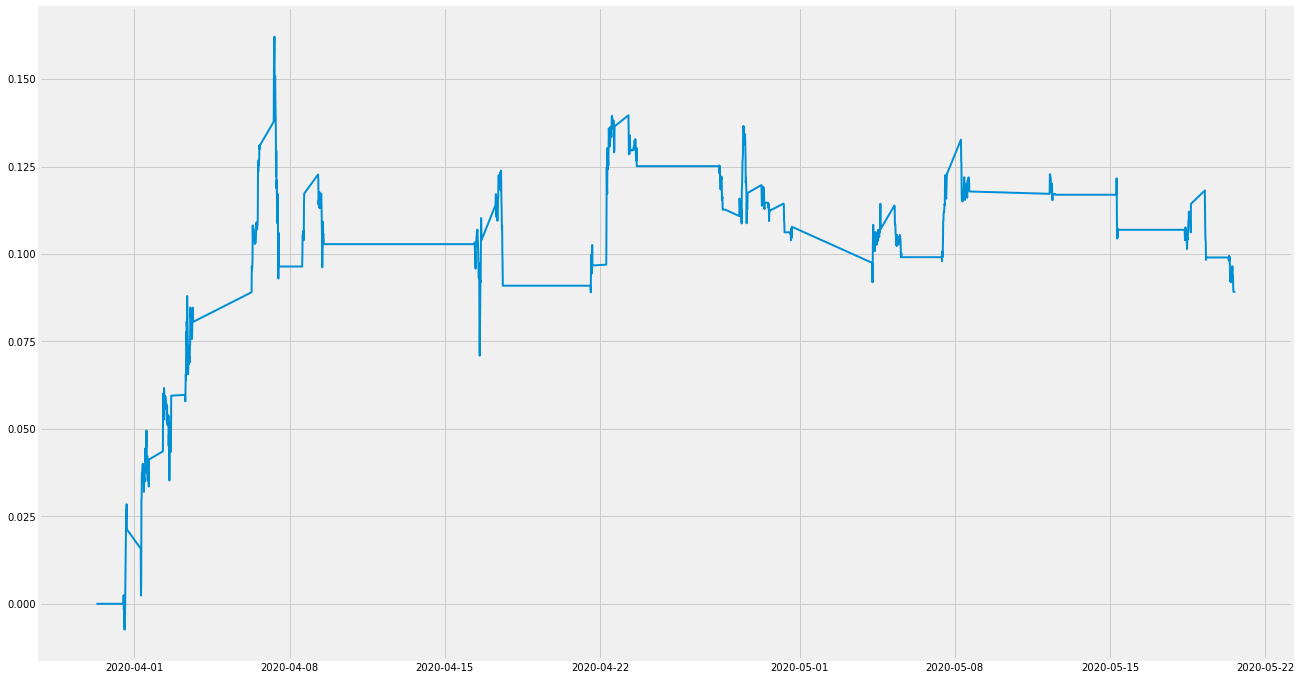

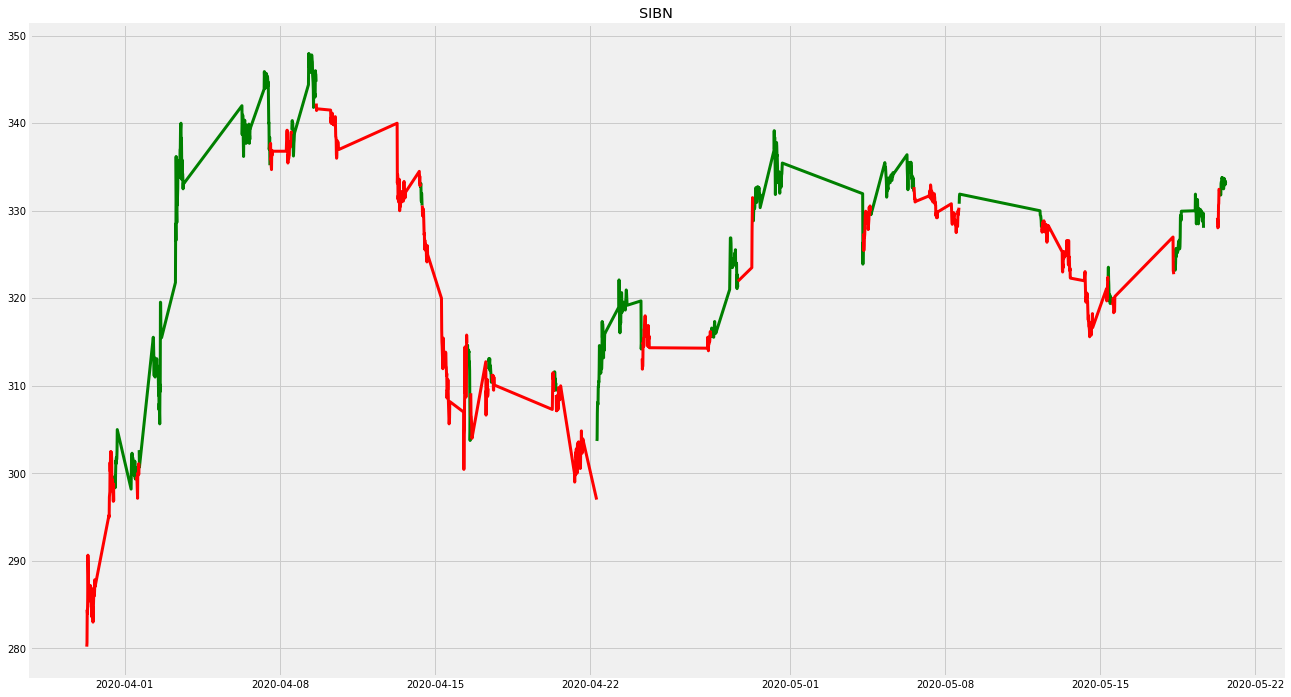

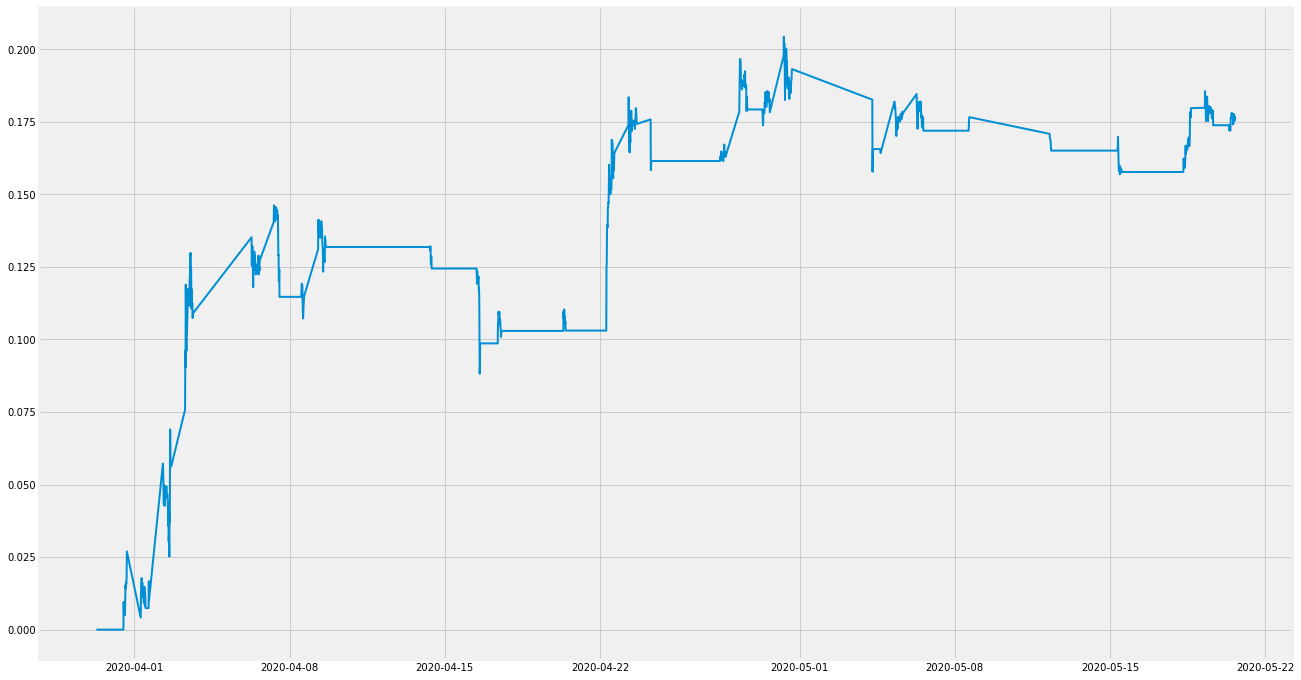

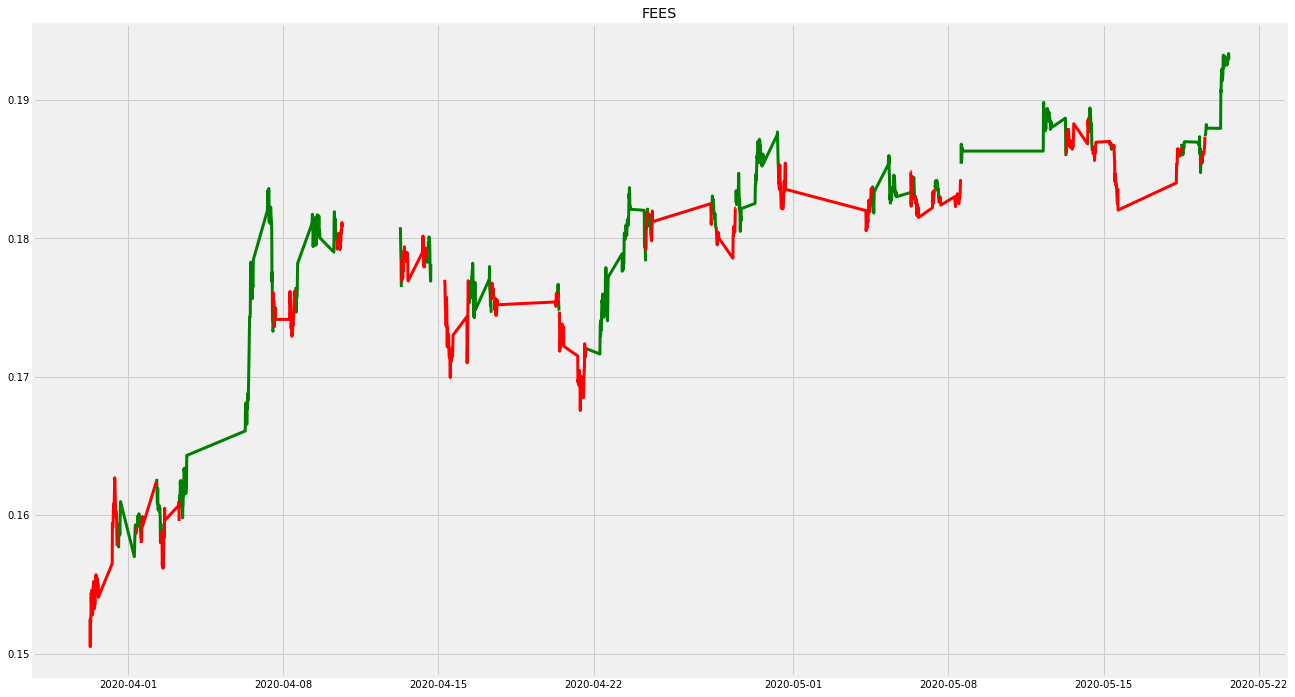

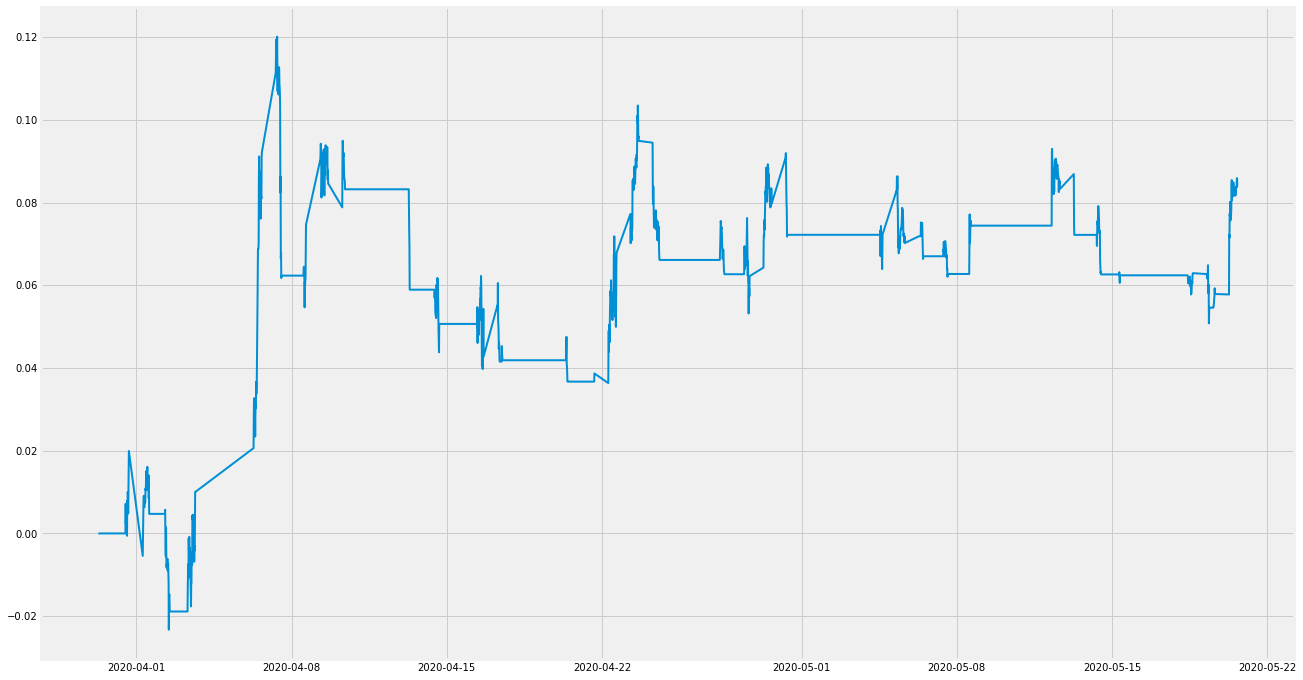

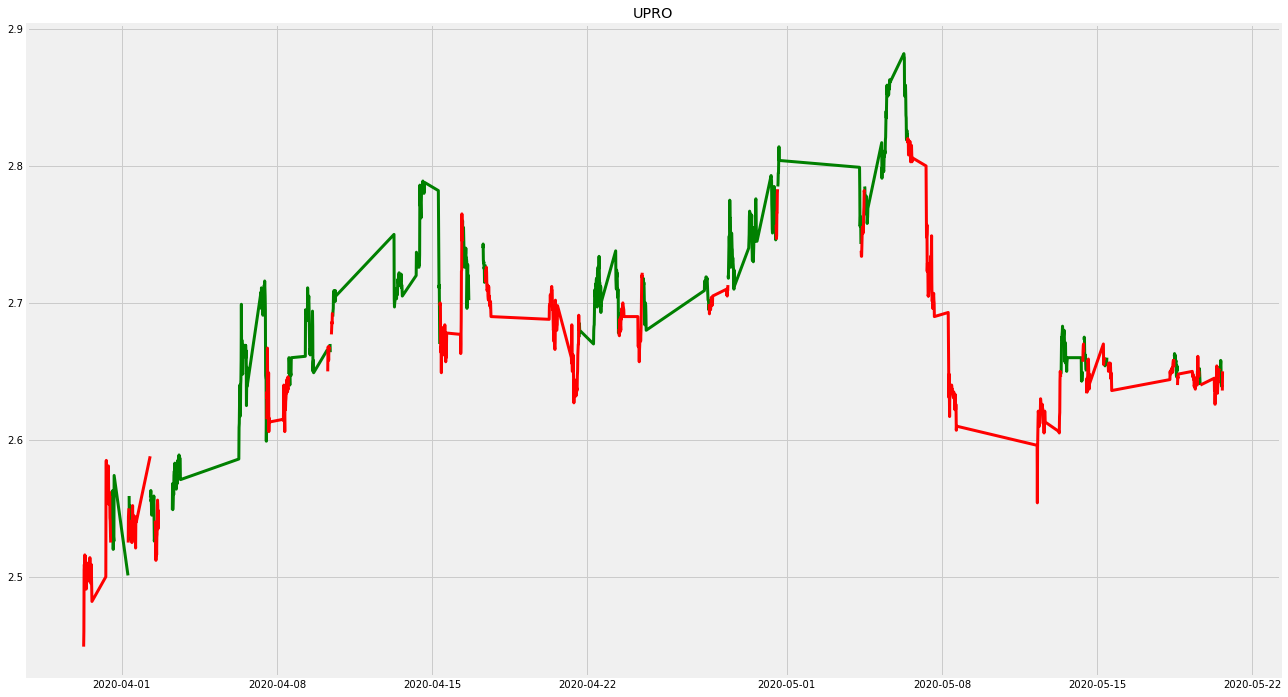

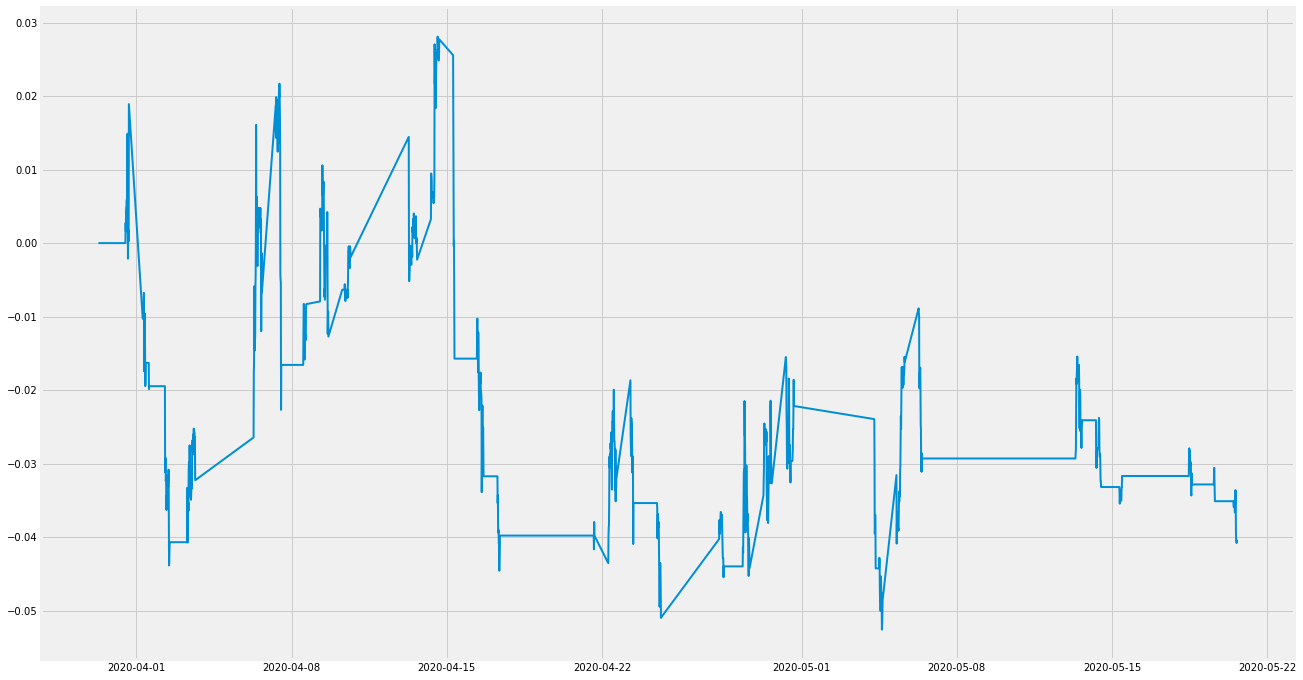

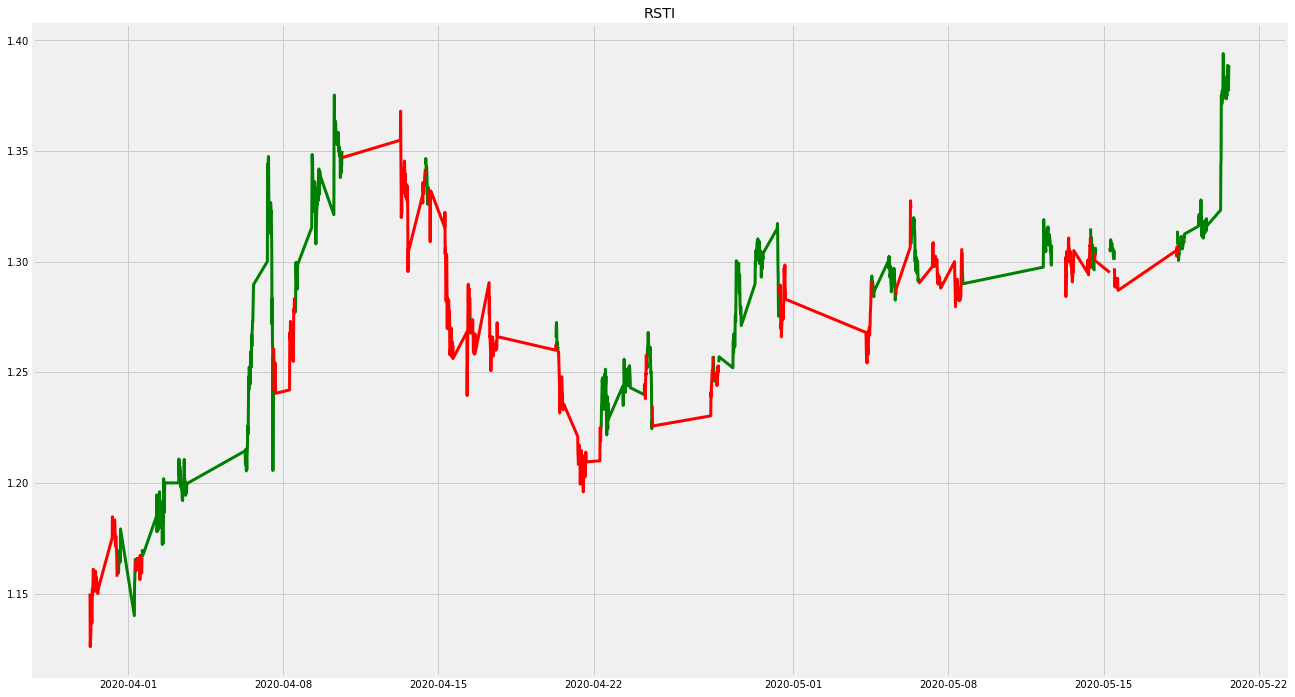

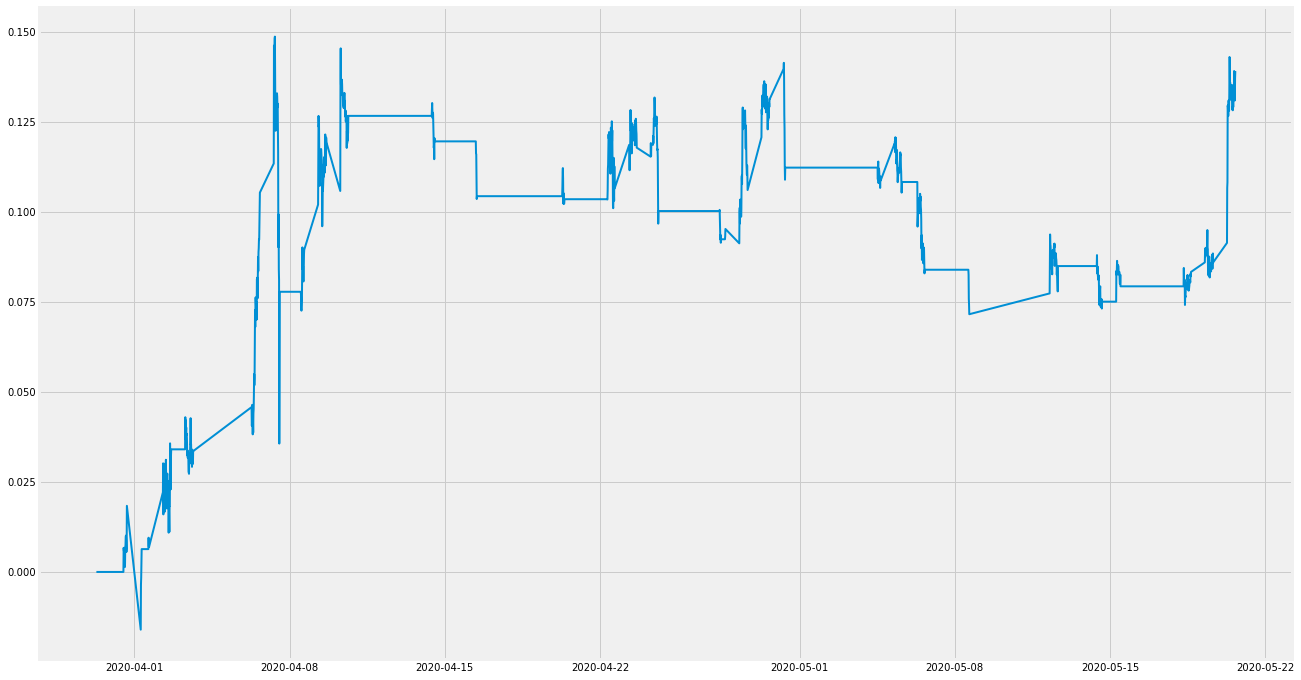

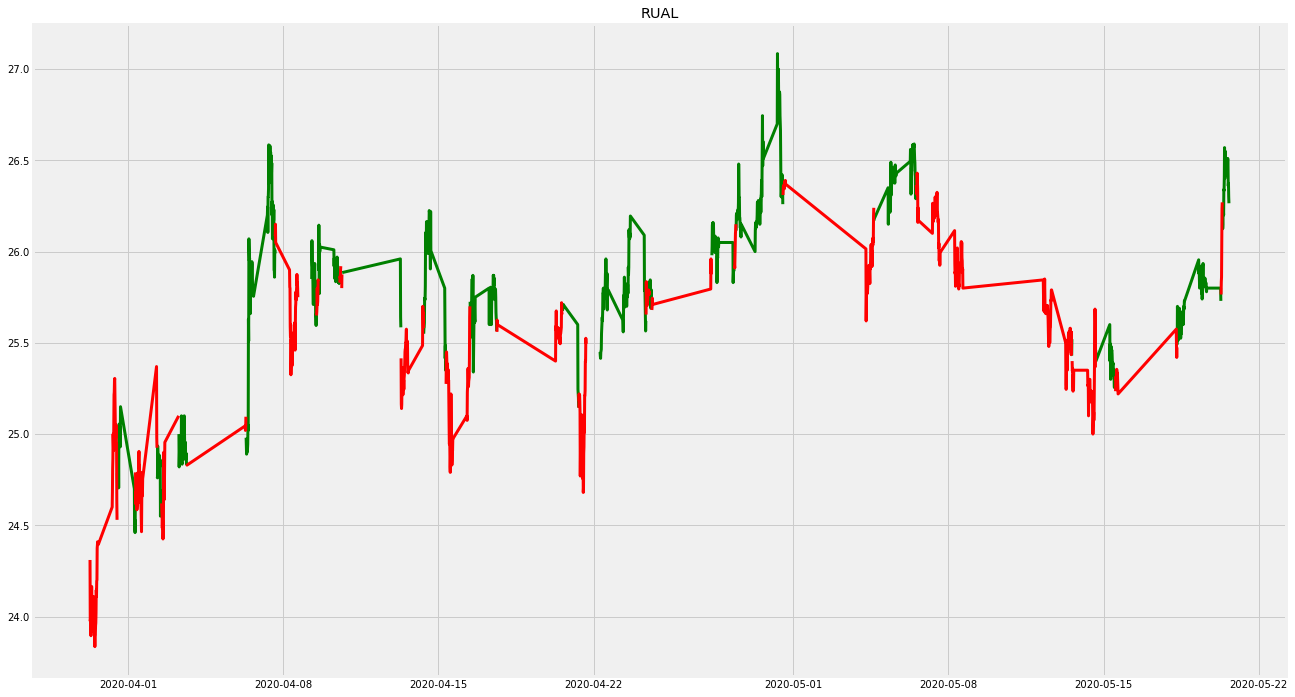

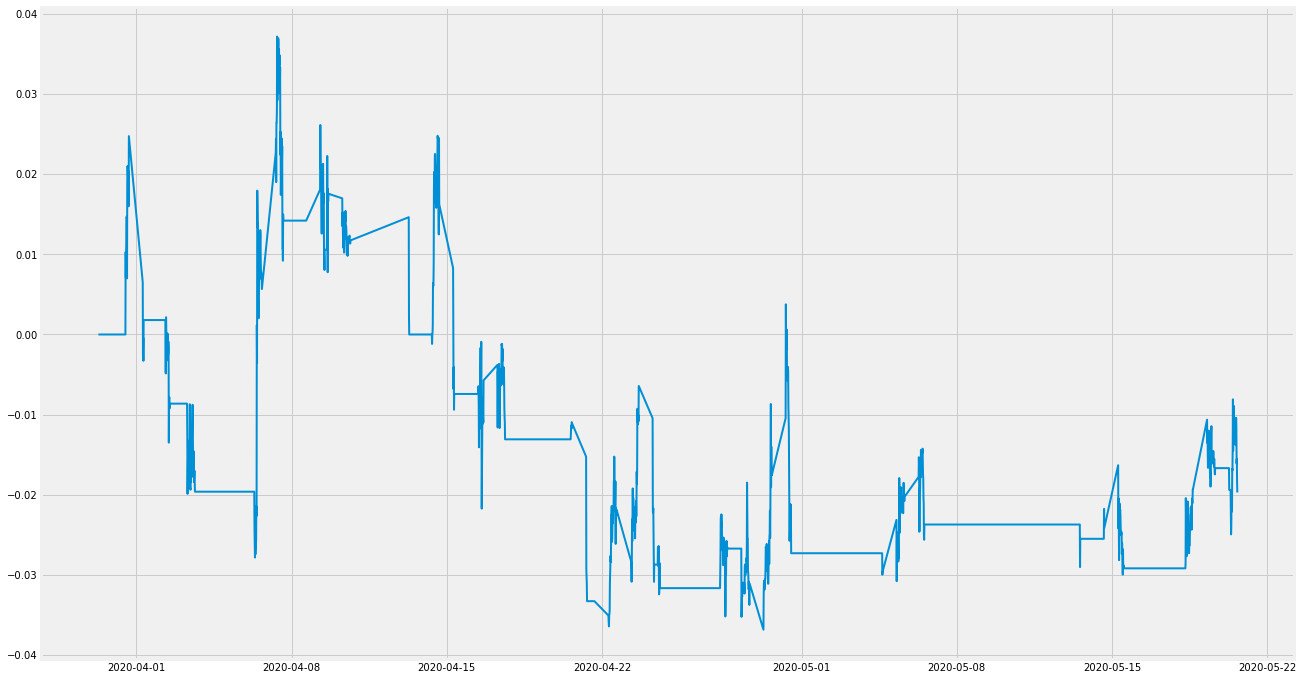

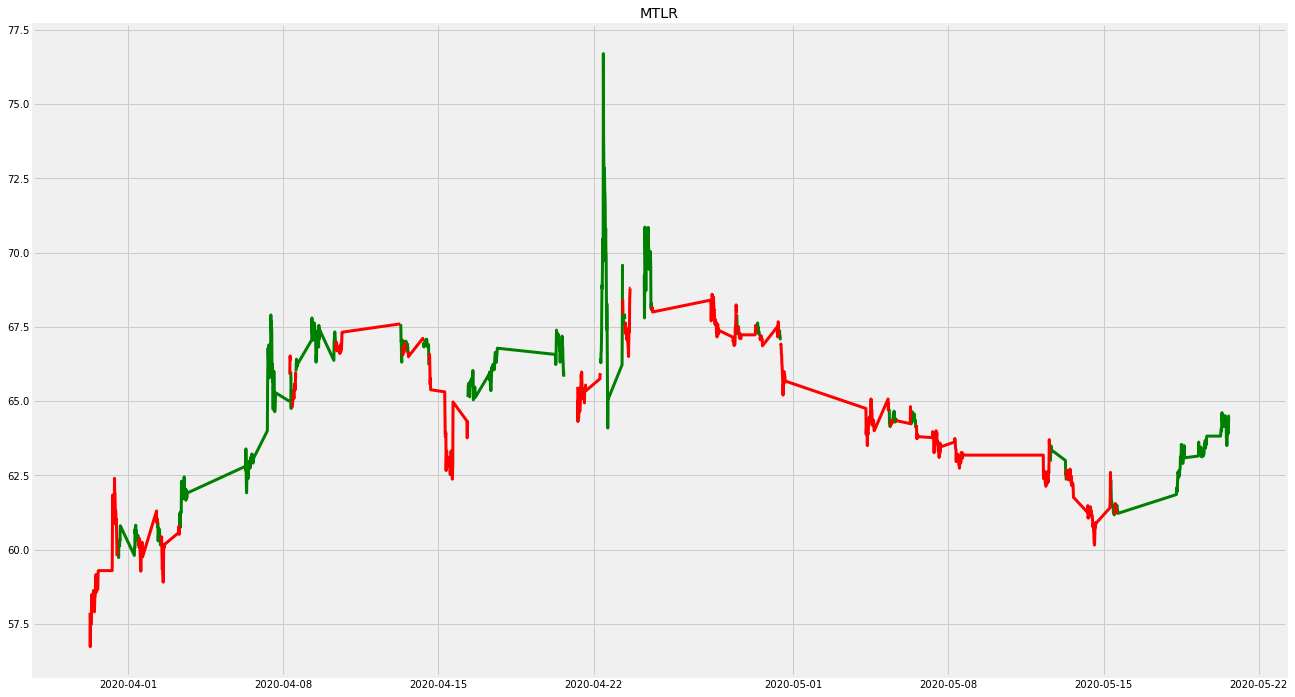

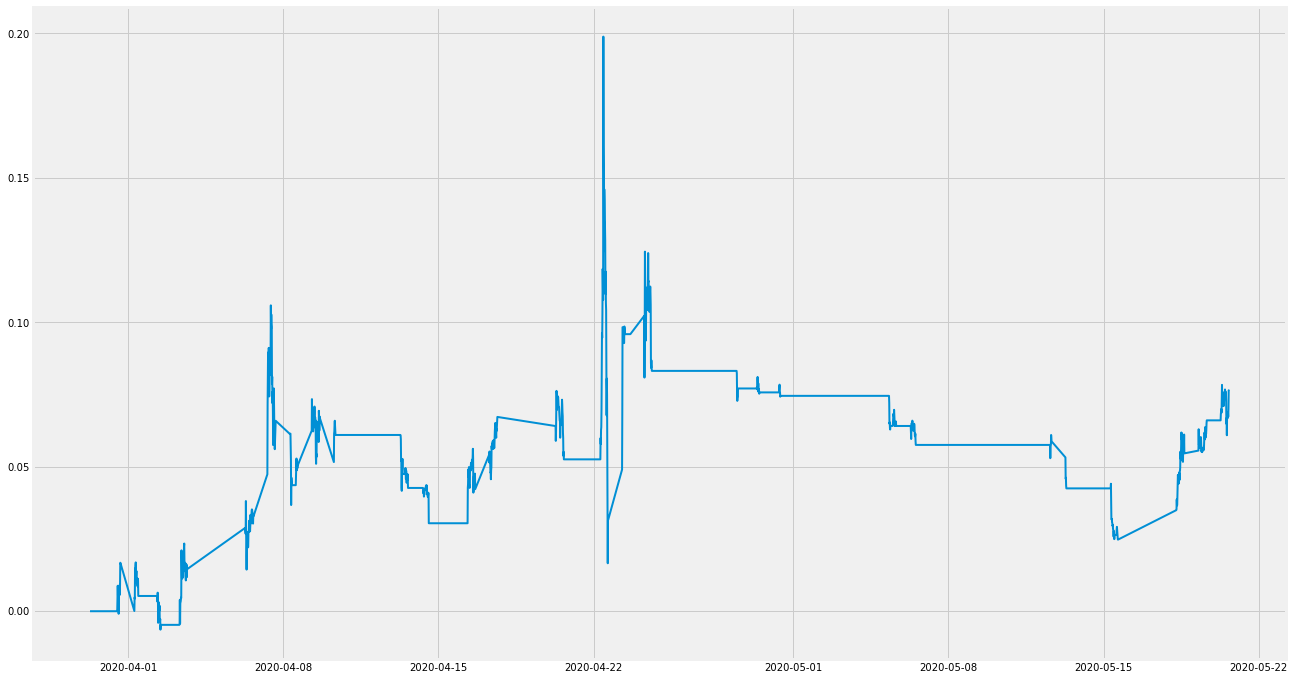

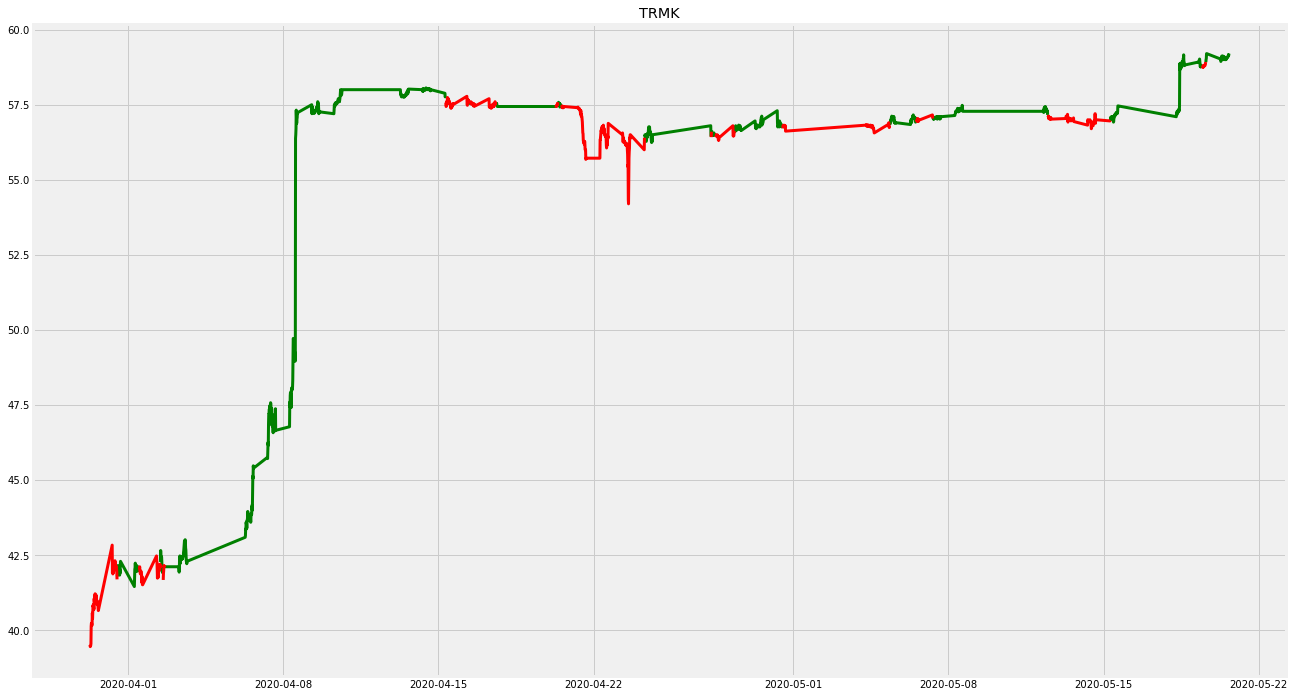

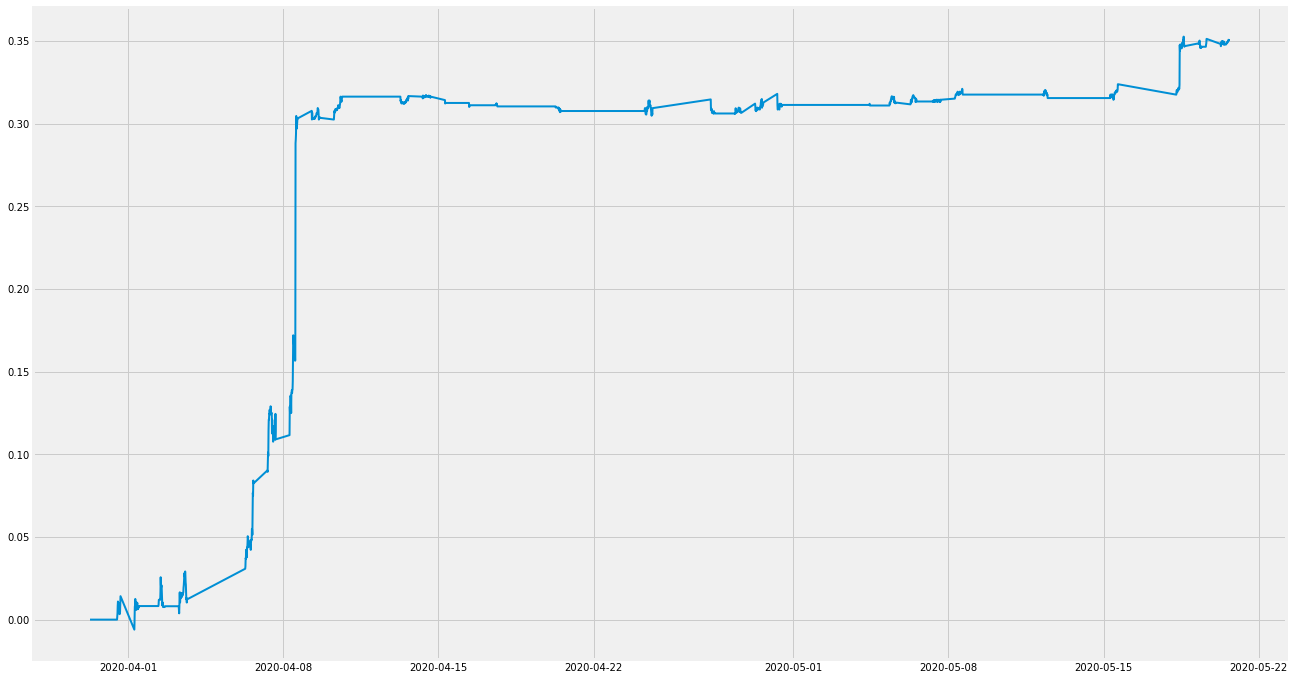

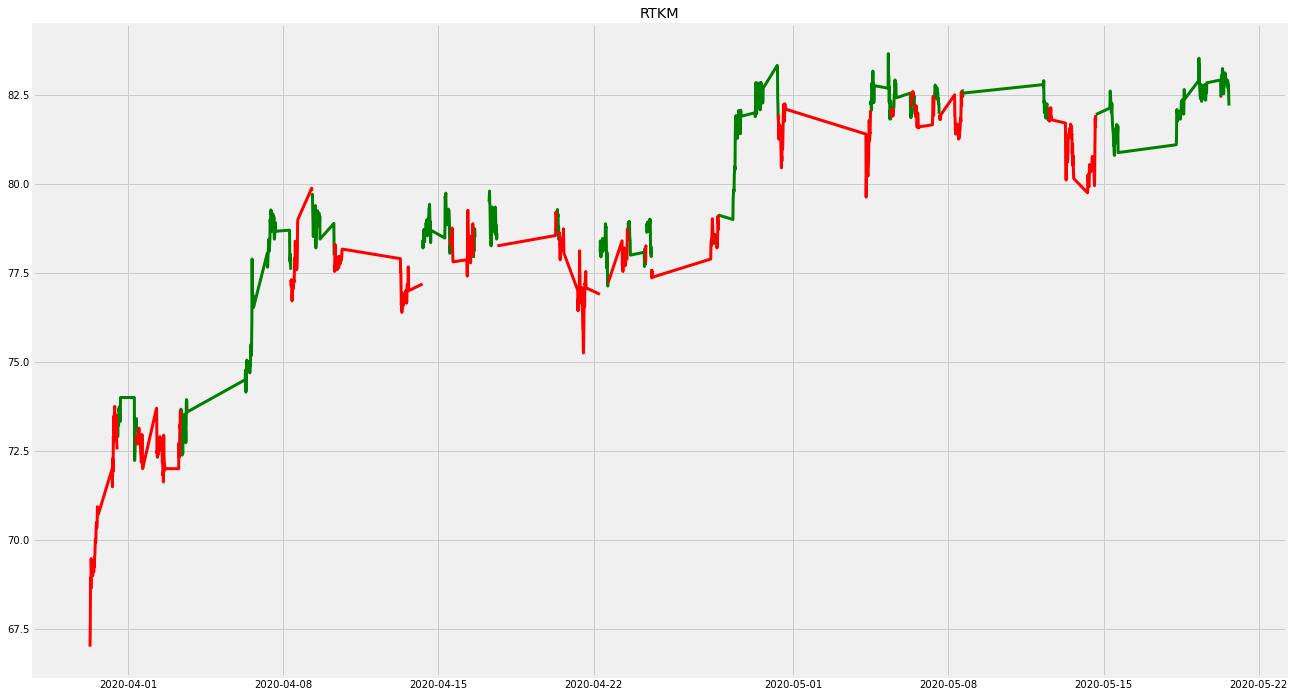

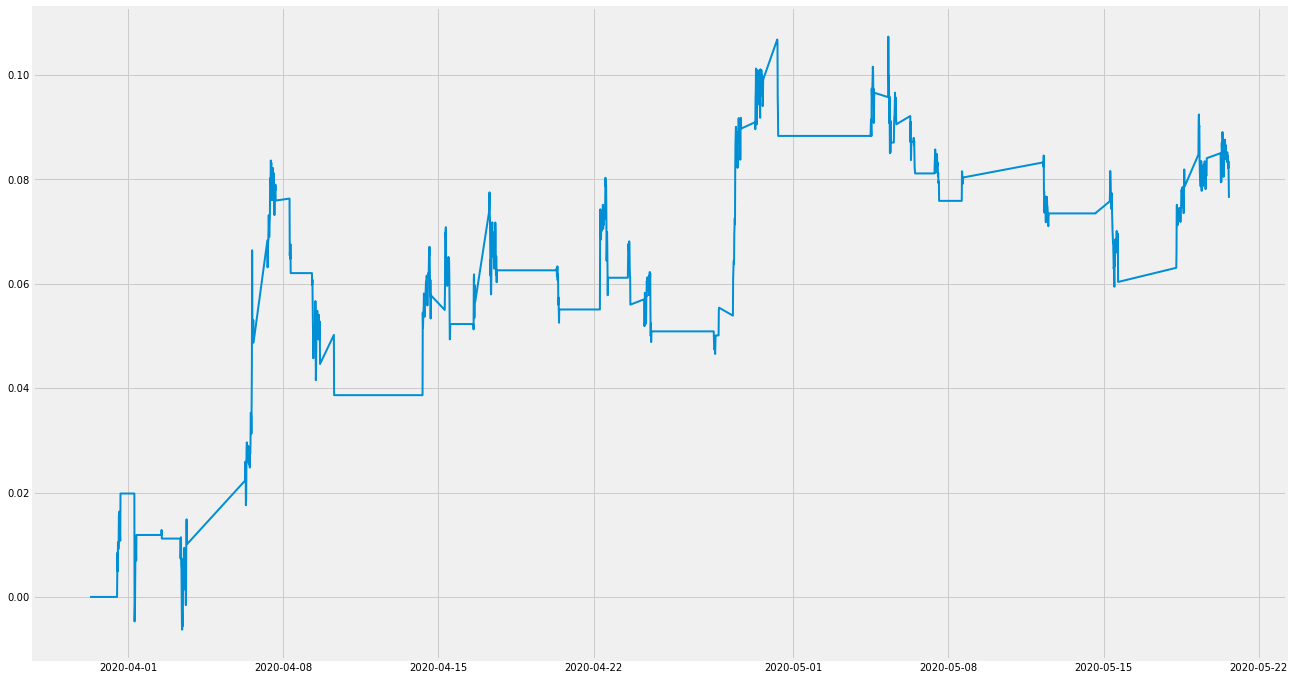

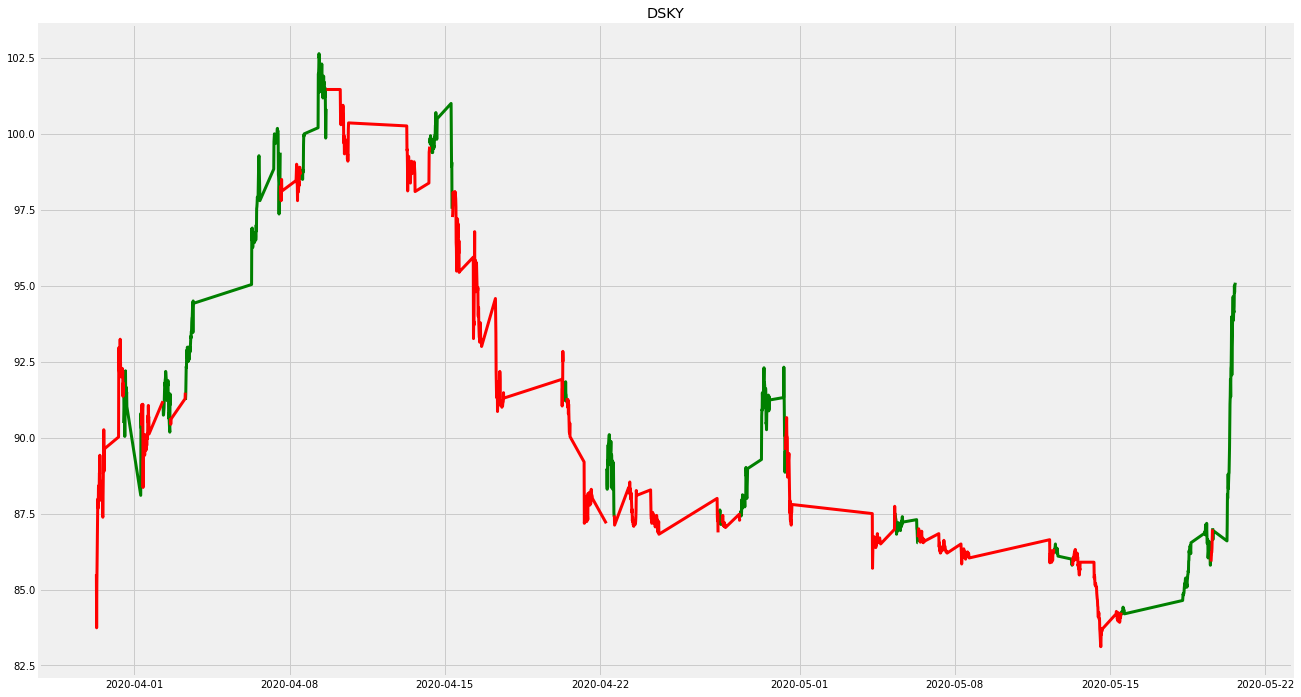

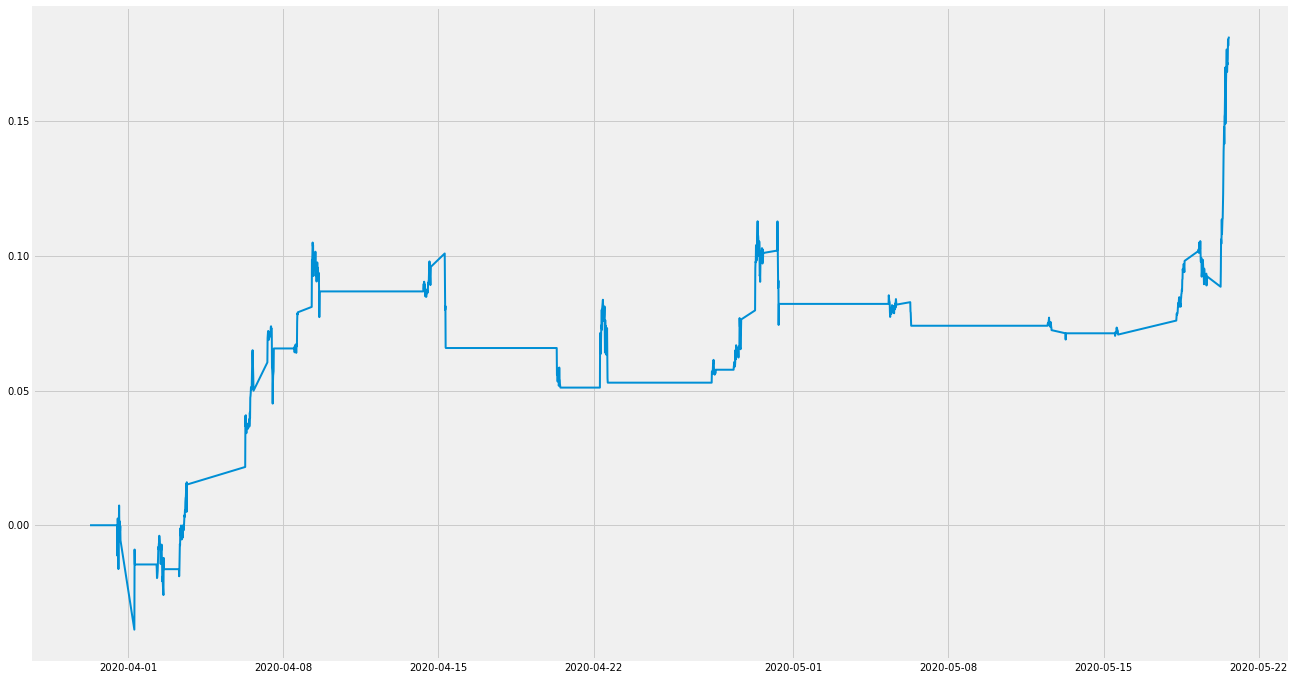

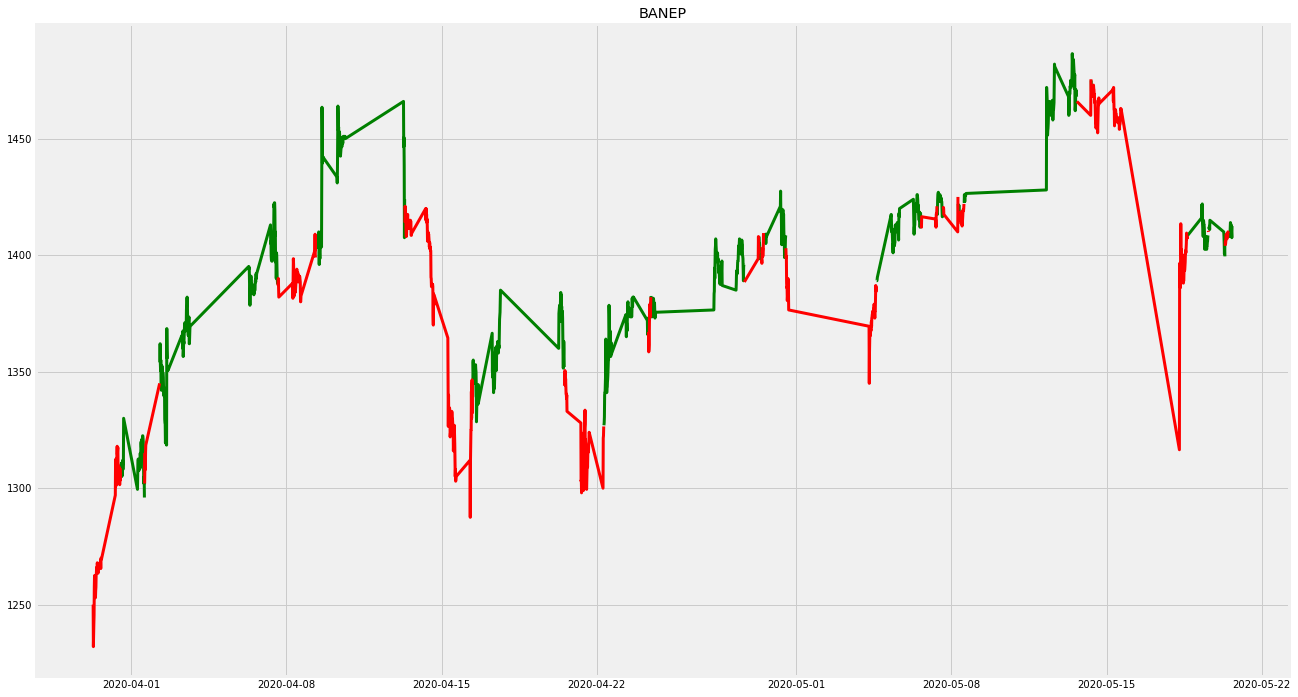

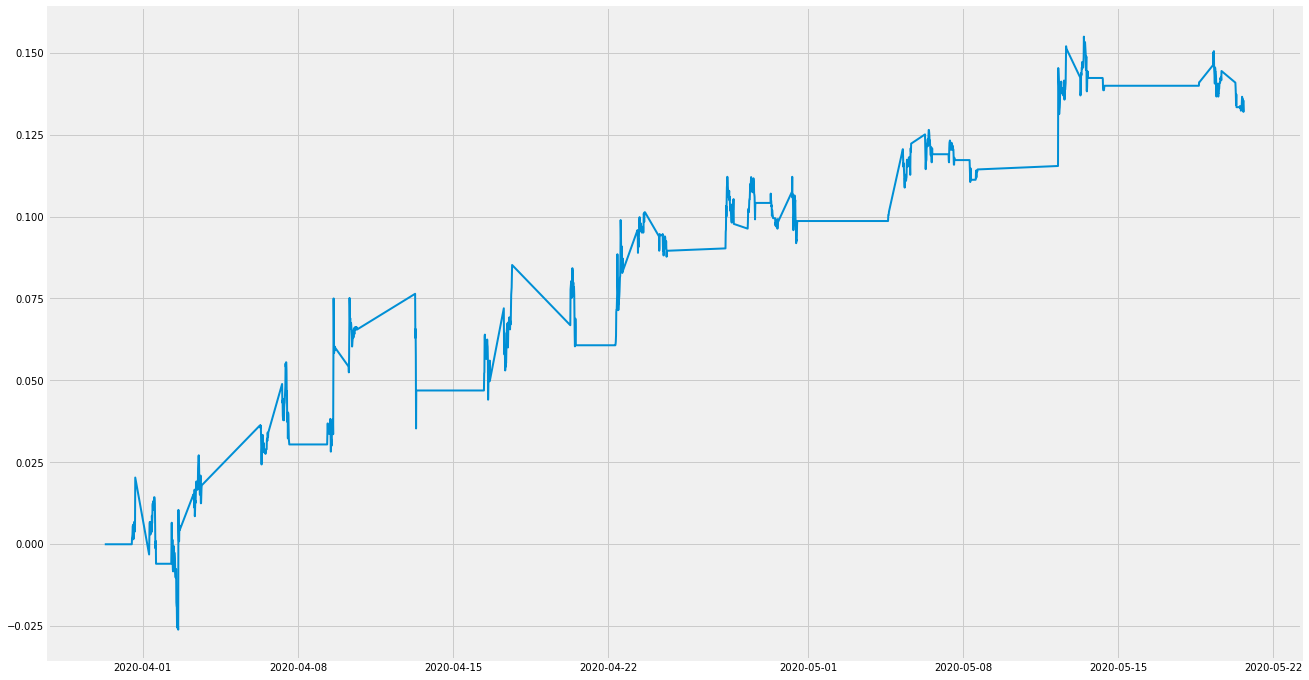

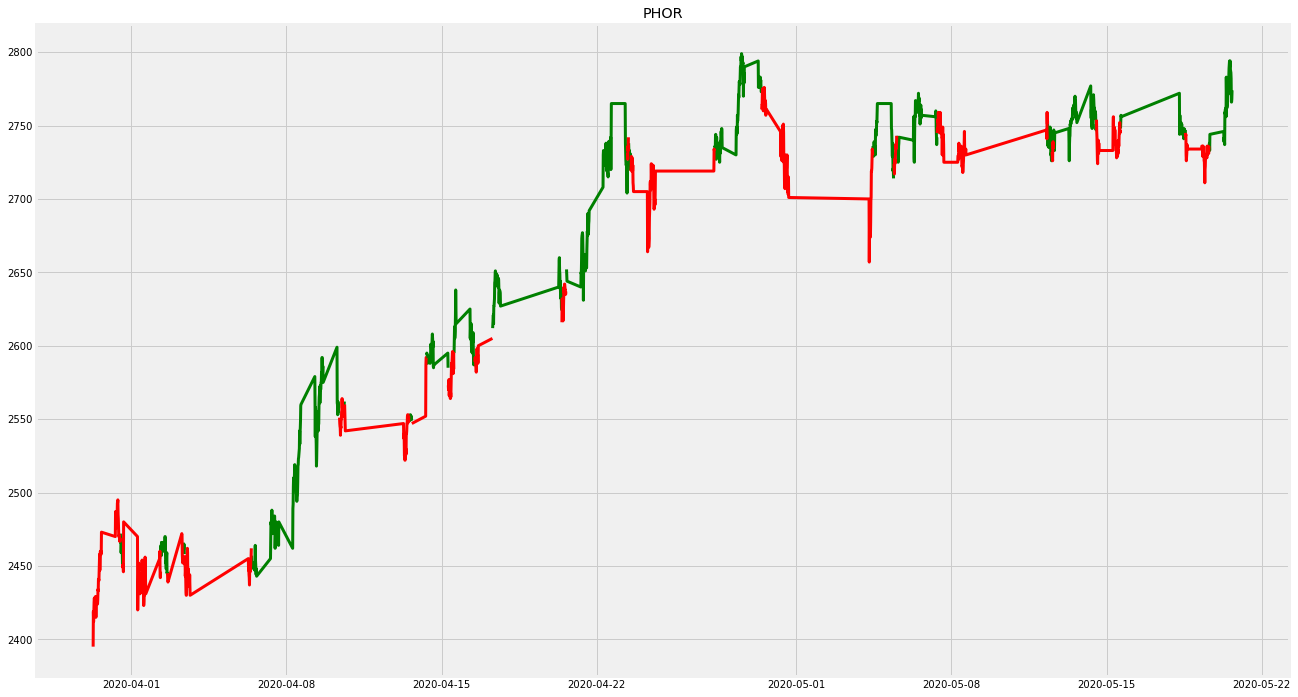

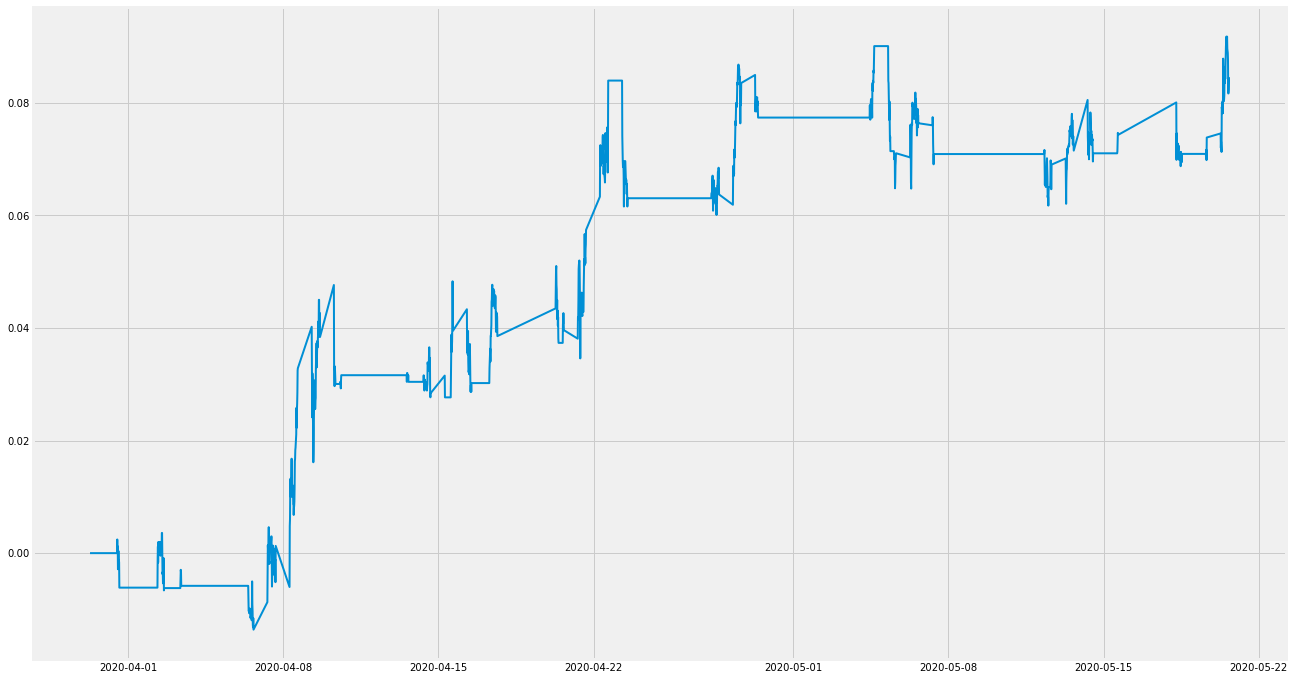

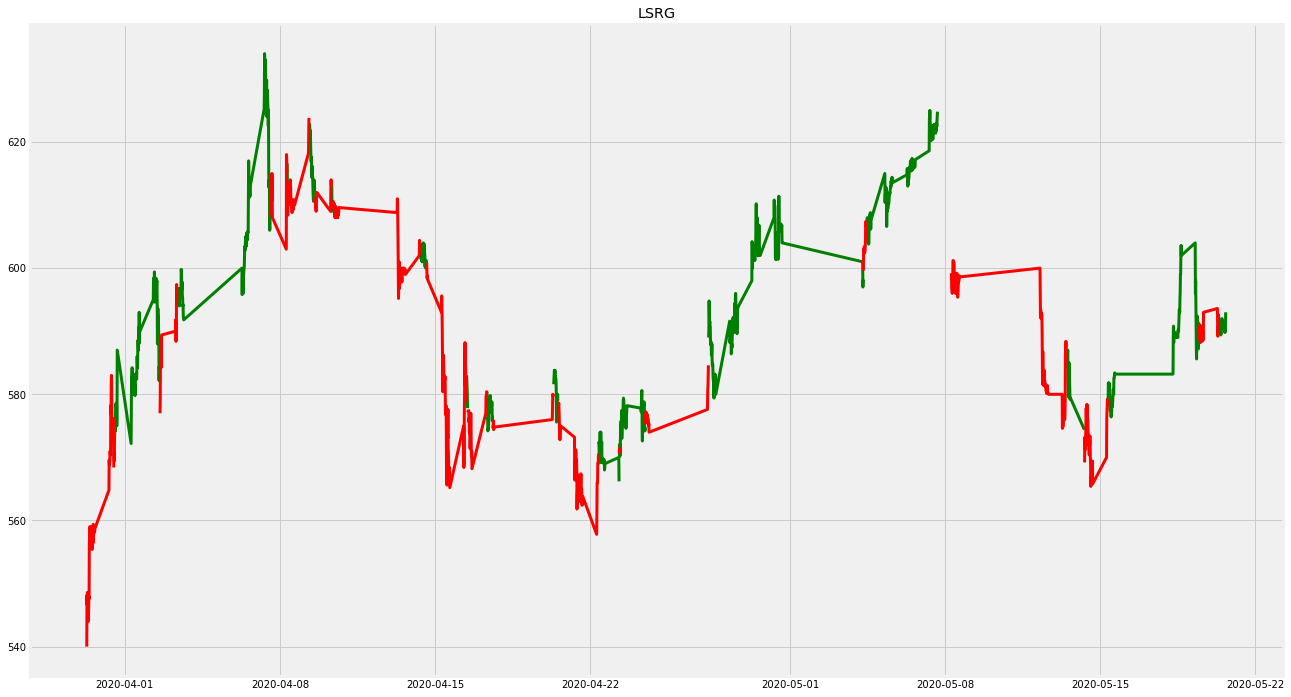

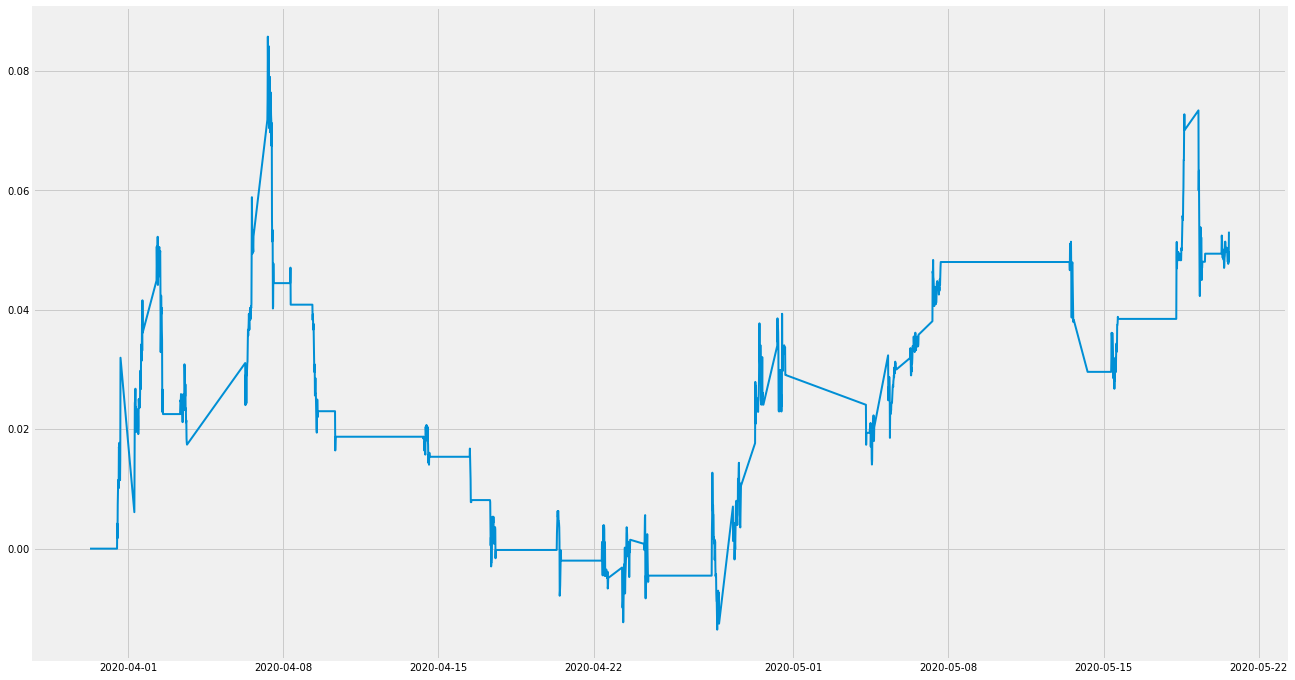

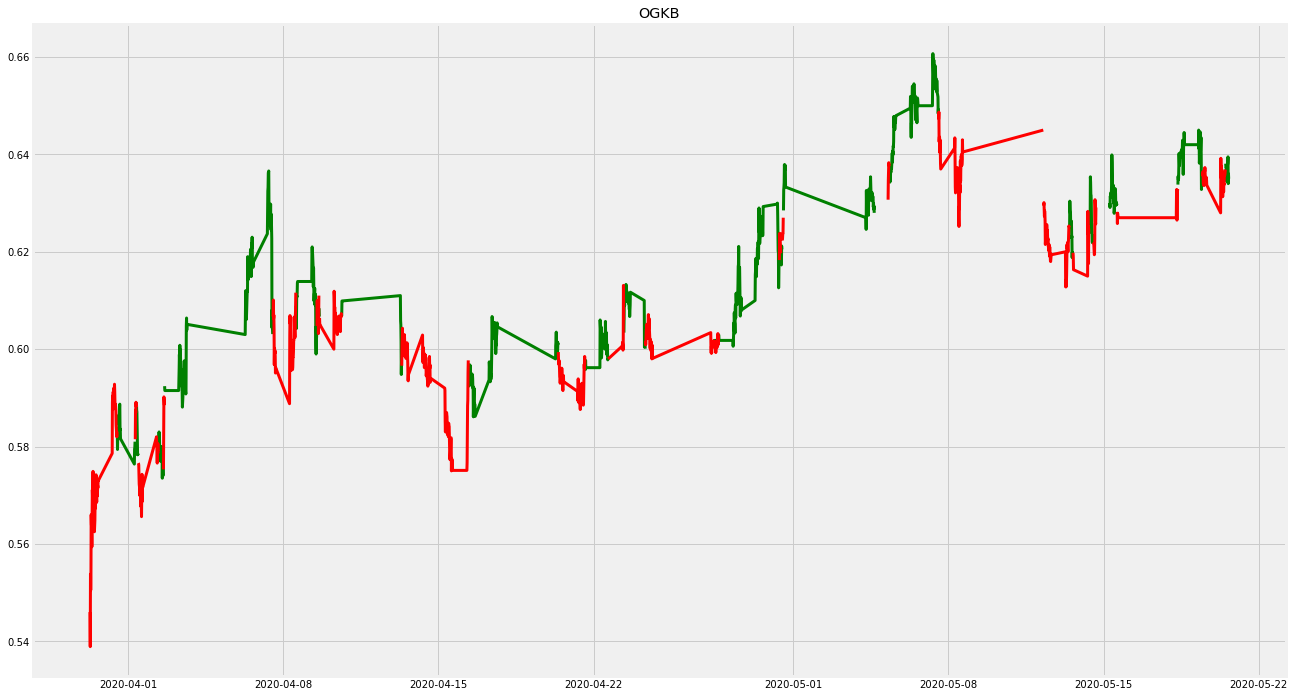

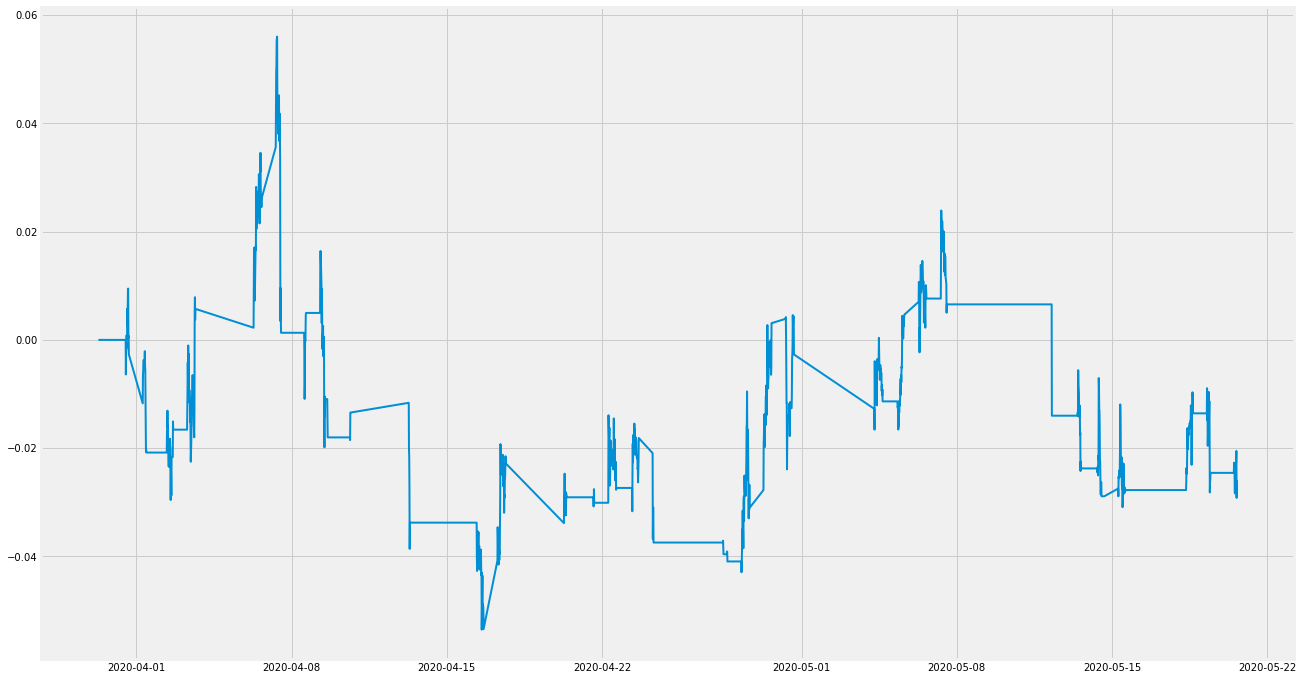

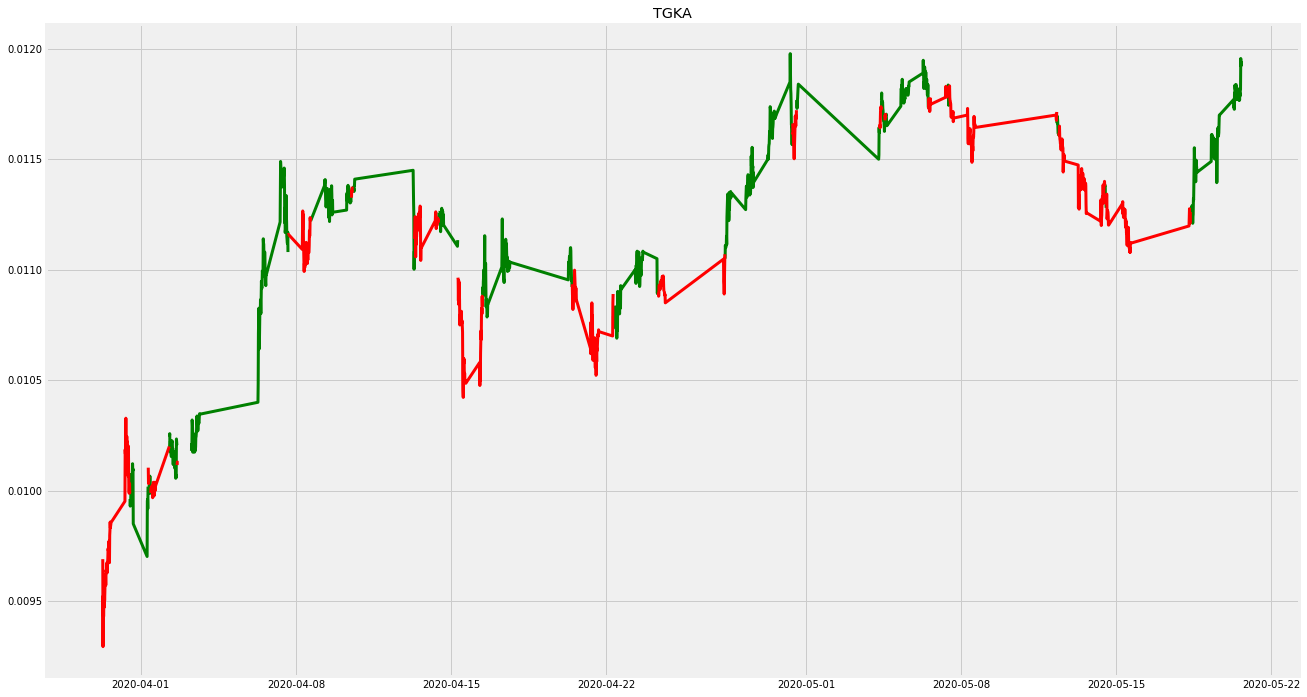

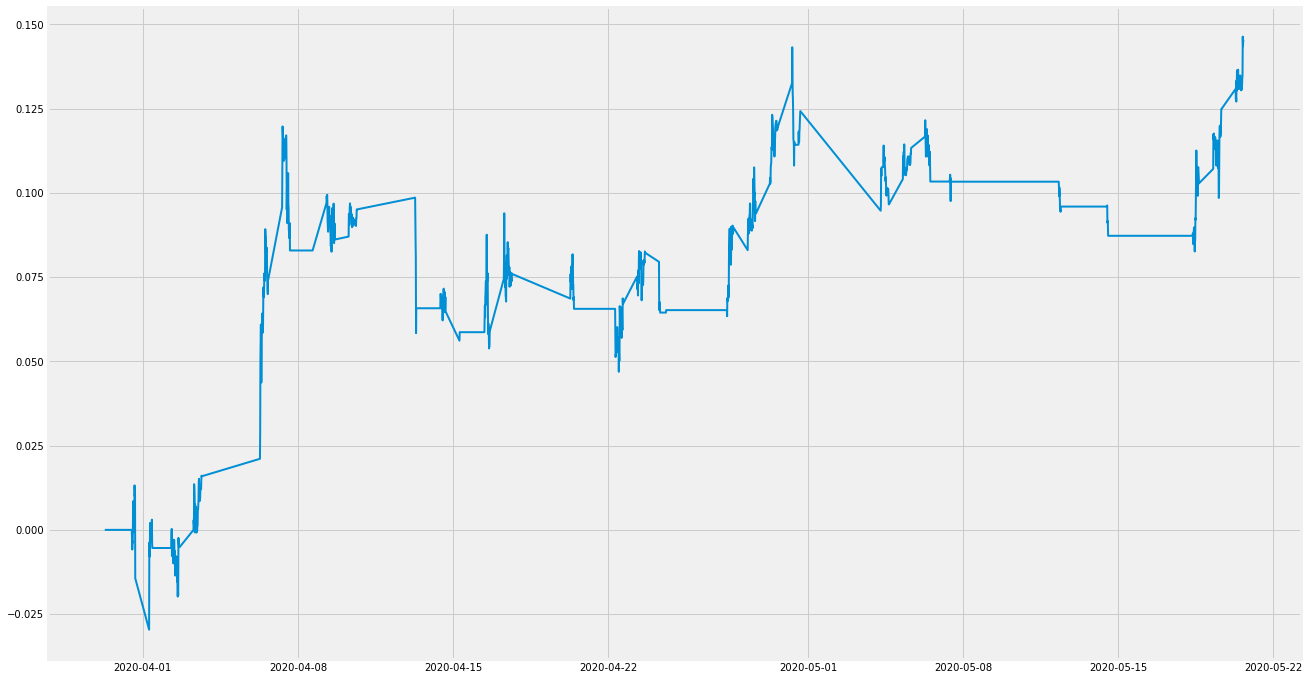

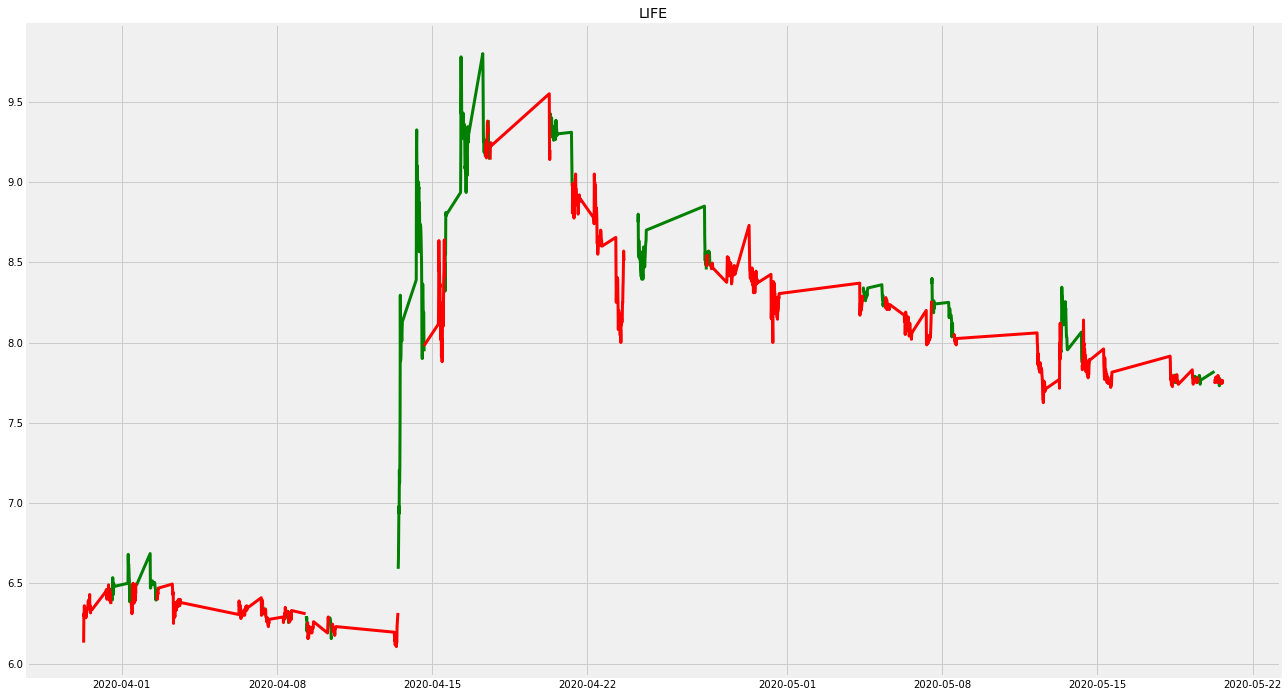

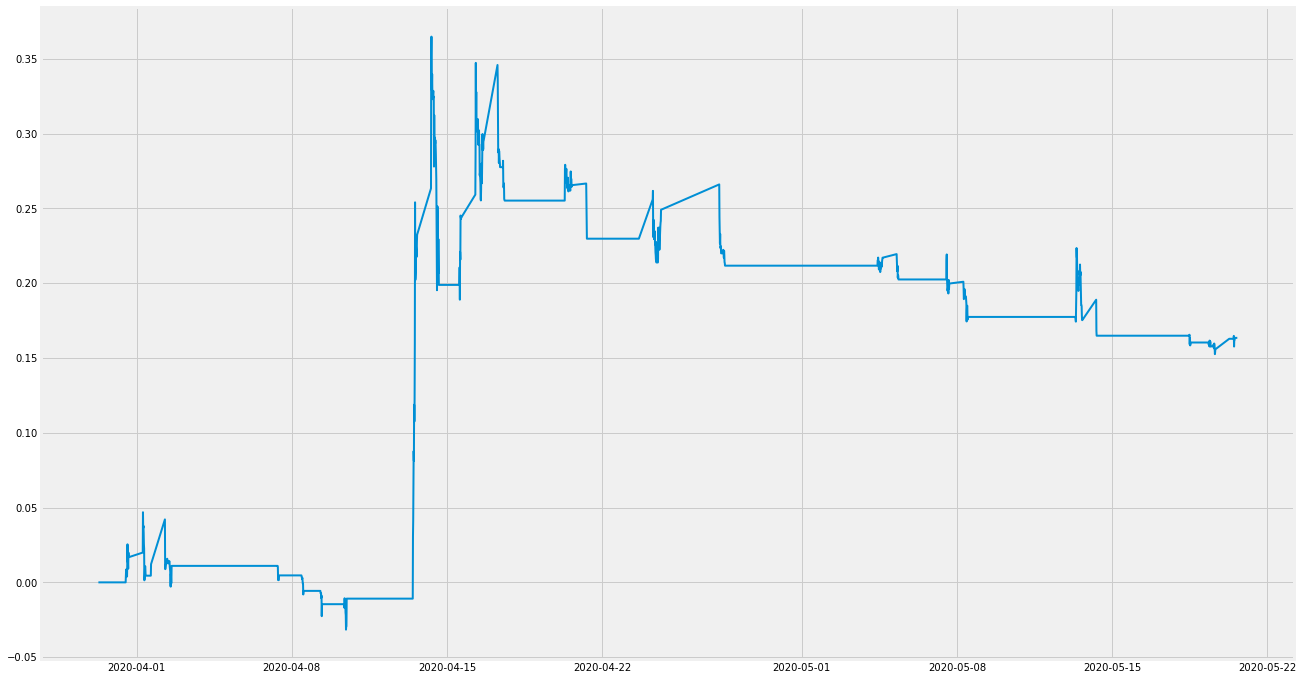

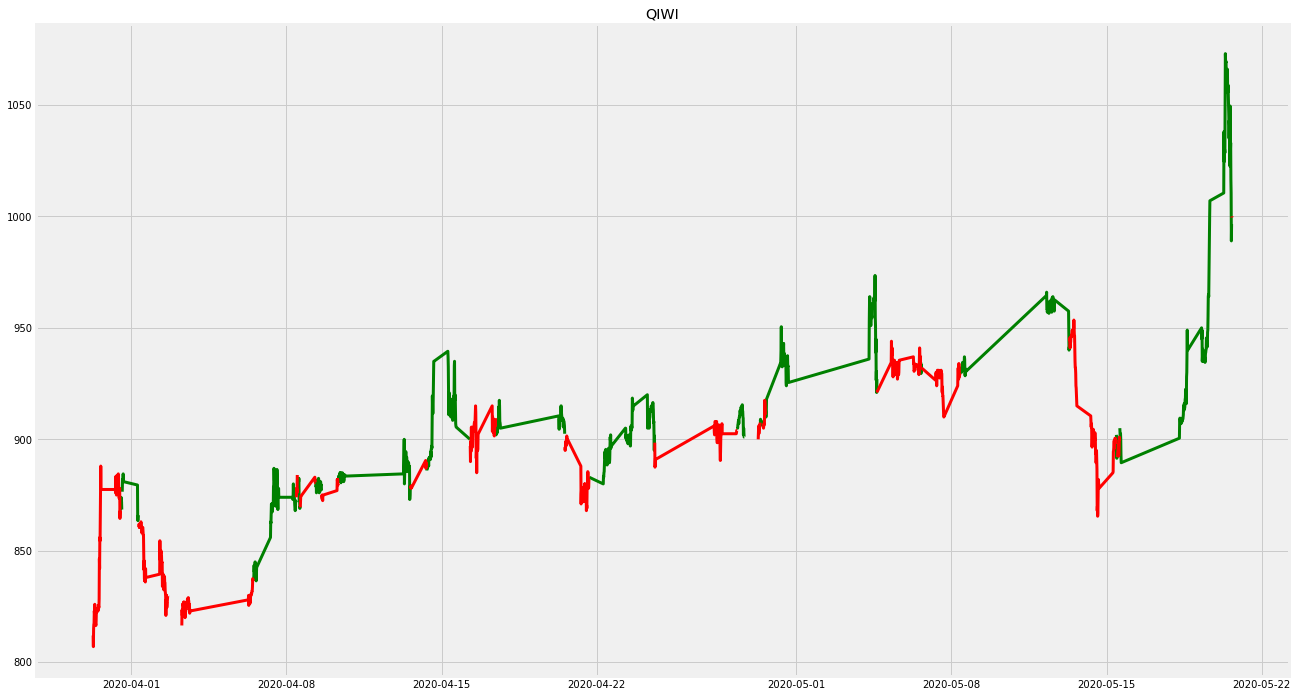

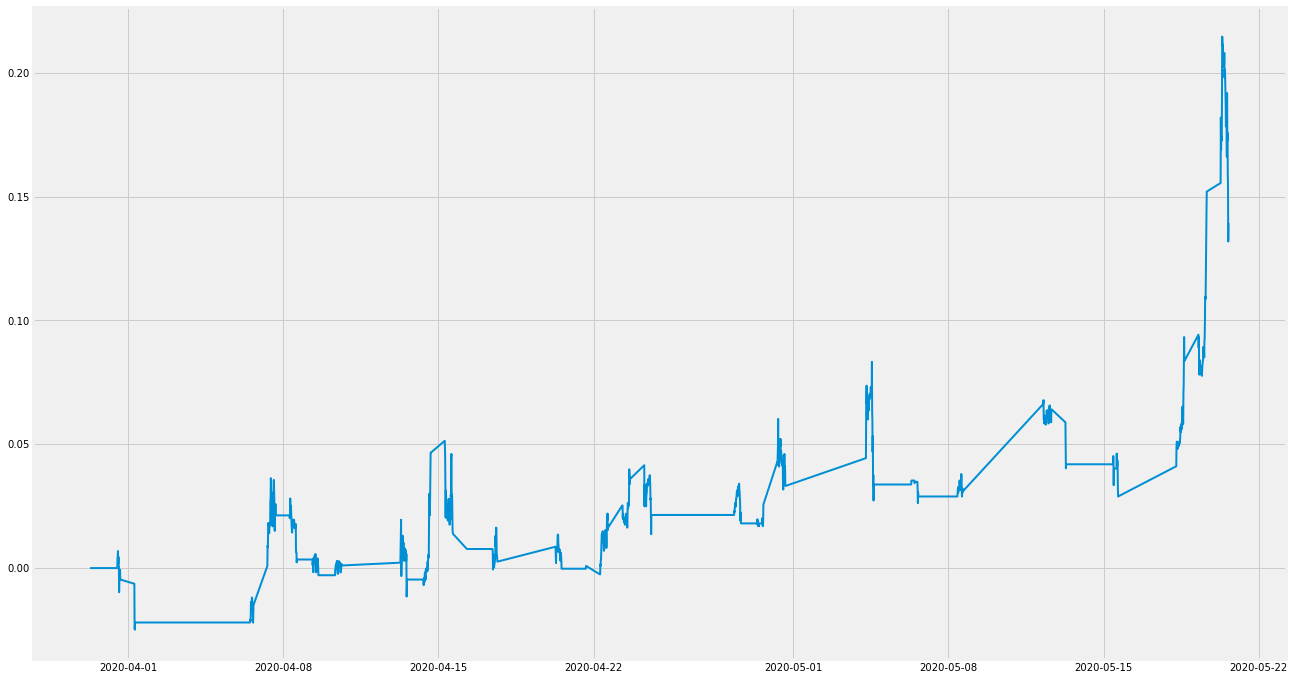

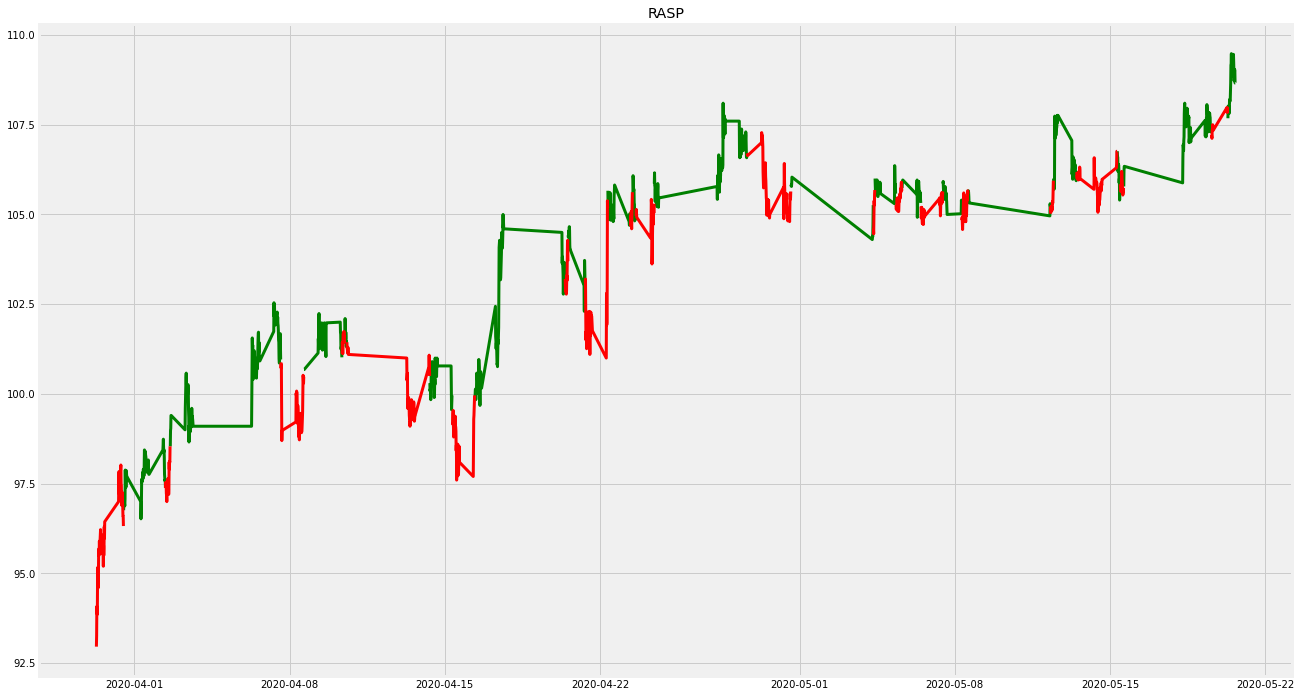

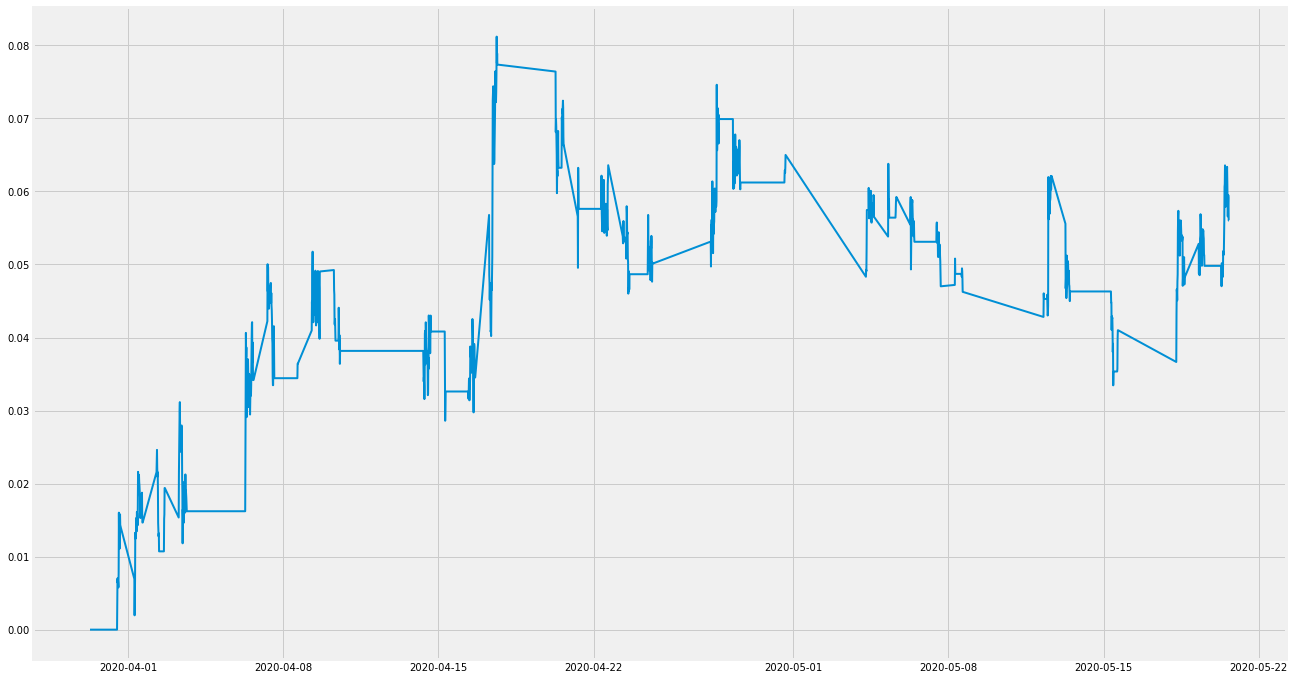

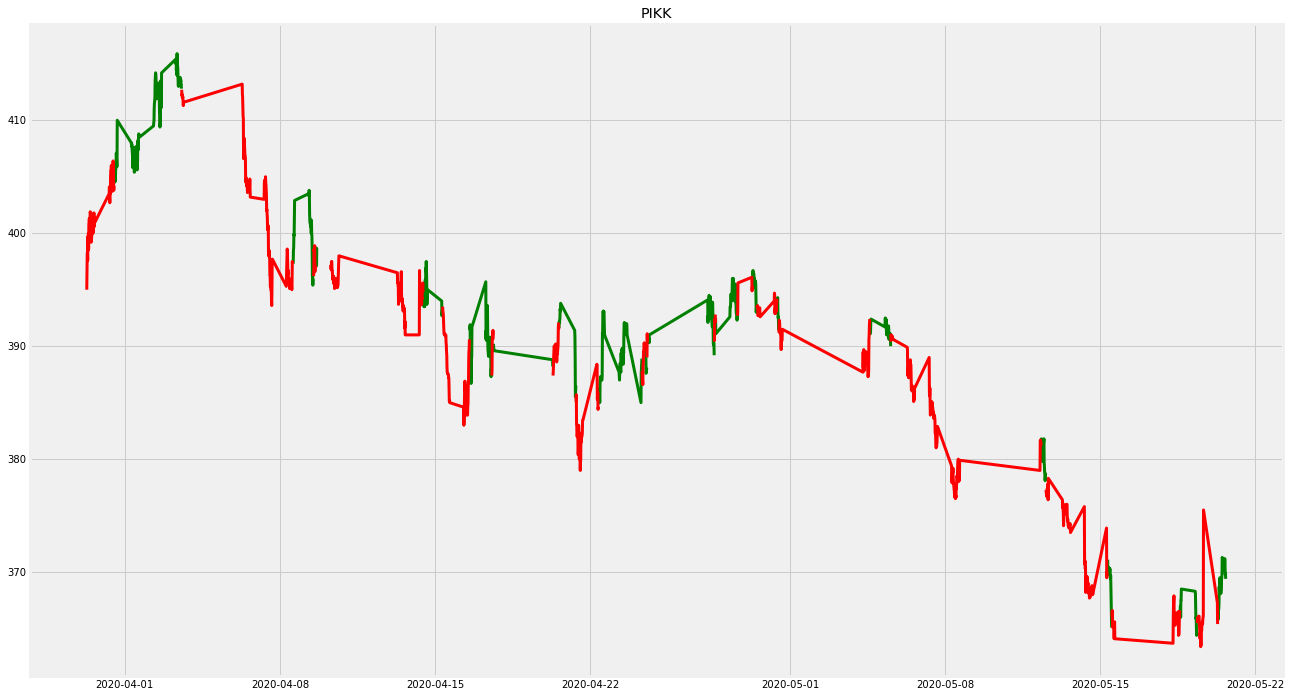

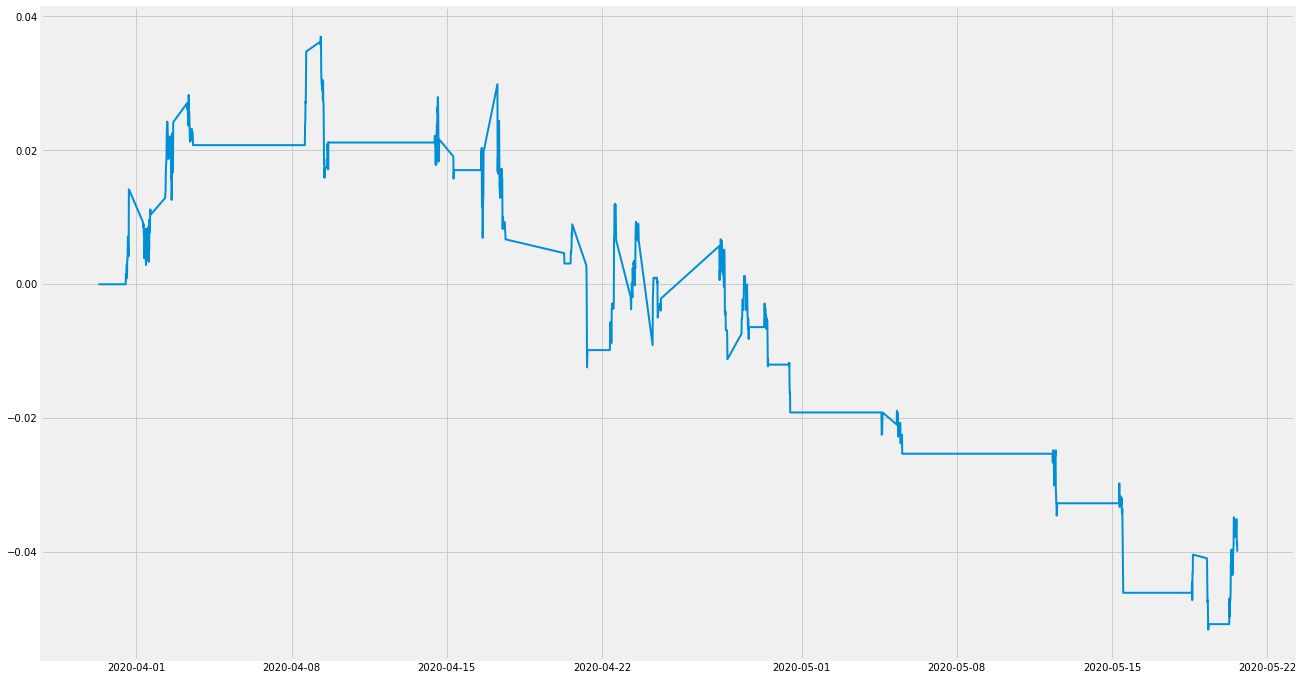

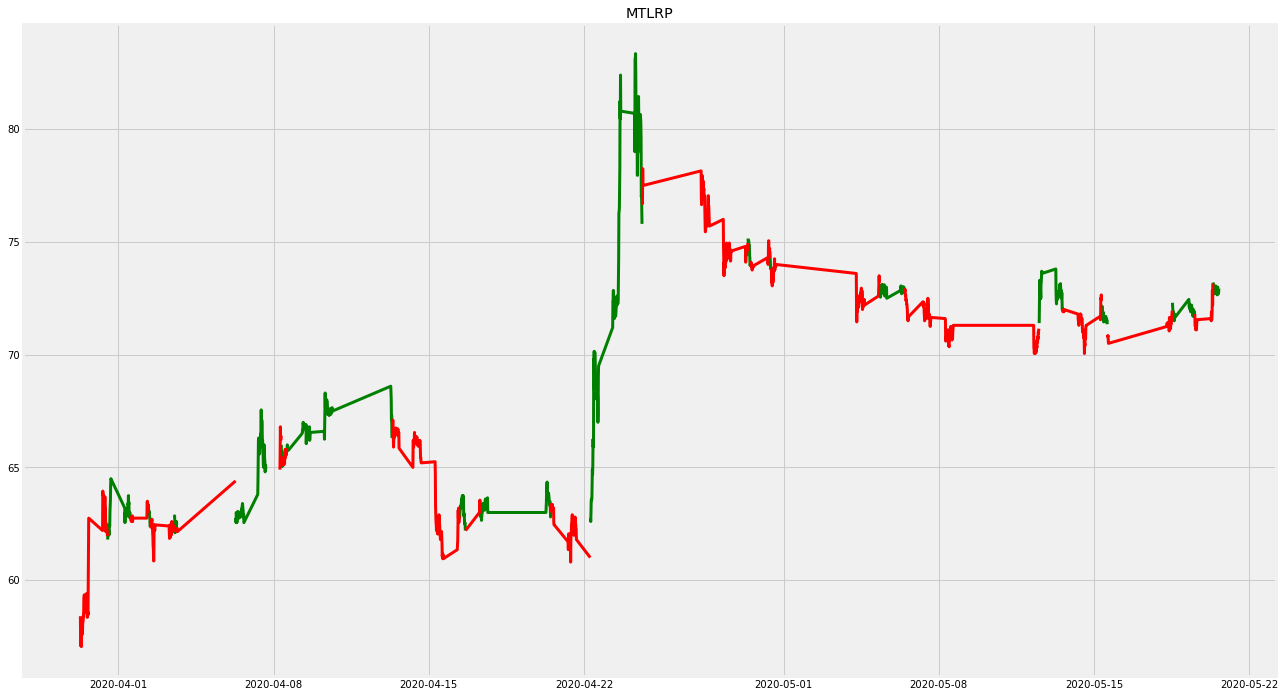

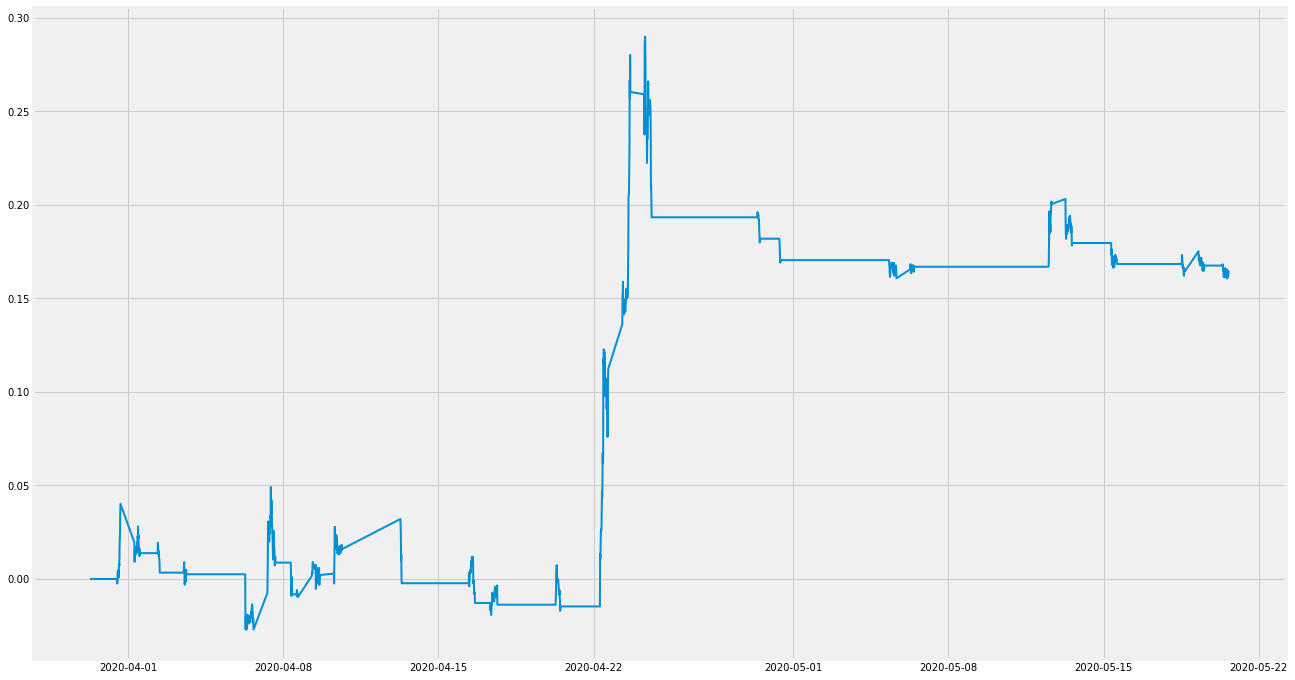

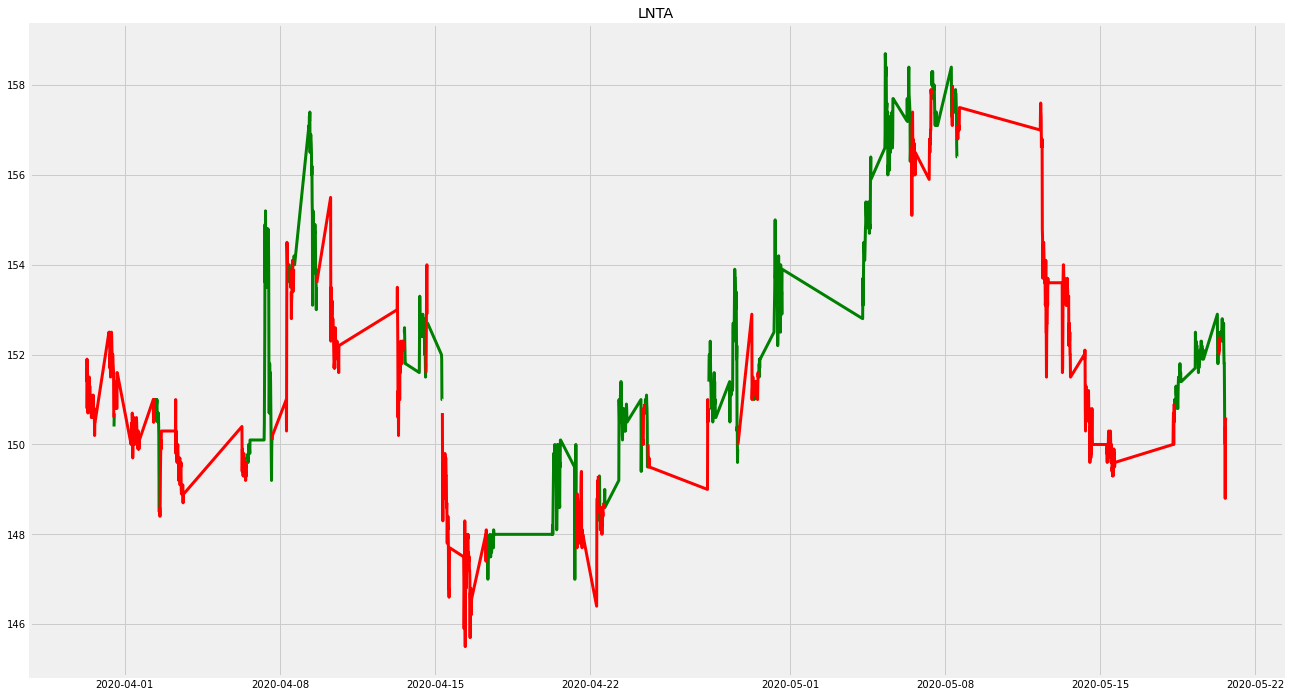

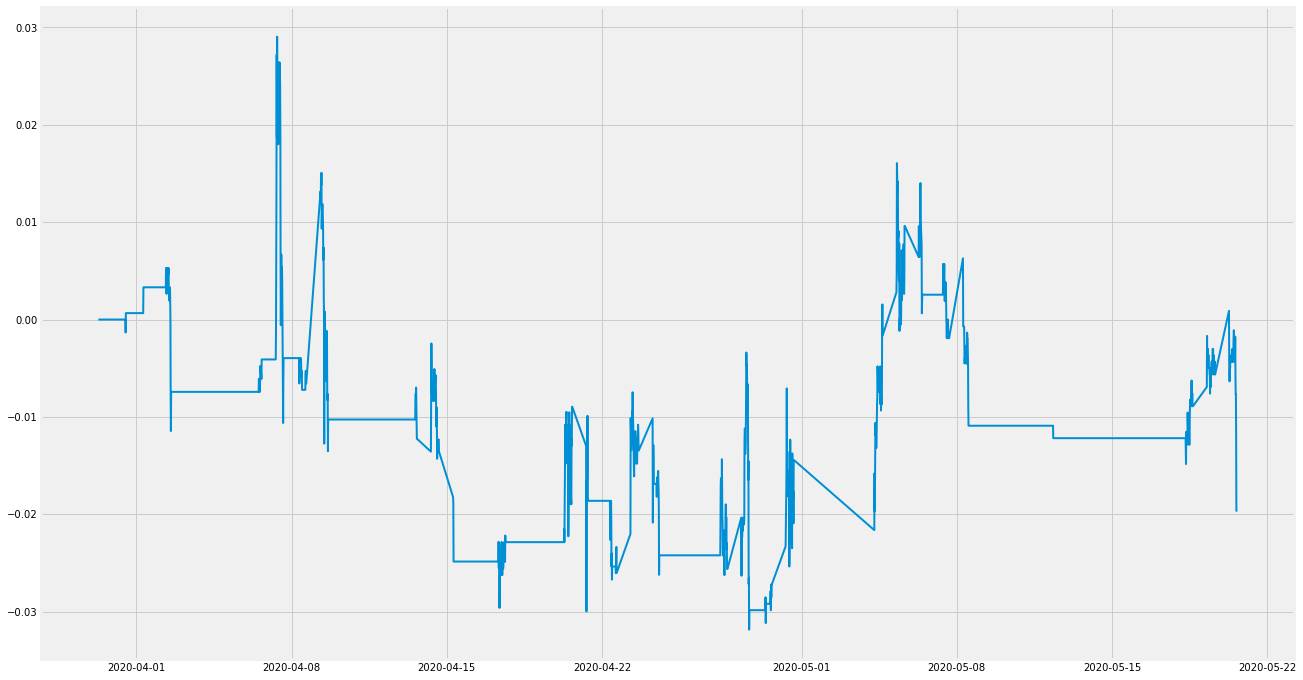

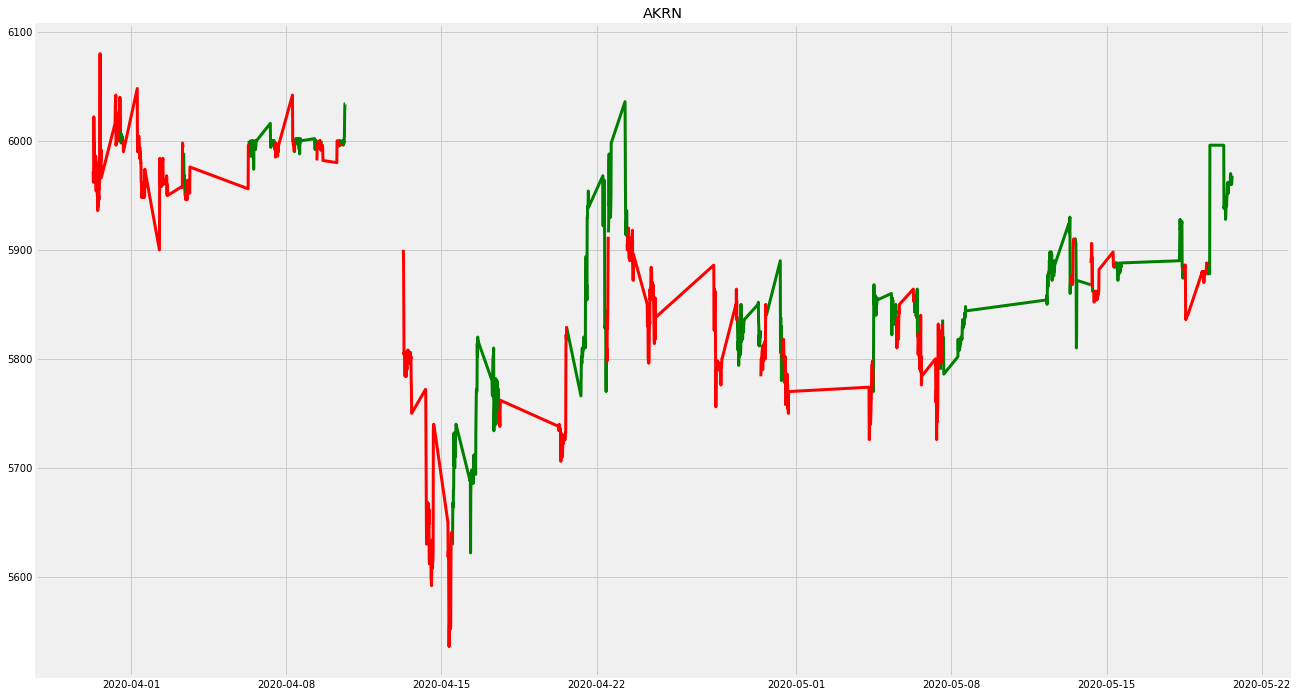

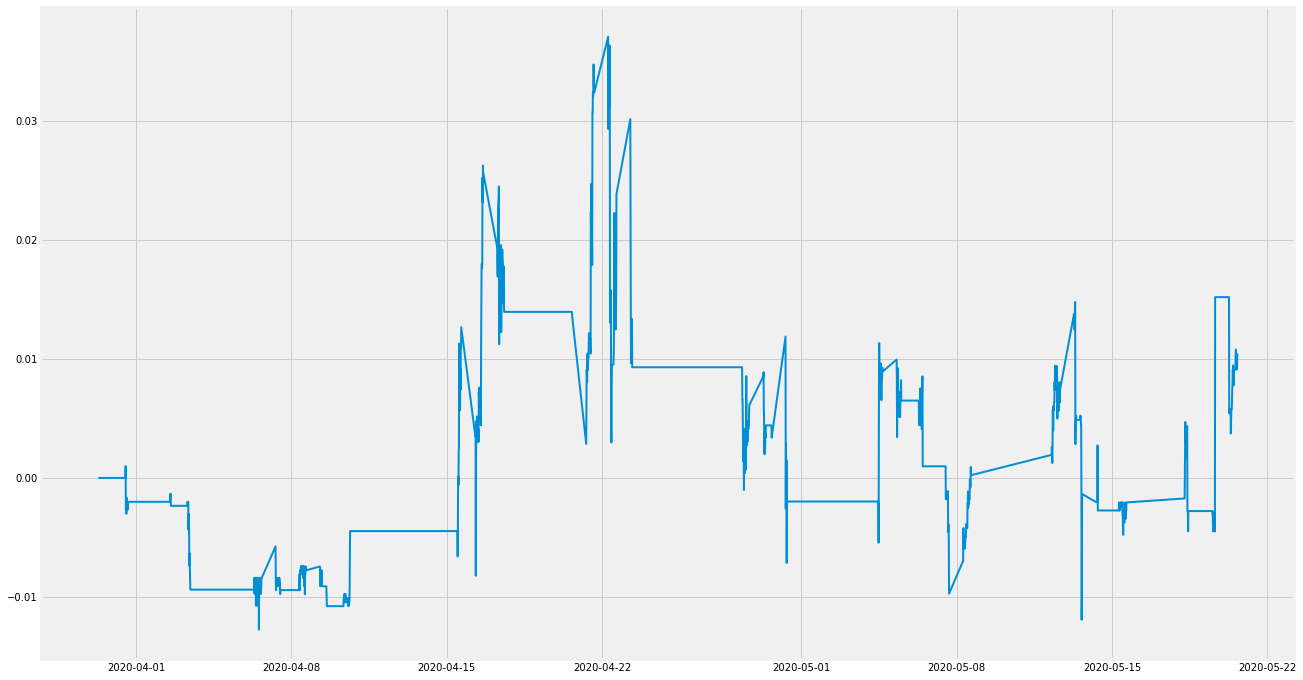

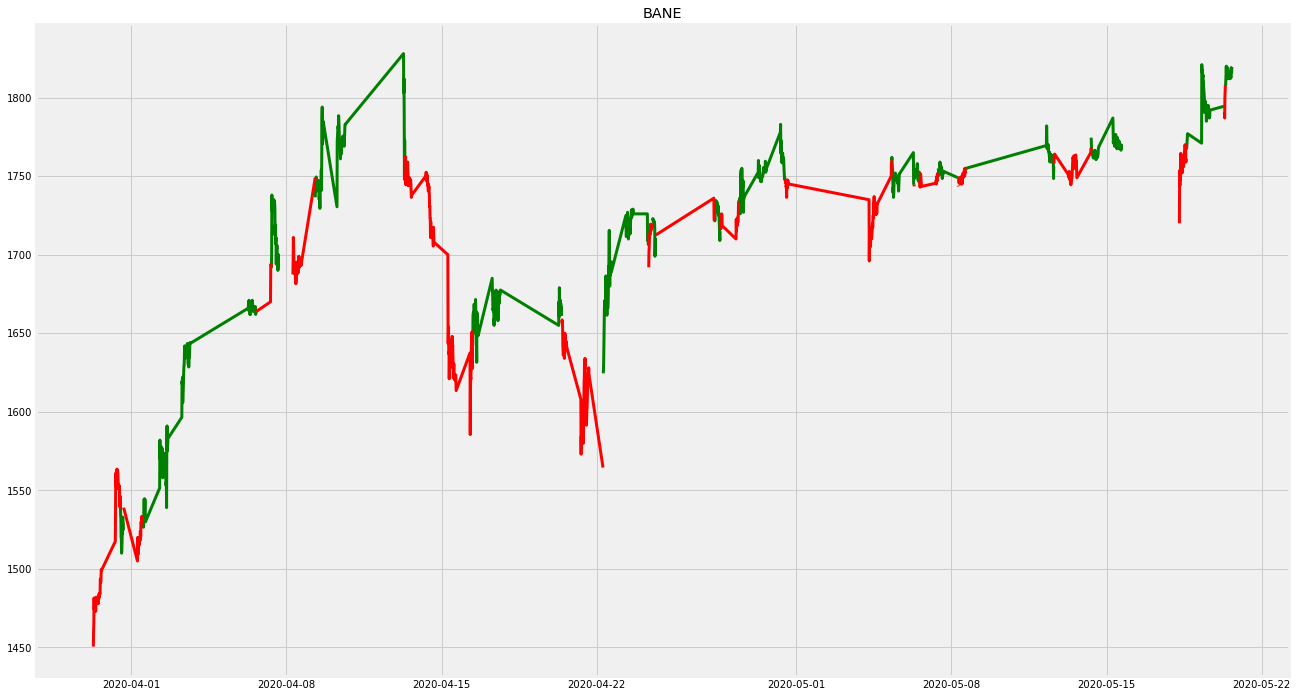

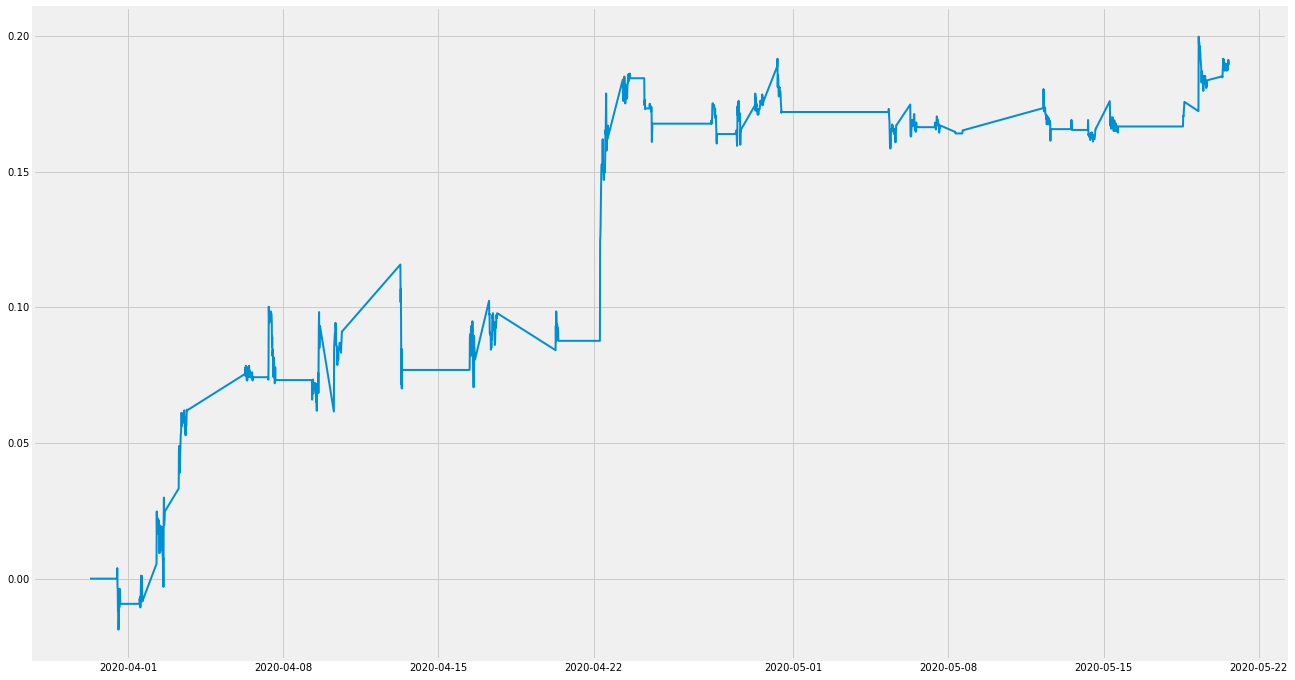

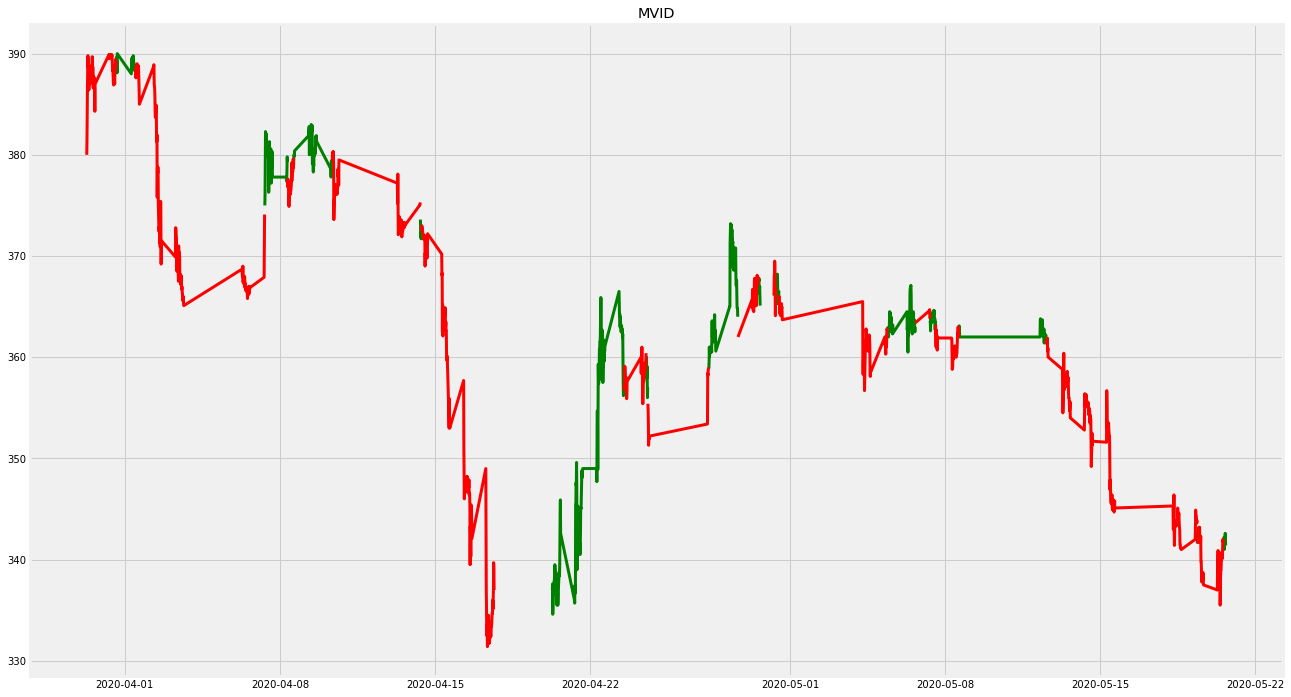

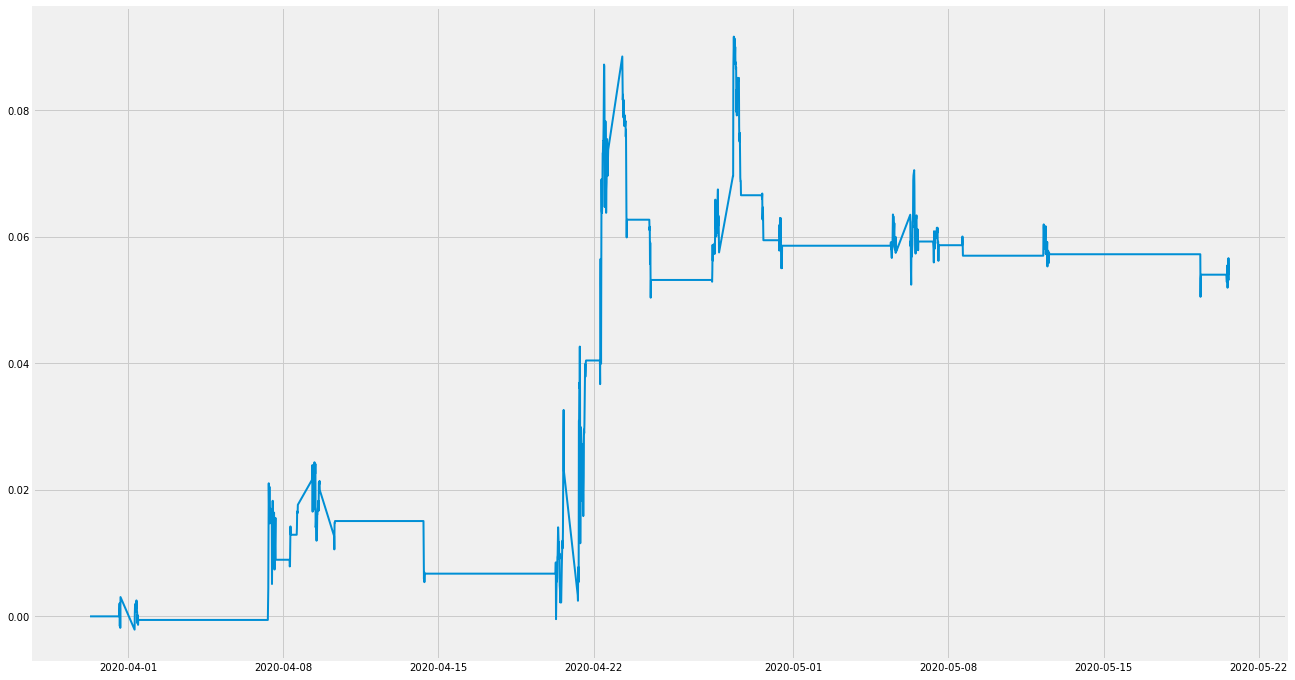

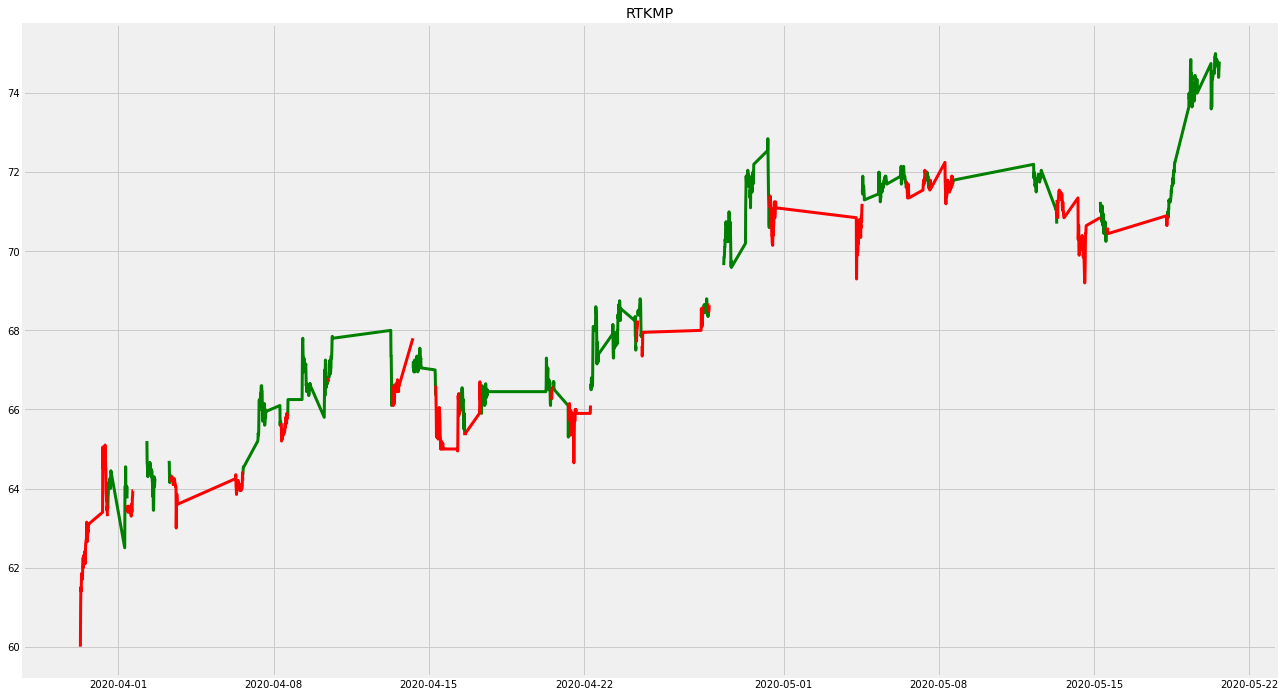

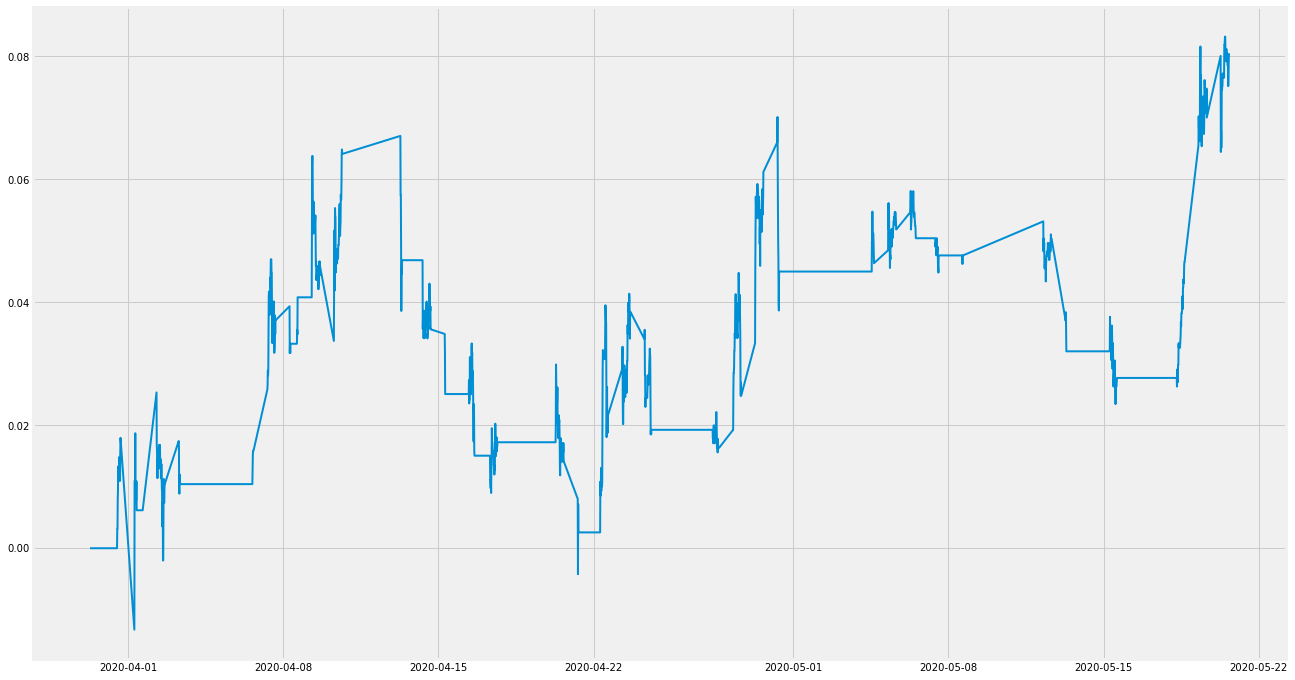

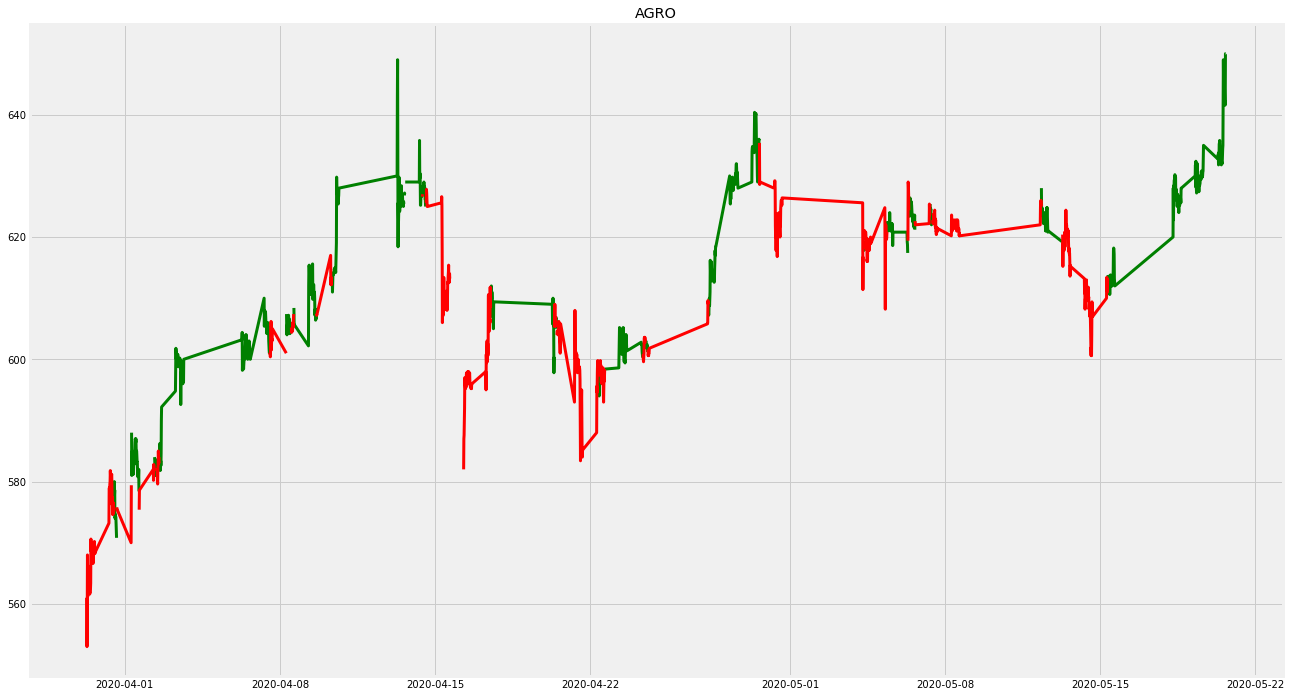

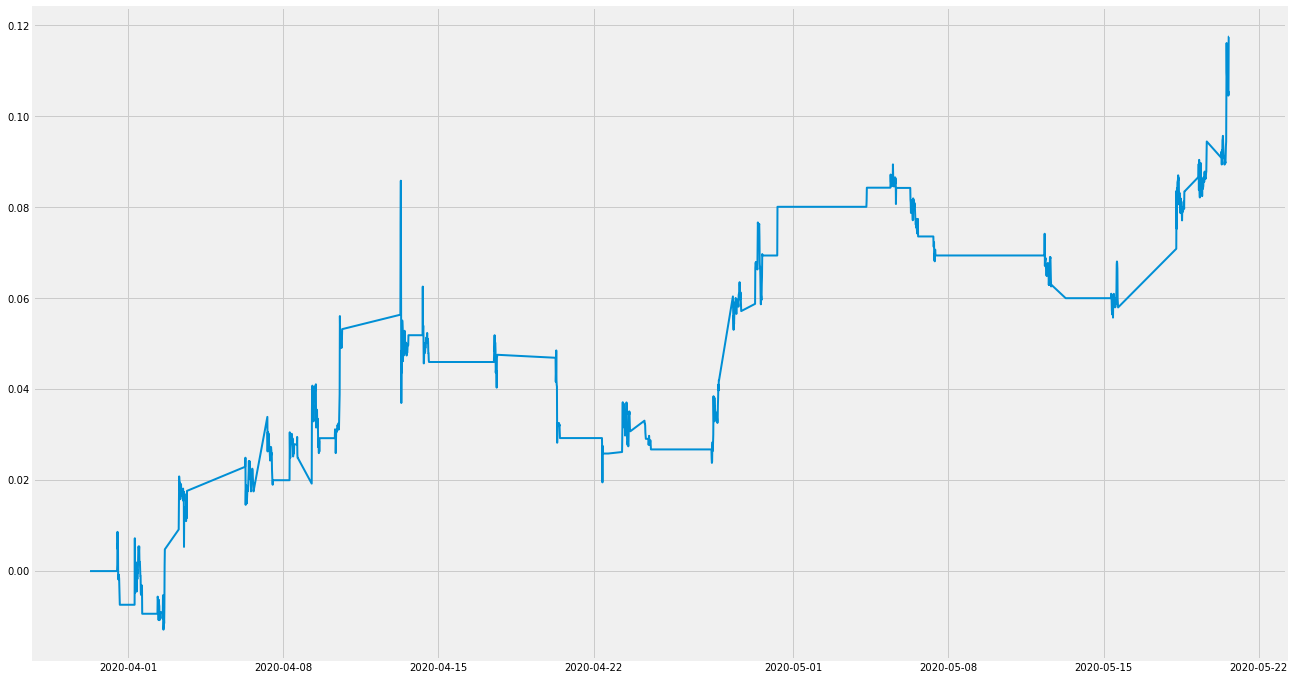

In [10]:
rezault_dict = {}
for tool in list(kot_dict):
    rezault_dict[tool] = tred_test(kot_dict[tool], tool)
    

In [30]:
rezault_df = pd.DataFrame(index= list(kot_dict))
for tool in rezault_df.index:
    df = rezault_dict[tool]
    rezault_df.loc[tool, 'max_drop'] = df[df.bank_change!=0]['bank_change'].min()*100
    rezault_df.loc[tool, 'max'] = df[df.bank_change!=0]['bank_change'].max()*100
    rezault_df.loc[tool, 'pct_drop'] = df[df.bank_change_izm<0].shape[0]/df.shape[0]*100
    rezault_df.loc[tool, 'itog'] = df.bank_change.values[-1] * 100
    rezault_df = rezault_df.round(2)
rezault_df.to_excel("stock_list.xlsx")
rezault_df

max_drop    max  pct_drop   itog
AFLT      -4.00   8.85     24.15   7.97
SBER      -3.34   7.28     23.91   6.79
GAZP      -2.72   6.94     25.04   6.71
LKOH      -0.02  20.54     24.15  20.34
GMKN      -2.90  13.63     25.41  13.02
MOEX       0.52  22.23     29.19  20.20
ROSN      -1.16  23.03     25.57  21.76
PLZL      -1.69  17.46     28.22   8.32
TATN      -1.08  18.16     22.27  10.03
MGNT      -0.42  15.70     26.05  13.72
MTSS      -2.17   5.40     28.24   3.53
IRAO      -0.61  11.51     26.81   3.53
SBERP     -1.34  10.74     20.68   8.03
YNDX      -3.18   6.38     25.68   3.63
SNGS       0.71  24.28     27.61  22.15
POLY      -4.20  15.34     25.69  11.89
NVTK      -1.27  24.60     26.99  24.60
TRNFP     -0.21  11.23     17.98   3.58
VTBR      -2.82  13.76     23.70  12.93
ALRS      -0.10  12.24     25.81  10.09
HYDR      -1.38  13.14     26.41  11.97
CHMF      -7.83   5.66     25.21  -2.67
TATNP     -2.20  21.34     24.15  15.19
TCSG      -0.39  25.67     24.77  24.08
NLMK      -4.43   7.21     23.38   3.98
SNGSP     -5.82   3.78     20.09  -4.81
MAGN      -8.35   4.04     26.20  -5.10
AFKS      -1.84  11.13     28.69  10.30
CBOM      -2.25   4.25     24.19   0.21
FIVE      -0.74  16.22     24.55   8.92
SIBN       0.42  20.44     24.38  17.65
FEES      -2.33  12.01     27.01   8.39
UPRO      -5.26   2.81     23.40  -4.04
RSTI      -1.60  14.87     27.07  13.91
RUAL      -3.68   3.72     25.94  -1.97
MTLR      -0.64  19.89     24.76   7.63
TRMK      -0.61  35.28     21.84  35.14
RTKM      -0.63  10.74     25.88   7.65
DSKY      -3.88  18.14     18.75  18.14
BANEP     -2.61  15.49     27.45  13.55
PHOR      -1.36   9.18     23.83   8.46
LSRG      -1.36   8.57     25.94   5.31
OGKB      -5.35   5.60     25.21  -2.76
TGKA      -2.96  14.64     26.15  14.55
LIFE      -3.16  36.48     15.17  16.34
QIWI      -2.49  21.46     23.51  13.94
RASP       0.20   8.12     28.44   5.60
PIKK      -5.16   3.70     18.52  -3.99
MTLRP     -2.71  29.00     21.19  16.48
LNTA      -3.19   2.91     21.75  -1.96
AKRN      -1.27   3.71     17.95   1.05
BANE      -1.88  19.97     27.10  19.12
MVID      -0.21   9.17     15.44   5.31
RTKMP     -1.32   8.32     24.89   8.05
AGRO      -1.29  11.75     26.62  11.75

In [34]:
for tool in rezault_df.index:
    df = rezault_dict[tool]
    if df.SIGNAL[-1] == True:
        if df.long_POZISION[-1] == True: 
            signal = 'Покупать'
        elif df.short_POZISION[-1] == True: 
            signal = 'Продавать'
        else: signal = 'Сигнал не определен'
        print(f'Сигнал по инструменту {tool}: {signal}')

Сигнал по инструменту POLY: Продавать


In [12]:
rezault_dict['TATNP']

Open        High         Low       Close  \
Datetime                                                                    
2020-03-30 09:45:00+03:00  494.000000  494.000000  494.000000  494.000000   
2020-03-30 10:00:00+03:00  494.799988  494.899994  478.000000  478.500000   
2020-03-30 10:15:00+03:00  478.500000  484.399994  475.200012  481.000000   
2020-03-30 10:30:00+03:00  480.600006  482.200012  477.500000  481.600006   
2020-03-30 10:45:00+03:00  481.799988  482.399994  479.200012  480.500000   
...                               ...         ...         ...         ...   
2020-05-20 17:45:00+03:00  528.200012  530.299988  527.500000  527.700012   
2020-05-20 18:00:00+03:00  527.700012  528.200012  525.500000  527.200012   
2020-05-20 18:15:00+03:00  527.200012  530.000000  527.200012  529.599976   
2020-05-20 18:30:00+03:00  529.599976  530.000000  528.900024  529.599976   
2020-05-20 18:45:00+03:00  529.099976  529.099976  529.099976  529.099976   

                            Adj Close  Volume      Median  ma_Close_10  \
Datetime                                                                 
2020-03-30 09:45:00+03:00  494.000000       0  494.000000          NaN   
2020-03-30 10:00:00+03:00  478.500000  317068  486.649994          NaN   
2020-03-30 10:15:00+03:00  481.000000  140841  479.750000          NaN   
2020-03-30 10:30:00+03:00  481.600006   40594  481.100006          NaN   
2020-03-30 10:45:00+03:00  480.500000   69579  481.149994          NaN   
...                               ...     ...         ...          ...   
2020-05-20 17:45:00+03:00  527.700012   59229  527.950012   527.649994   
2020-05-20 18:00:00+03:00  527.200012   24788  527.450012   527.500000   
2020-05-20 18:15:00+03:00  529.599976   37000  528.399994   527.500000   
2020-05-20 18:30:00+03:00  529.599976   39373  529.599976   527.500000   
2020-05-20 18:45:00+03:00  529.099976    1699  529.099976   527.500000   

                           ma_Median_60  ma_Volume_5   ma_razn  ma_razn_lag  \
Datetime                                                                      
2020-03-30 09:45:00+03:00           NaN          NaN       NaN          NaN   
2020-03-30 10:00:00+03:00           NaN          NaN       NaN          NaN   
2020-03-30 10:15:00+03:00           NaN          NaN       NaN          NaN   
2020-03-30 10:30:00+03:00           NaN          NaN       NaN          NaN   
2020-03-30 10:45:00+03:00           NaN      69579.0       NaN          NaN   
...                                 ...          ...       ...          ...   
2020-05-20 17:45:00+03:00    518.675018      34782.0  8.974976     8.774963   
2020-05-20 18:00:00+03:00    518.675018      24788.0  8.824982     8.974976   
2020-05-20 18:15:00+03:00    518.675018      37000.0  8.824982     8.824982   
2020-05-20 18:30:00+03:00    518.750000      39373.0  8.750000     8.824982   
2020-05-20 18:45:00+03:00    518.824997      37000.0  8.675003     8.750000   

                           SIGNAL  long_POZISION  short_POZISION  \
Datetime                                                           
2020-03-30 09:45:00+03:00   False          False           False   
2020-03-30 10:00:00+03:00   False          False           False   
2020-03-30 10:15:00+03:00   False          False           False   
2020-03-30 10:30:00+03:00   False          False           False   
2020-03-30 10:45:00+03:00   False          False           False   
...                           ...            ...             ...   
2020-05-20 17:45:00+03:00   False           True           False   
2020-05-20 18:00:00+03:00   False           True           False   
2020-05-20 18:15:00+03:00   False           True           False   
2020-05-20 18:30:00+03:00   False           True           False   
2020-05-20 18:45:00+03:00   False           True           False   

                           price_change  bank_change  bank_change_izm  \
Datetime                                                                
2020-03-3

In [13]:
rezault_dict['TATNP'].bank_change.values[-1]

0.15194343608786176